# BIBLIOTECAS

In [2]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import shap
import statsmodels.formula.api as smf
import xgboost as xgb
import yaml
from feature_engine.encoding import MeanEncoder, OneHotEncoder, RareLabelEncoder
from feature_engine.selection import RecursiveFeatureAddition
from IPython.core.display import HTML
from IPython.display import Image
from matplotlib import pyplot as plt
from scipy import stats as ss
from scipy.cluster import hierarchy
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.classifier import PrecisionRecallCurve

warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = 12, 8

pd.set_option("display.max_columns", 30)

# Funçoes Auxiliares

In [3]:
def import_config(path_yaml):
    with open(path_yaml) as config_file:
        config = yaml.safe_load(config_file)
    return config

def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n 
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def reamostrar_lr(df, frac):
    x_train_2, x_test_2 = train_test_split(df, test_size=config['split']['teste_size'], random_state=config['split']['seed'], stratify=df['pago'])
    
    sample = x_train_2[x_train_2['pago']==0].sample(frac=frac, random_state=config['split']['seed'])
    x_train_2 = x_train_2.drop(sample.index)
    x_train_2['pago'].value_counts(normalize=True)

    x_train = x_train_2.drop(['pago'], axis='columns')
    y_train = x_train_2['pago']

    y_test = x_test_2['pago']
    
    return x_train, x_train_2, x_test_2.drop(['pago'], axis='columns'), y_test

def cm_roc_plot(model, x_test, y_test, th=0.5):

    yhat_lr = model.predict(x_test)
    print(pd.crosstab(y_test, yhat_lr, rownames=['Real'], colnames=['     Predito'],margins=True))
    print('\n\n')
    print(metrics.classification_report(y_test, yhat_lr))
    print('\n')

    yhat_lr_prob = model.predict_proba(x_test)[:,1]

    lr_auc = round(roc_auc_score(y_test, yhat_lr_prob),2)
    print(f'ROC_AUC {lr_auc}')

    lr_frp, lr_tpr, _ = metrics.roc_curve(y_test, yhat_lr_prob)

    fig, ax = plt.subplots(figsize=(12,8))

    plt.plot(lr_frp, lr_tpr, linestyle='--', label = 'prediction (AUROC = %0.3f)' % lr_auc)

    ax.plot([0,1],[0,1], transform=ax.transAxes)

    # Title
    plt.title('ROC Plot', fontsize=15, weight='bold')

    # Axis labels

    plt.xticks(fontsize=15, weight='bold')
    plt.yticks(fontsize=15, weight='bold');

    # recall class 1 = True positive rate (TP / (TP + FN))
    plt.ylabel("True positive rate", fontsize=15, weight='bold')
    # recal class 0 = 1 False positive rate (FP / FP + TN)
    plt.xlabel("False positive rate", fontsize=15, weight='bold')

    plt.legend()
    plt.show()

    yhat_lr_2 = (yhat_lr_prob > th).astype(int)
    print(pd.crosstab(y_test, yhat_lr_2, rownames=['Real'], colnames=['     Predito'],margins=True))
    print('\n\n')
    print(metrics.classification_report(y_test, yhat_lr_2))
    print('\n')

def cv_clf_metrics(model, df, target, cv, model_name, search=False):
    X = df.drop(target, axis='columns')
    y = df[target]

    train_metrics = {'precision_0': [], 'precision_1': [], 'recall_0': [], 'recall_1': [], 'f1_0': [], 'f1_1': [], 'accuracy': [], 'roc_auc': [], 'balanced_accuracy': []}
    test_metrics = {'precision_0': [], 'precision_1': [], 'recall_0': [], 'recall_1': [], 'f1_0': [], 'f1_1': [], 'accuracy': [], 'roc_auc': [], 'balanced_accuracy':[]}

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if(search==False):
            model.fit(X_train, y_train)

        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)

        train_predictions_proba = model.predict_proba(X_train)[:,1]
        test_predictions_proba = model.predict_proba(X_test)[:,1]

        # Calculate metrics for train
        train_metrics['precision_0'].append(np.round(precision_score(y_train,train_predictions, pos_label=0),3))
        train_metrics['recall_0'].append(np.round(recall_score(y_train,train_predictions, pos_label=0),3))
        train_metrics['f1_0'].append(np.round(f1_score(y_train,train_predictions, pos_label=0),3))
        train_metrics['accuracy'].append(np.round(accuracy_score(y_train,train_predictions),3))
        train_metrics['roc_auc'].append(np.round(roc_auc_score(y_train,train_predictions_proba),3))
        train_metrics['balanced_accuracy'].append(np.round(balanced_accuracy_score(y_train,train_predictions),3))
        train_metrics['precision_1'].append(np.round(precision_score(y_train,train_predictions, pos_label=1),3))
        train_metrics['recall_1'].append(np.round(recall_score(y_train,train_predictions, pos_label=1),3))
        train_metrics['f1_1'].append(np.round(f1_score(y_train,train_predictions, pos_label=1),3))


        # Calculate metric for test
        test_metrics['precision_0'].append(np.round(precision_score(y_test,test_predictions, pos_label=0),3))
        test_metrics['recall_0'].append(np.round(recall_score(y_test,test_predictions, pos_label=0),3))
        test_metrics['f1_0'].append(np.round(f1_score(y_test,test_predictions, pos_label=0),3))
        test_metrics['accuracy'].append(np.round(accuracy_score(y_test,test_predictions),3))
        test_metrics['roc_auc'].append(np.round(roc_auc_score(y_test,test_predictions_proba),3))
        test_metrics['balanced_accuracy'].append(np.round(balanced_accuracy_score(y_test,test_predictions),3))
        test_metrics['precision_1'].append(np.round(precision_score(y_test,test_predictions, pos_label=1),3))
        test_metrics['recall_1'].append(np.round(recall_score(y_test,test_predictions, pos_label=1),3))
        test_metrics['f1_1'].append(np.round(f1_score(y_test,test_predictions, pos_label=1),3))

    train_precision_class_0 = train_metrics['precision_0']
    train_recall_class_0 = train_metrics['recall_0']
    train_f1_class_0 = train_metrics['f1_0']
    train_accuracy = train_metrics['accuracy']
    train_roc_auc = train_metrics['roc_auc']
    train_balanced_accuracy = train_metrics['balanced_accuracy']
    train_precision_class_1 = train_metrics['precision_1']
    train_recall_class_1 = train_metrics['recall_1']
    train_f1_class_1 = train_metrics['f1_1']

    # Calculate metricas for teste
    test_precision_class_0 = test_metrics['precision_0']
    test_recall_class_0 = test_metrics['recall_0']
    test_f1_class_0 = test_metrics['f1_0']
    test_accuracy = test_metrics['accuracy']
    test_roc_auc = test_metrics['roc_auc']
    test_balanced_accuracy = test_metrics['balanced_accuracy']
    test_precision_class_1 = test_metrics['precision_1']
    test_recall_class_1 = test_metrics['recall_1']
    test_f1_class_1 = test_metrics['f1_1']

    print('TRAIN DATA')
    print(f'accuracy: {train_accuracy} / media: {np.round(np.mean(train_accuracy),3)} / std: {np.round(np.std(train_accuracy),3)}')
    print(f'balanced_accuracy: {train_balanced_accuracy} / media: {np.round(np.mean(train_balanced_accuracy),3)} / std: {np.round(np.std(train_balanced_accuracy),3)}')
    print(f'roc_auc: {train_roc_auc} / media: {np.round(np.mean(train_roc_auc),3)} / std: {np.round(np.std(train_roc_auc),3)}')
    print(f'f1_class_0: {train_f1_class_0} / media: {np.round(np.mean(train_f1_class_0),3)} / std: {np.round(np.std(train_f1_class_0),3)}')
    print(f'f1_class_1: {train_f1_class_1} / media: {np.round(np.mean(train_f1_class_1),3)} / std: {np.round(np.std(train_f1_class_1),3)}')
    print(f'precision_class_0: {train_precision_class_0} / media: {np.round(np.mean(train_precision_class_0),3)} / std: {np.round(np.std(train_precision_class_0),3)}')
    print(f'precision_class_1: {train_precision_class_1} / media: {np.round(np.mean(train_precision_class_1),3)} / std: {np.round(np.std(train_precision_class_1),3)}')
    print(f'recall_class_0: {train_recall_class_0} / media: {np.round(np.mean(train_recall_class_0),3)} / std: {np.round(np.std(train_recall_class_0),3)}')
    print(f'recall_class_1: {train_recall_class_1} / media: {np.round(np.mean(train_recall_class_1),3)} / std: {np.round(np.std(train_recall_class_1),3)}')

    print("\n-----------------------------------------------------------------\n")

    print('TEST DATA')
    print(f'accuracy: {test_accuracy} / media: {np.round(np.mean(test_accuracy),3)} / std: {np.round(np.std(test_accuracy),3)}')
    print(f'balanced_accuracy: {test_balanced_accuracy} / media: {np.round(np.mean(test_balanced_accuracy),3)} / std: {np.round(np.std(test_balanced_accuracy),3)}')
    print(f'roc_auc: {test_roc_auc} / media: {np.round(np.mean(test_roc_auc),3)} / std: {np.round(np.std(test_roc_auc),3)}')
    print(f'f1_class_0: {test_f1_class_0} / media: {np.round(np.mean(test_f1_class_0),3)} / std: {np.round(np.std(test_f1_class_0),3)}')
    print(f'f1_class_1: {test_f1_class_1} / media: {np.round(np.mean(test_f1_class_1),3)} / std: {np.round(np.std(test_f1_class_1),3)}')
    print(f'precision_class_0: {test_precision_class_0} / media: {np.round(np.mean(test_precision_class_0),3)} / std: {np.round(np.std(test_precision_class_0),3)}')
    print(f'precision_class_1: {test_precision_class_1} / media: {np.round(np.mean(test_precision_class_1),3)} / std: {np.round(np.std(test_precision_class_1),3)}')
    print(f'recall_class_0: {test_recall_class_0} / media: {np.round(np.mean(test_recall_class_0),3)} / std: {np.round(np.std(test_recall_class_0),3)}')
    print(f'recall_class_1: {test_recall_class_1} / media: {np.round(np.mean(test_recall_class_1),3)} / std: {np.round(np.std(test_recall_class_1),3)}')

    result = pd.DataFrame({'Model Name': model_name,
                            'Accuracy CV': np.round(np.mean(test_accuracy),3).astype(str) + '+/-' + np.round(np.std(test_accuracy),3).astype(str),
                            'balanced_accuracy CV': np.round(np.mean(test_balanced_accuracy),3).astype(str) + '+/-' + np.round(np.std(test_balanced_accuracy),3).astype(str),
                            'Roc Auc Score CV': np.round(np.mean(test_roc_auc),3).astype(str) + '+/-' + np.round(np.std(test_roc_auc),3).astype(str),
                            'Precision Class 0 CV': np.round(np.mean(test_precision_class_0),3).astype(str) + '+/-' + np.round(np.std(test_precision_class_0),3).astype(str),
                            'Precision Class 1 CV': np.round(np.mean(test_precision_class_1),3).astype(str) + '+/-' + np.round(np.std(test_precision_class_1),3).astype(str),
                            'Recall Class 0 CV': np.round(np.mean(test_recall_class_0),3).astype(str) + '+/-' + np.round(np.std(test_recall_class_0),3).astype(str),
                            'Recall Class 1 CV': np.round(np.mean(test_recall_class_1),3).astype(str) + '+/-' + np.round(np.std(test_recall_class_1),3).astype(str),
                            'F1 Class 0 CV': np.round(np.mean(test_f1_class_0),3).astype(str) + '+/-' + np.round(np.std(test_f1_class_0),3).astype(str),
                            'F1 Class 1 CV': np.round(np.mean(test_f1_class_1),3).astype(str) + '+/-' + np.round(np.std(test_f1_class_1),3).astype(str)}, index=[0])
    display(result)
    return result

def test_metric(model, x_test, y_test, model_name):
    test_metrics = {'precision_0': [], 'precision_1': [], 'recall_0': [], 'recall_1': [], 'f1_0': [], 'f1_1': [], 'accuracy': [], 'roc_auc': [], 'balanced_accuracy': []}

    # Test evaluation metrics
    test_predictions = model.predict(x_test)
    test_predictions_proba = model.predict_proba(x_test)[:,1]

    # Calculate metrics for train
    test_metrics['precision_0'].append(np.round(precision_score(y_test,test_predictions, pos_label=0),3))
    test_metrics['recall_0'].append(np.round(recall_score(y_test,test_predictions, pos_label=0),3))
    test_metrics['f1_0'].append(np.round(f1_score(y_test,test_predictions, pos_label=0),3))
    test_metrics['accuracy'].append(np.round(accuracy_score(y_test,test_predictions),3))
    test_metrics['roc_auc'].append(np.round(roc_auc_score(y_test,test_predictions_proba),3))
    test_metrics['balanced_accuracy'].append(np.round(balanced_accuracy_score(y_test,test_predictions),3))
    test_metrics['precision_1'].append(np.round(precision_score(y_test,test_predictions, pos_label=1),3))
    test_metrics['recall_1'].append(np.round(recall_score(y_test,test_predictions, pos_label=1),3))
    test_metrics['f1_1'].append(np.round(f1_score(y_test,test_predictions, pos_label=1),3))

    # Create pandas DataFrames
    test_df = pd.DataFrame(test_metrics)

    test_df['model_name'] = model_name

    return test_df

def silhoette_score(df, model, k_start, k_end):
    cluster_list = []
    n_cluster = list(range(k_start, k_end+1))

    for k in n_cluster:

        if(model == 'gmm'):
            cluster_model = GaussianMixture(n_components=k, random_state=config['split']['seed'])
            cluster_model.fit(df)
            labels = cluster_model.predict(df)

        elif(model == 'kmeans'):
            cluster_model = KMeans(n_clusters=k, random_state=config['split']['seed'])
            cluster_model.fit(df)
            labels = cluster_model.predict(df)
        
        elif(model == 'hierarchy'):
            cluster_model = hierarchy.linkage(df, 'ward')
            labels = hierarchy.fcluster(model, k, criterion='maxclust')


        sil = metrics.silhouette_score(df, labels, metric='euclidean')
        cluster_list.append(sil)
    
    plt.plot(n_cluster, cluster_list, linestyle='--', marker='o', color = 'b')
    plt.xlabel('k');
    plt.ylabel('Silhoutte Score');
    plt.title('Silhoutte Score x k')
    plt.show()

def tabela_resultado_final(df):
    num_attributes = df.select_dtypes(include=['int64', 'int32','float64'])
    cat_attributes = df.select_dtypes(exclude=['int64', 'int32','float64', 'datetime64[ns]'])

    aux_cluster = pd.DataFrame()
    aux = pd.DataFrame()
    aux_2 = pd.DataFrame()

    for coluna in num_attributes.columns[:-1]:
        if aux.empty:
            aux = df.groupby('cluster')[coluna].mean().reset_index()
        else:
            aux = df.groupby('cluster')[coluna].mean()

        aux_cluster = pd.concat([aux_cluster, aux], axis='columns')

    for coluna in cat_attributes.columns:
        aux_2 = df.groupby(['cluster', coluna]).size().unstack(fill_value=0).reset_index(drop=True).apply(lambda x: round(x/ x.sum(), 2), axis='columns')
        aux_cluster = pd.concat([aux_cluster, aux_2], axis='columns')

    aux_cluster['contagem'] = df.groupby('cluster')['cluster'].count().reset_index(drop=True)
    total_count = aux_cluster['contagem'].sum()
    aux_cluster['Percentage'] = round((aux_cluster['contagem']/total_count)*100,1)

    display(aux_cluster.sort_values('inadimplente').T.style.format("{:.2f}").background_gradient(axis='columns'))

# 1.0 IMPORT DATA AND CONFIG

### 1.1 CONFIG

In [4]:
config = import_config('config.yaml')

In [5]:
config['data']['raw_path']

'../data/raw/raw_data.csv'

## 1.2 DATA

In [15]:
df1 = pd.read_csv(config['data']['raw_path'])

In [16]:
df1.head()

escolaridade  renda_mensal_informal dependentes  \
0          NaN                    NaN           S   
1  nivel medio              1894.5078           N   
2  nivel medio                    NaN           S   
3          NaN                    NaN           N   
4          NaN                    NaN           S   

                     estado_civil  idade conta_poupanca conta_salario  \
0                        solteiro     36              S             N   
1                        solteiro     39              S             N   
2                        solteiro     26              S             N   
3  casado(a) com comunhao de bens     23              N             N   
4                        solteiro     33              S             N   

   qtd_fonte_renda cheque_sem_fundo conta_conjunta  valor_conta_corrente  \
0              NaN                S              N                   NaN   
1              1.0                N              N                   NaN   
2              1.0                N              N                   NaN   
3              NaN                S              N                   NaN   
4              NaN                S              N                   NaN   

   valor_conta_poupanca  valor_emprestimo     multa      juros  \
0                   NaN           8174.32    263.25    5844.98   
1                   NaN          41775.63   1607.29    7652.26   
2                   NaN         522940.27  24860.40  319315.62   
3                   NaN           1418.00  21472.36    2967.48   
4                   NaN           2078.97     19.44      46.35   

   valor_emprestimo_atualizado pago         id     genero        data  \
0                     14282.55  sim  309652396   feminino  2020-01-01   
1                     51035.18  sim  498764591   feminino  2020-01-01   
2                    867116.29  sim  504868288  masculino  2020-01-01   
3                     25857.84  sim  541365315   feminino  2020-01-01   
4                      2144.76  sim  563622907  masculino  2020-01-01   

           estado  
0    minas gerais  
1  espirito santo  
2       sao paulo  
3       sao paulo  
4  espirito santo

# 2.0 DATA CLEAN

In [7]:
df2 = df1.copy()

## 2.1 DESCRIÇÃO DOS DADOS

In [8]:
df2.head()

escolaridade  renda_mensal_informal dependentes  \
0          NaN                    NaN           S   
1  nivel medio              1894.5078           N   
2  nivel medio                    NaN           S   
3          NaN                    NaN           N   
4          NaN                    NaN           S   

                     estado_civil  idade conta_poupanca conta_salario  \
0                        solteiro     36              S             N   
1                        solteiro     39              S             N   
2                        solteiro     26              S             N   
3  casado(a) com comunhao de bens     23              N             N   
4                        solteiro     33              S             N   

   qtd_fonte_renda cheque_sem_fundo conta_conjunta  valor_conta_corrente  \
0              NaN                S              N                   NaN   
1              1.0                N              N                   NaN   
2              1.0                N              N                   NaN   
3              NaN                S              N                   NaN   
4              NaN                S              N                   NaN   

   valor_conta_poupanca  valor_emprestimo     multa      juros  \
0                   NaN           8174.32    263.25    5844.98   
1                   NaN          41775.63   1607.29    7652.26   
2                   NaN         522940.27  24860.40  319315.62   
3                   NaN           1418.00  21472.36    2967.48   
4                   NaN           2078.97     19.44      46.35   

   valor_emprestimo_atualizado pago         id     genero        data  \
0                     14282.55  sim  309652396   feminino  2020-01-01   
1                     51035.18  sim  498764591   feminino  2020-01-01   
2                    867116.29  sim  504868288  masculino  2020-01-01   
3                     25857.84  sim  541365315   feminino  2020-01-01   
4                      2144.76  sim  563622907  masculino  2020-01-01   

           estado  
0    minas gerais  
1  espirito santo  
2       sao paulo  
3       sao paulo  
4  espirito santo

## 2.2 DIMENSÃO DOS DADOS

In [9]:
df2.shape

(50390, 21)

## 2.3 TIPO DA COLUNA

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50390 entries, 0 to 50389
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   escolaridade                 14615 non-null  object 
 1   renda_mensal_informal        9768 non-null   float64
 2   dependentes                  50390 non-null  object 
 3   estado_civil                 50390 non-null  object 
 4   idade                        50390 non-null  int64  
 5   conta_poupanca               50390 non-null  object 
 6   conta_salario                50390 non-null  object 
 7   qtd_fonte_renda              12806 non-null  float64
 8   cheque_sem_fundo             50390 non-null  object 
 9   conta_conjunta               50390 non-null  object 
 10  valor_conta_corrente         0 non-null      float64
 11  valor_conta_poupanca         0 non-null      float64
 12  valor_emprestimo             50390 non-null  float64
 13  multa           

## 2.4 CHECAR NAN VALUES

In [11]:
df2.isna().sum() / len(df2)

escolaridade                   0.709962
renda_mensal_informal          0.806152
dependentes                    0.000000
estado_civil                   0.000000
idade                          0.000000
conta_poupanca                 0.000000
conta_salario                  0.000000
qtd_fonte_renda                0.745862
cheque_sem_fundo               0.000000
conta_conjunta                 0.000000
valor_conta_corrente           1.000000
valor_conta_poupanca           1.000000
valor_emprestimo               0.000000
multa                          0.000000
juros                          0.000000
valor_emprestimo_atualizado    0.000000
pago                           0.000000
id                             0.000000
genero                         0.000000
data                           0.000000
estado                         0.000000
dtype: float64

## 2.5 DROPAR LINHAS DUPLICADAS

In [12]:
df2.drop_duplicates().shape

(50390, 21)

## 2.6 MUDAR TIPO DA VARIAVAL

In [13]:
df2['data'] = df2['data'].astype('datetime64[ns]')

## 2.7 DROP COLUNAS

In [14]:
# 100% vazio não tem como avaliar o dado
df2 = df2.drop(['valor_conta_corrente', 'valor_conta_poupanca'], axis='columns')

df2 = df2.drop(['escolaridade', 'renda_mensal_informal', 'qtd_fonte_renda'], axis='columns')

df2 = df2.drop(['data'], axis='columns')


## 2.8 ESTATISTICA DESCRITIVA

In [15]:
num_attributes = df2.select_dtypes(include=['int64', 'float64'])

cat_attributes = df2.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])


### 2.8 .1 VARIAVES NUMERICAS

In [16]:
# Tendencia central - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - sdt, min, max, range, skew, kurtosis

d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(np.min)).T
d3 = pd.DataFrame( num_attributes.apply(np.max)).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

attributes           min           max         range  \
0                        idade  1.800000e+01  1.130000e+02  9.500000e+01   
1             valor_emprestimo  1.393000e+03  2.867894e+08  2.867880e+08   
2                        multa  0.000000e+00  5.737759e+08  5.737759e+08   
3                        juros  0.000000e+00  5.703619e+08  5.703619e+08   
4  valor_emprestimo_atualizado  1.397040e+03  1.430927e+09  1.430926e+09   
5                           id  1.000172e+08  9.999988e+08  8.999816e+08   

           mean        median           std        skew      kurtosis  
0  3.172453e+01  3.000000e+01  8.565032e+00    1.959951      7.223175  
1  5.198887e+04  2.298035e+03  1.588803e+06  135.859233  22605.724510  
2  6.022658e+04  6.489650e+02  2.843913e+06  171.305766  33333.600930  
3  6.485391e+04  1.143320e+03  2.728143e+06  184.431138  38002.805365  
4  1.770694e+05  5.652695e+03  7.058294e+06  171.822788  33820.743108  
5  5.485969e+08  5.482058e+08  2.601475e+08    0.007412     -1.203943

In [17]:
num_attributes.describe(percentiles=[0.99, 0.95,0.75,0.5]).T

count          mean           std  \
idade                        50390.0  3.172453e+01  8.565117e+00   
valor_emprestimo             50390.0  5.198887e+04  1.588819e+06   
multa                        50390.0  6.022658e+04  2.843941e+06   
juros                        50390.0  6.485391e+04  2.728170e+06   
valor_emprestimo_atualizado  50390.0  1.770694e+05  7.058364e+06   
id                           50390.0  5.485969e+08  2.601500e+08   

                                      min           50%           75%  \
idade                        1.800000e+01  3.000000e+01  3.500000e+01   
valor_emprestimo             1.393000e+03  2.298035e+03  7.172175e+03   
multa                        0.000000e+00  6.489650e+02  3.600000e+03   
juros                        0.000000e+00  1.143320e+03  5.545427e+03   
valor_emprestimo_atualizado  1.397040e+03  5.652695e+03  1.903061e+04   
id                           1.000172e+08  5.482058e+08  7.737146e+08   

                                      95%           99%           max  
idade                        4.800000e+01  6.200000e+01  1.130000e+02  
valor_emprestimo             5.879202e+04  4.464769e+05  2.867894e+08  
multa                        6.189092e+04  5.039267e+05  5.737759e+08  
juros                        8.235361e+04  6.408426e+05  5.703619e+08  
valor_emprestimo_atualizado  2.006742e+05  1.586720e+06  1.430927e+09  
id                           9.542667e+08  9.912031e+08  9.999988e+08

### 2.8.2 VARIAVEIS CATEGORICAS

In [18]:
for i in cat_attributes.columns:
    print(cat_attributes[i].value_counts(normalize=True))
    print('==========================\n\n')

dependentes
N    0.639968
S    0.360032
Name: proportion, dtype: float64


estado_civil
solteiro                                  0.547053
casado(a) com comunhao parcial de bens    0.263604
casado(a) com comunhao de bens            0.154098
casado(a) com separacao de bens           0.030959
separado judicialmente                    0.001469
divorciado                                0.001330
viuvo(a)                                  0.000814
outros                                    0.000675
Name: proportion, dtype: float64


conta_poupanca
S    0.847986
N    0.152014
Name: proportion, dtype: float64


conta_salario
N    0.976603
S    0.023397
Name: proportion, dtype: float64


cheque_sem_fundo
S    0.769974
N    0.230026
Name: proportion, dtype: float64


conta_conjunta
N    0.958285
S    0.041715
Name: proportion, dtype: float64


pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64


genero
masculino    0.501667
feminino     0.498333
Name: proportion, dtype: float64


# 3.0 MIND MAP E ENGENHARIA DE VARIAVEIS

In [19]:
df3 =df2.copy()

## 3.1 MIND MAP

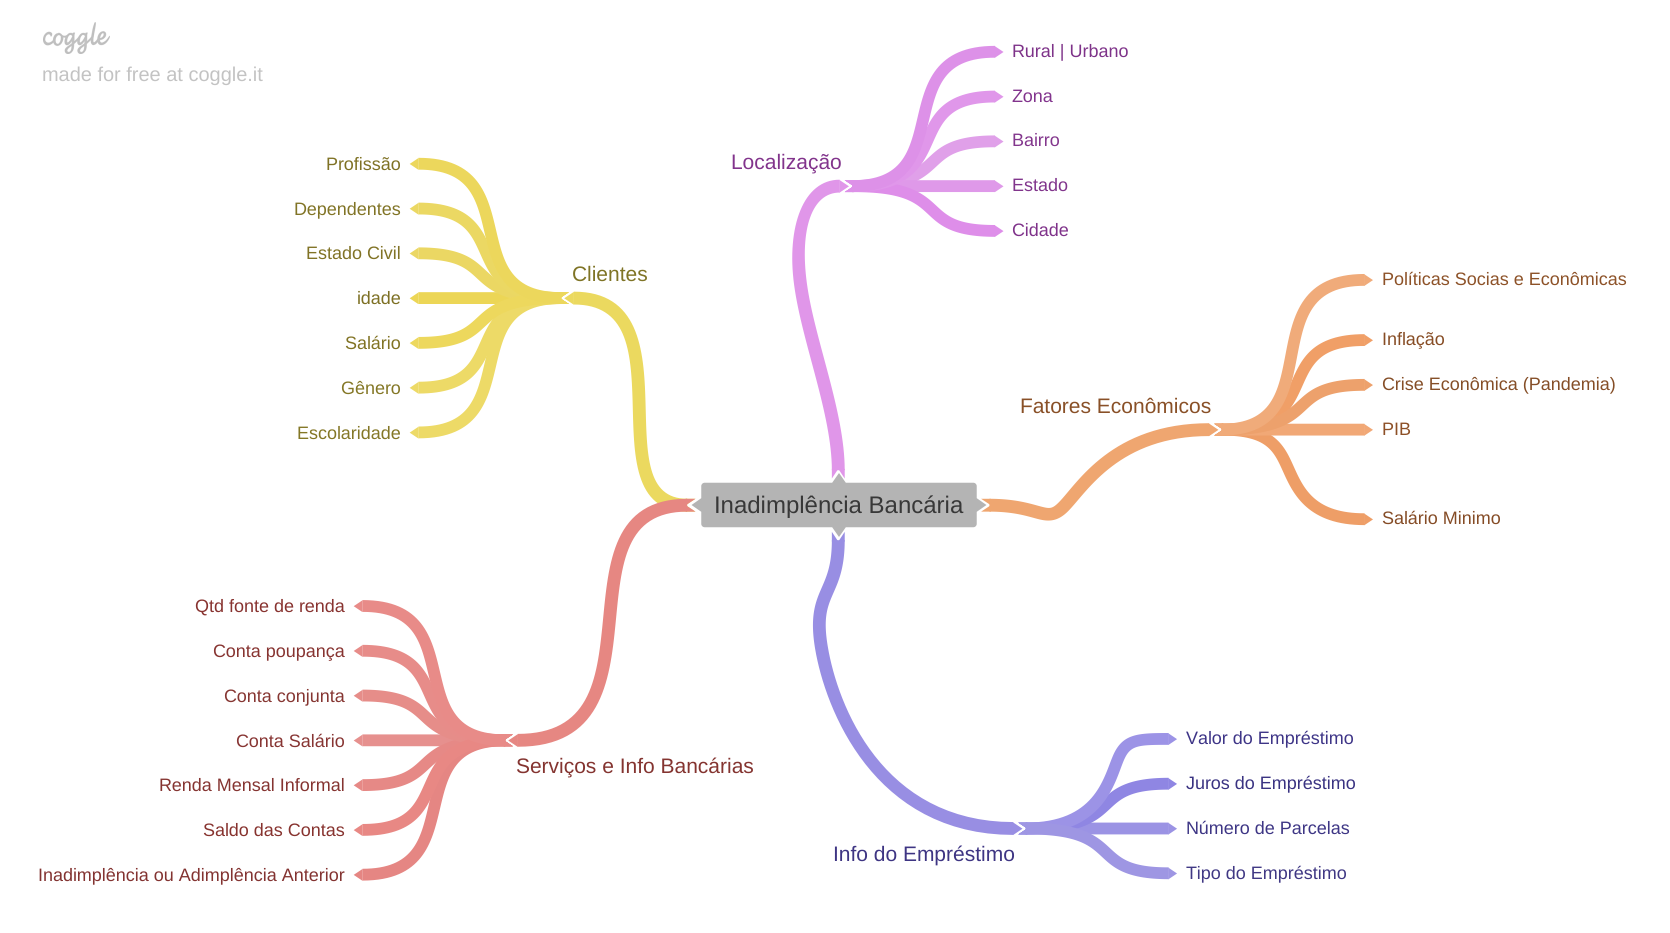

In [20]:
Image(config['imagem']['path'])

### Hipóteses de Informações dos Clientes

1. Mulheres são em média 10% mais ADIMPLENTES.
2. Clientes com Menos de 60 anos são em média 20% mais ADIMPLENTES.
3. Clientes com Dependentes são em média 15% mais ADIMPLENTES.
4. Clientes que são solteiros tem uma taxa percentual maior de INADIMPLÊNCIA que os demais.

### Hipóteses de Informações Bancárias

5. Clientes com conta salário são em média 30% mais ADIMPLENTES.
6. Clientes com conta poupança são em média 10% mais ADIMPLENTES.
7. Clientes que já passaram cheque sem fundo são em média 15% mais INADIMPLENTES.
8. Clientes que tem conta conjunta são em média 10% mais INADIMPLENTES.

### Hipóteses de Informações do Empréstimo

9. Clientes que pegaram empréstimos de mais de RS$20000 tem tendência a ser INADIMPLENTES.

### Hipóteses de Informações de Localização

10. Clientes que moram no Estado RJ E SP tem maior percentual de ADIMPLENTE
do que ES e MG.

## 3.2 Engenharia de variaveis

In [21]:
len(df3['id'].unique())

50390

In [22]:
df3.shape

(50390, 15)

In [23]:
df3['juros_porcentagem'] = df3['juros'] / df3['valor_emprestimo']

# 4.0 EDA UNIVARIADA

In [24]:
df4 = df3.copy()

## 4.1 NUMERICA

In [25]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

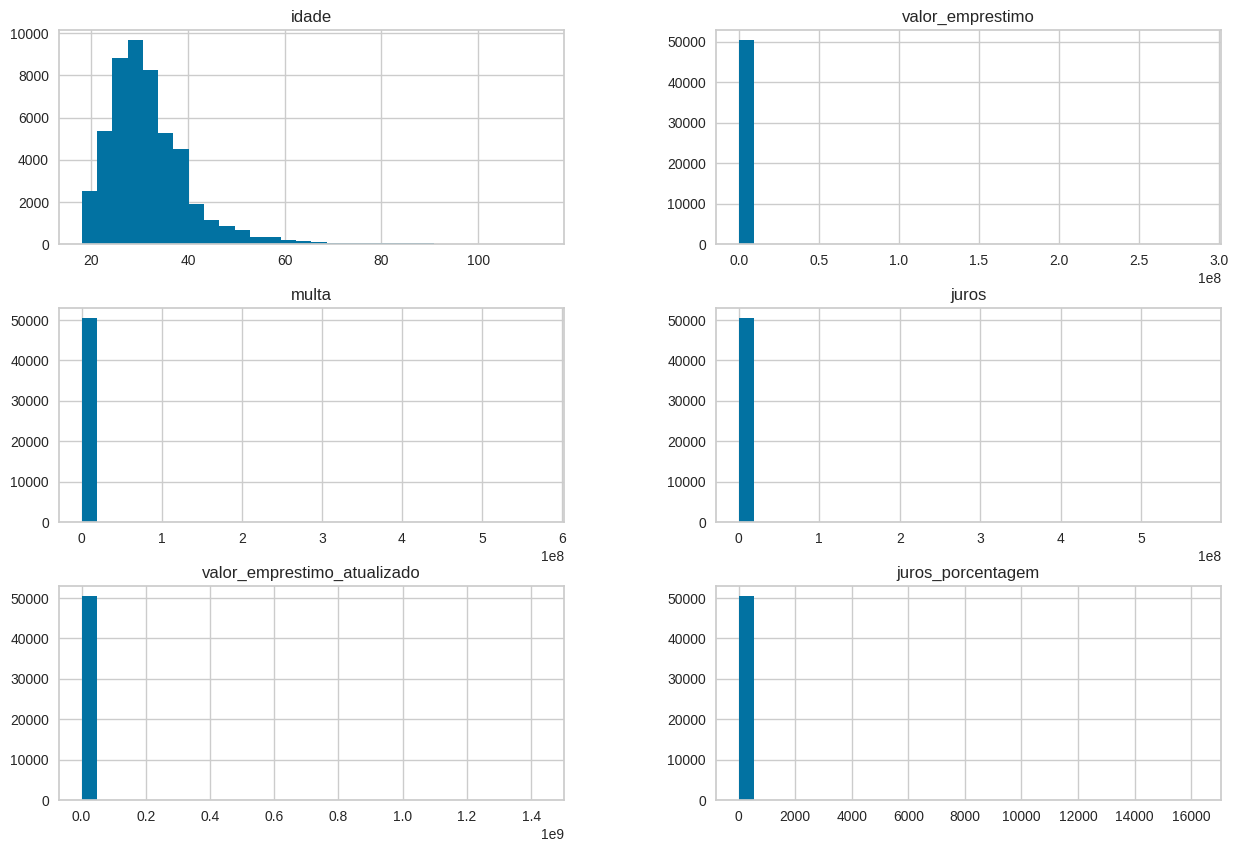

In [26]:
num_attributes.drop('id', axis='columns').hist(bins=30, figsize=(15,10));

### 4.1.1 IDADE

count    50390.000000
mean        31.724529
std          8.565117
min         18.000000
25%         26.000000
50%         30.000000
75%         35.000000
max        113.000000
Name: idade, dtype: float64


Text(0.5, 1.0, 'boxplot')

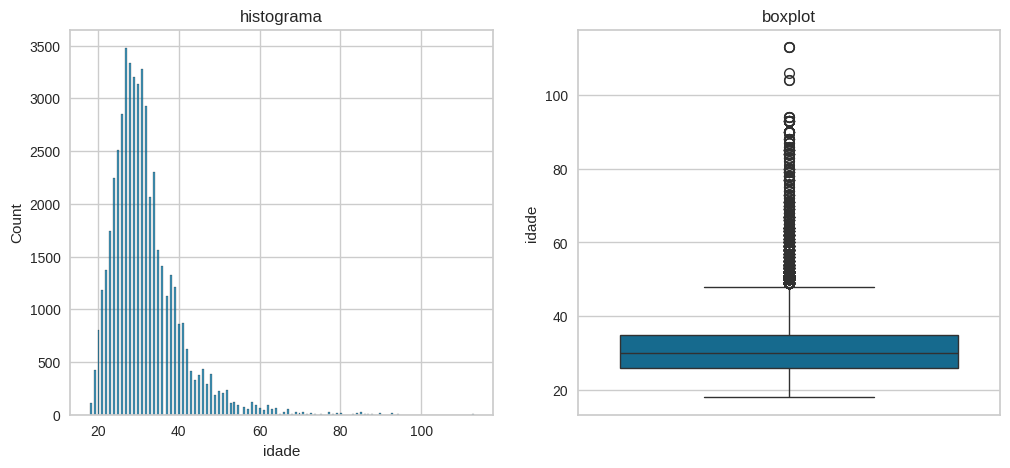

In [27]:
print(df4['idade'].describe())
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df4['idade'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['idade'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.2 VALOR DO EMPRESTIMO

count    5.039000e+04
mean     5.198887e+04
std      1.588819e+06
min      1.393000e+03
25%      1.622370e+03
50%      2.298035e+03
75%      7.172175e+03
max      2.867894e+08
Name: valor_emprestimo, dtype: float64


Text(0.5, 1.0, 'boxplot')

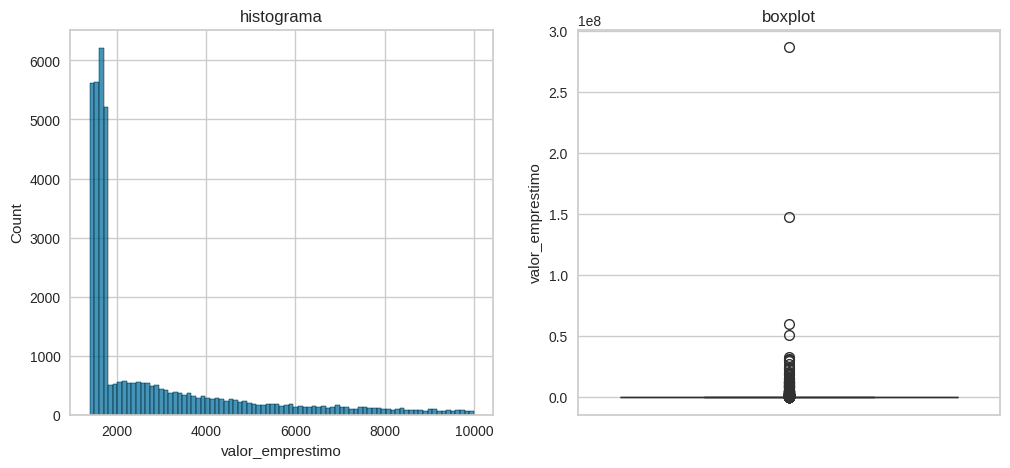

In [28]:
print(df4['valor_emprestimo'].describe())
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df4[df4['valor_emprestimo'] < 10000]['valor_emprestimo'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['valor_emprestimo'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.3 MULTA

count    5.039000e+04
mean     6.022658e+04
std      2.843941e+06
min      0.000000e+00
25%      1.325675e+02
50%      6.489650e+02
75%      3.600000e+03
max      5.737759e+08
Name: multa, dtype: float64


Text(0.5, 1.0, 'boxplot')

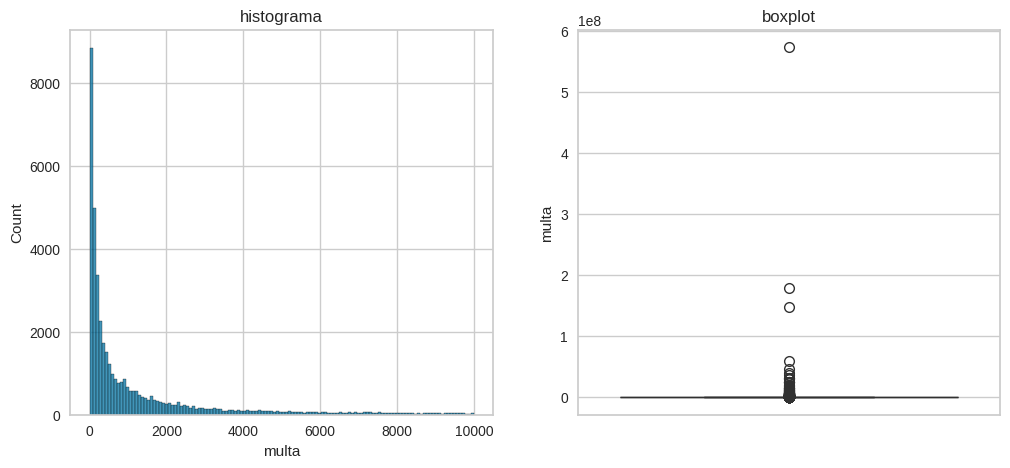

In [29]:
print(df4['multa'].describe())
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df4[df4['multa'] < 10000]['multa'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['multa'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.4 JUROS

count    5.039000e+04
mean     6.485391e+04
std      2.728170e+06
min      0.000000e+00
25%      2.742725e+02
50%      1.143320e+03
75%      5.545427e+03
max      5.703619e+08
Name: juros, dtype: float64


Text(0.5, 1.0, 'boxplot')

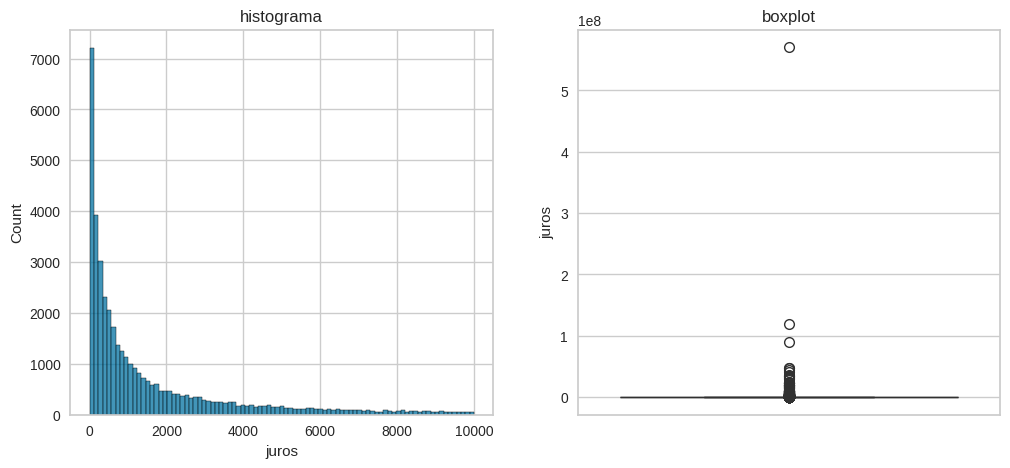

In [30]:
print(df4['juros'].describe())
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df4[df4['juros'] < 10000]['juros'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['juros'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.5 VOLOR DO EMPRESTIMO ATUALIZADO

count    5.039000e+04
mean     1.770694e+05
std      7.058364e+06
min      1.397040e+03
25%      2.842910e+03
50%      5.652695e+03
75%      1.903061e+04
max      1.430927e+09
Name: valor_emprestimo_atualizado, dtype: float64


Text(0.5, 1.0, 'boxplot')

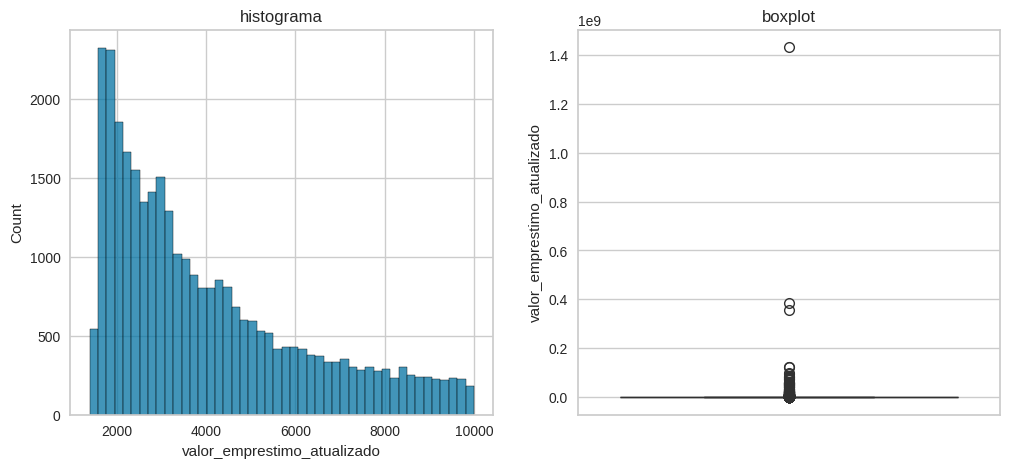

In [31]:
print(df4['valor_emprestimo_atualizado'].describe())
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df4[df4['valor_emprestimo_atualizado'] < 10000]['valor_emprestimo_atualizado'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['valor_emprestimo_atualizado'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.6 JUROS PORCENTAGEM

count    50390.000000
mean         3.029730
std        105.423189
min          0.000000
25%          0.112590
50%          0.349677
75%          0.848668
max      16248.020882
Name: juros_porcentagem, dtype: float64


Text(0.5, 1.0, 'boxplot')

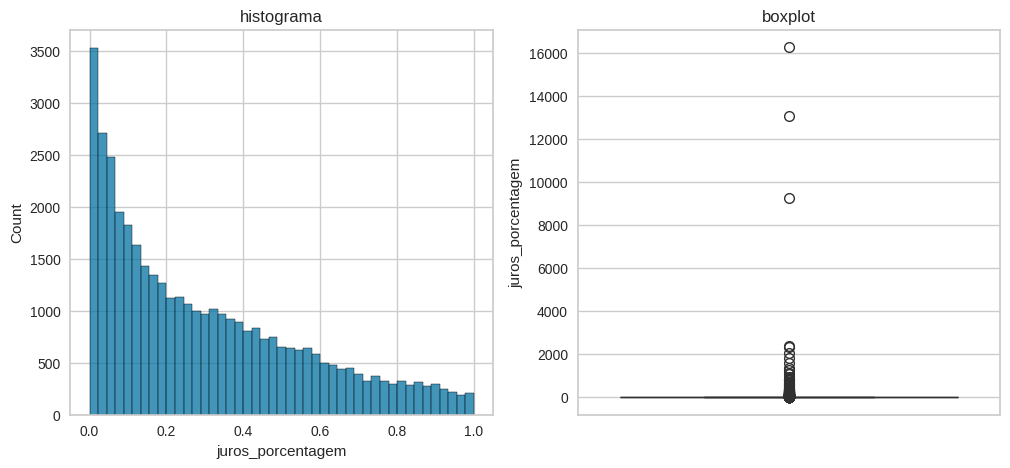

In [32]:
print(df4['juros_porcentagem'].describe())
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df4[df4['juros_porcentagem'] < 1]['juros_porcentagem'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['juros_porcentagem'], ax=axes[1])
axes[1].set_title('boxplot')

## 4.2 CATEGORICAS

### 4.2.1 DEPENDENTES

dependentes
N    0.639968
S    0.360032
Name: proportion, dtype: float64


<Axes: xlabel='dependentes', ylabel='count'>

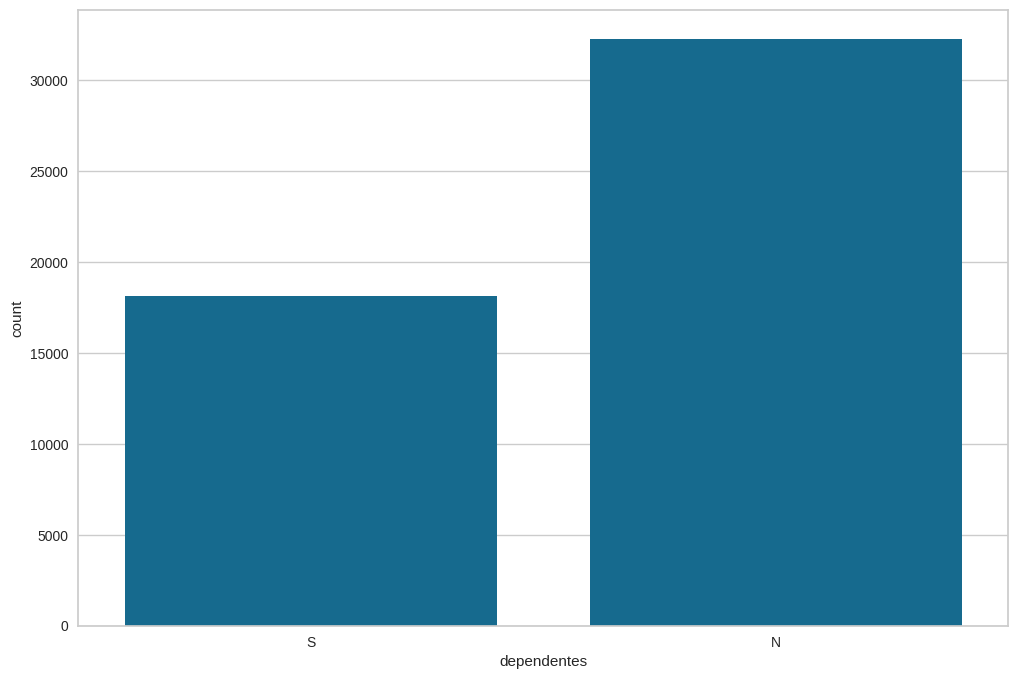

In [33]:
print(df4['dependentes'].value_counts(normalize=True))
sns.countplot(x='dependentes', data=df4)

### 4.2.2 ESTADO CIVIL

estado_civil
solteiro                                  0.547053
casado(a) com comunhao parcial de bens    0.263604
casado(a) com comunhao de bens            0.154098
casado(a) com separacao de bens           0.030959
separado judicialmente                    0.001469
divorciado                                0.001330
viuvo(a)                                  0.000814
outros                                    0.000675
Name: proportion, dtype: float64


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'solteiro'),
  Text(1, 0, 'casado(a) com comunhao de bens'),
  Text(2, 0, 'casado(a) com comunhao parcial de bens'),
  Text(3, 0, 'casado(a) com separacao de bens'),
  Text(4, 0, 'divorciado'),
  Text(5, 0, 'separado judicialmente'),
  Text(6, 0, 'viuvo(a)'),
  Text(7, 0, 'outros')])

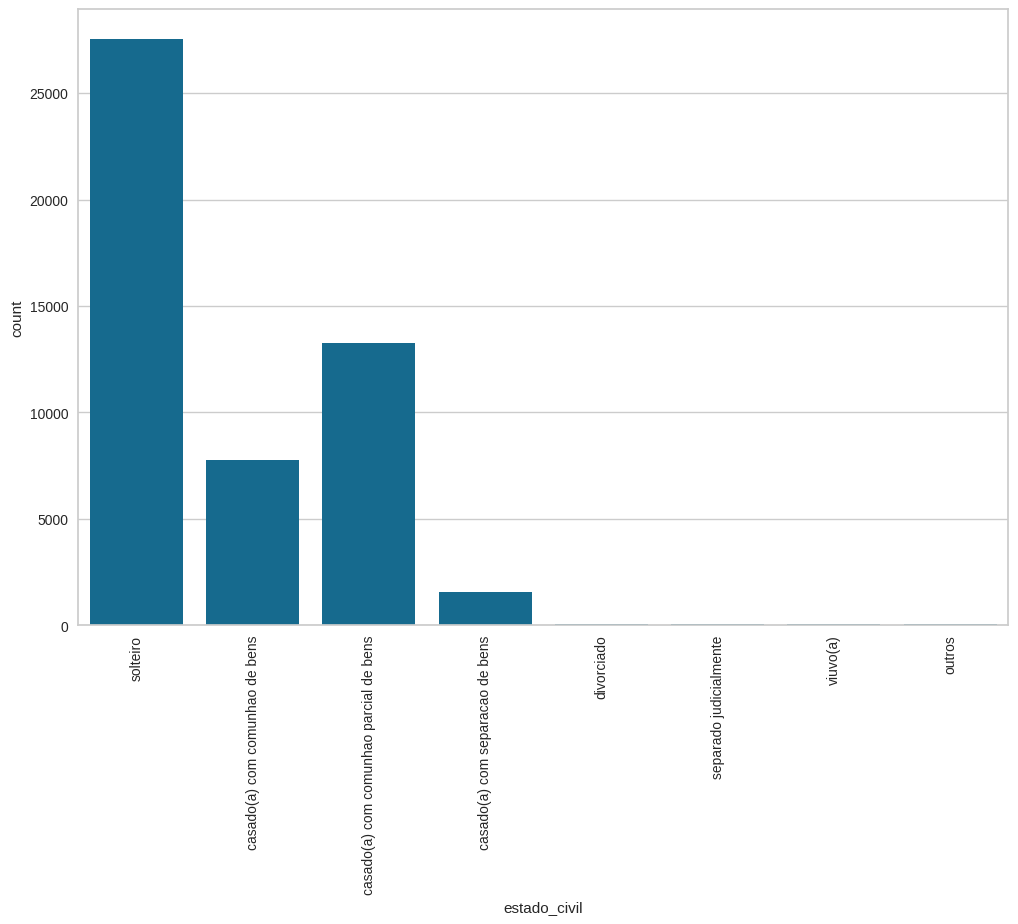

In [34]:
print(df4['estado_civil'].value_counts(normalize=True))
sns.countplot(x='estado_civil', data=df4)
plt.xticks(rotation= 90)

### 4.2.3 CONTA POUPANCA

conta_poupanca
S    0.847986
N    0.152014
Name: proportion, dtype: float64


<Axes: xlabel='conta_poupanca', ylabel='count'>

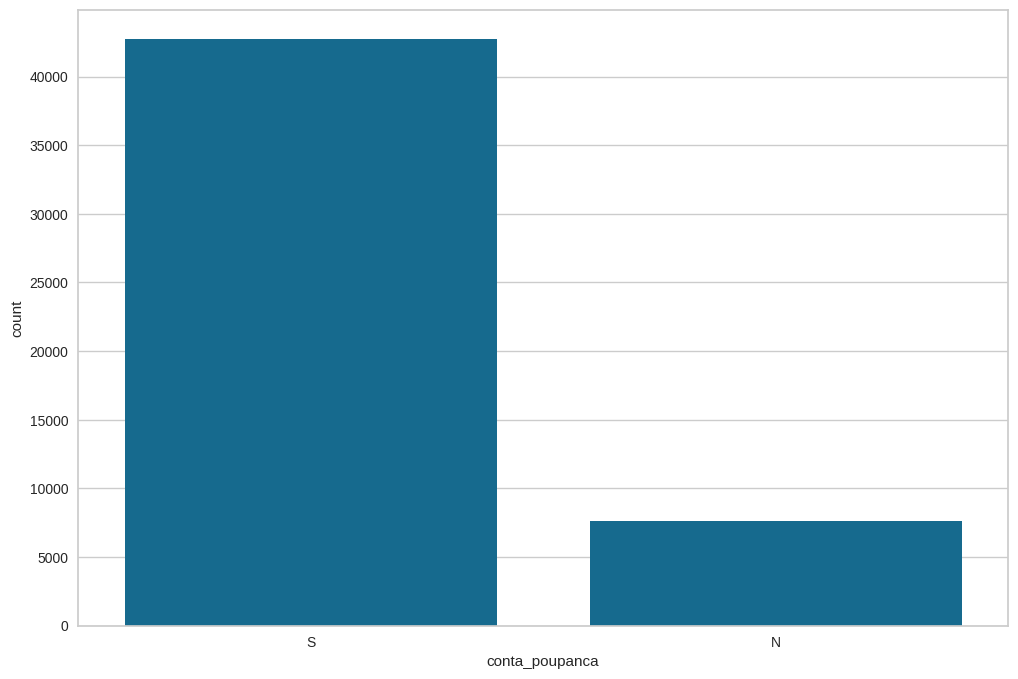

In [35]:
print(df4['conta_poupanca'].value_counts(normalize=True))
sns.countplot(x='conta_poupanca', data=df4)

### 4.2.4 CONTA SALARIO

conta_salario
N    0.976603
S    0.023397
Name: proportion, dtype: float64


<Axes: xlabel='conta_salario', ylabel='count'>

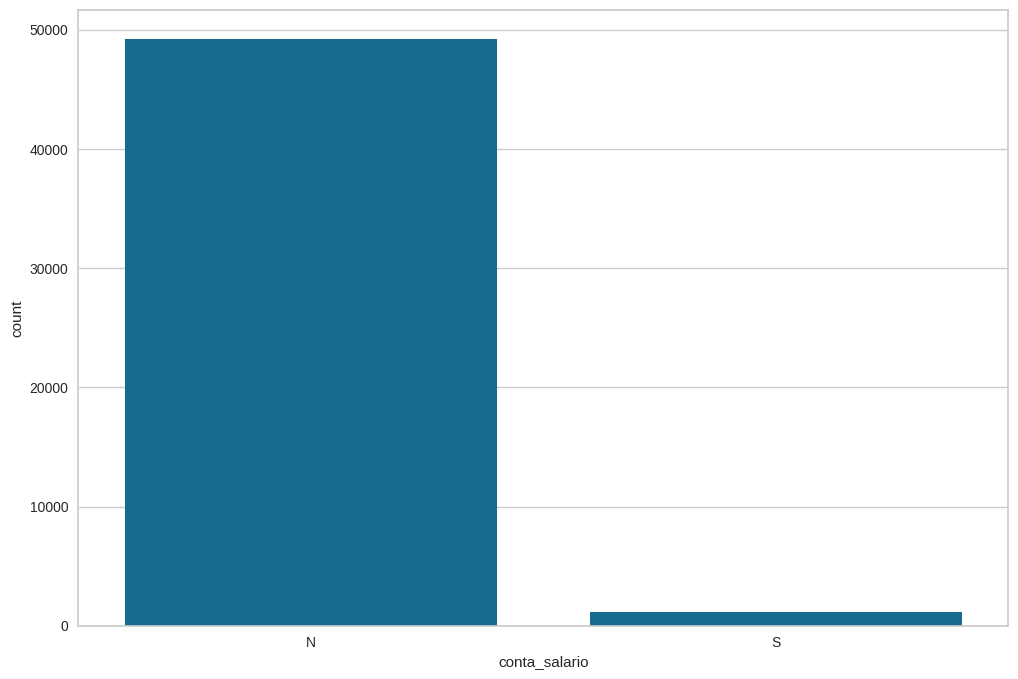

In [36]:
print(df4['conta_salario'].value_counts(normalize=True))
sns.countplot(x='conta_salario', data=df4)

### 4.2.5 CHEQUE SEM FUNDO

cheque_sem_fundo
S    0.769974
N    0.230026
Name: proportion, dtype: float64


<Axes: xlabel='cheque_sem_fundo', ylabel='count'>

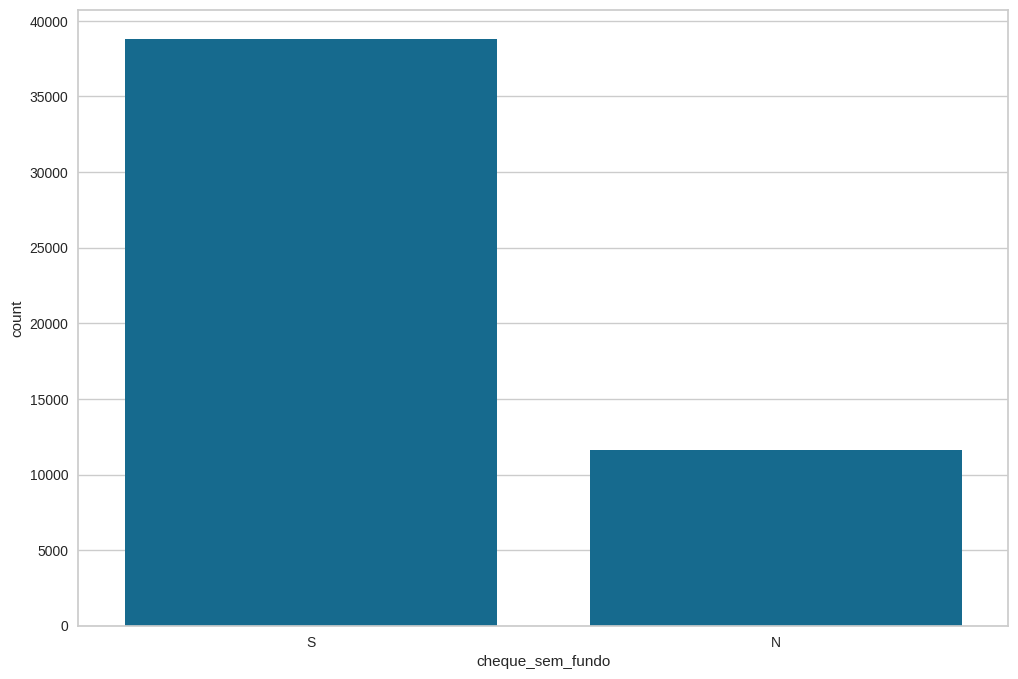

In [37]:
print(df4['cheque_sem_fundo'].value_counts(normalize=True))
sns.countplot(x='cheque_sem_fundo', data=df4)

### 4.2.6 CONTA CONJUNTA

conta_conjunta
N    0.958285
S    0.041715
Name: proportion, dtype: float64


<Axes: xlabel='conta_conjunta', ylabel='count'>

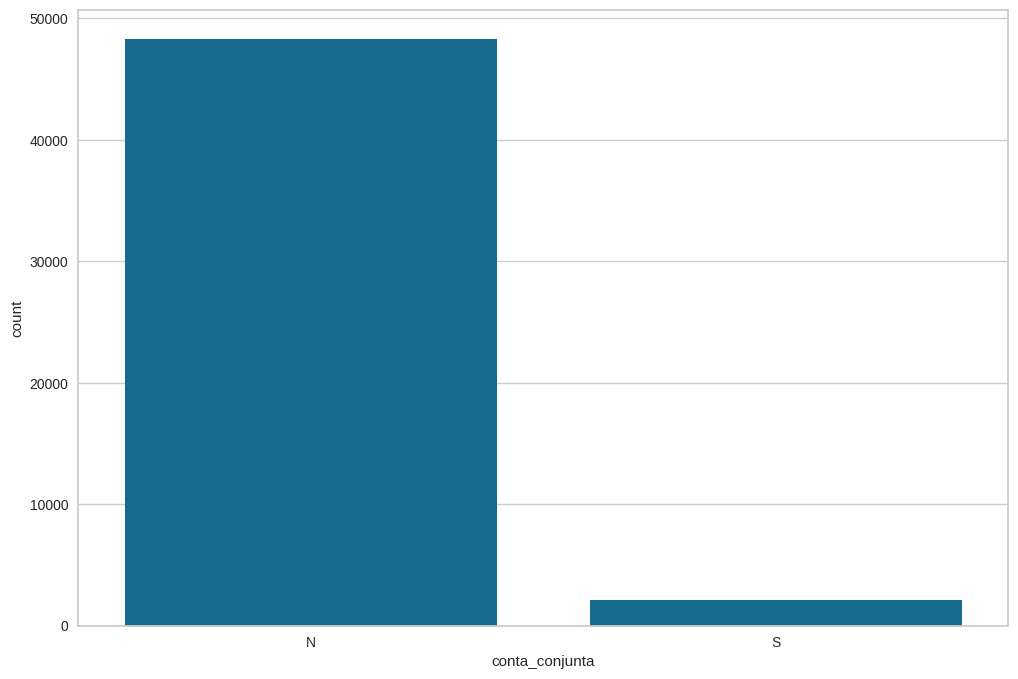

In [38]:
print(df4['conta_conjunta'].value_counts(normalize=True))
sns.countplot(x='conta_conjunta', data=df4)

### 4.2.7 PAGO

pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64


<Axes: xlabel='pago', ylabel='count'>

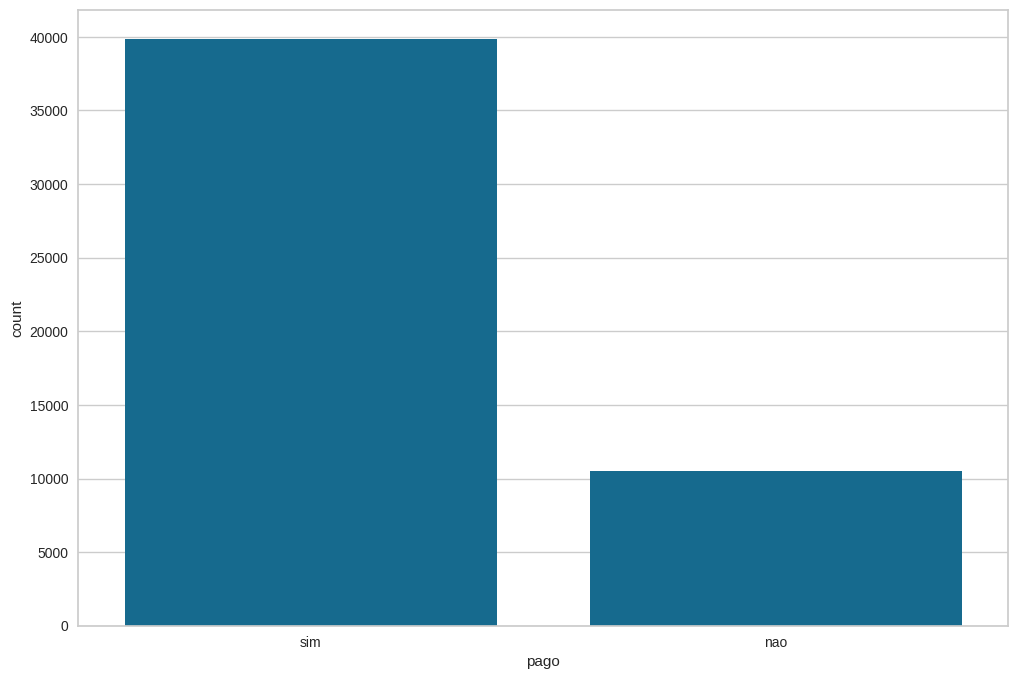

In [39]:
print(df4['pago'].value_counts(normalize=True))
sns.countplot(x='pago', data=df4)

### 4.2.8 GENERO

genero
masculino    0.501667
feminino     0.498333
Name: proportion, dtype: float64


<Axes: xlabel='genero', ylabel='count'>

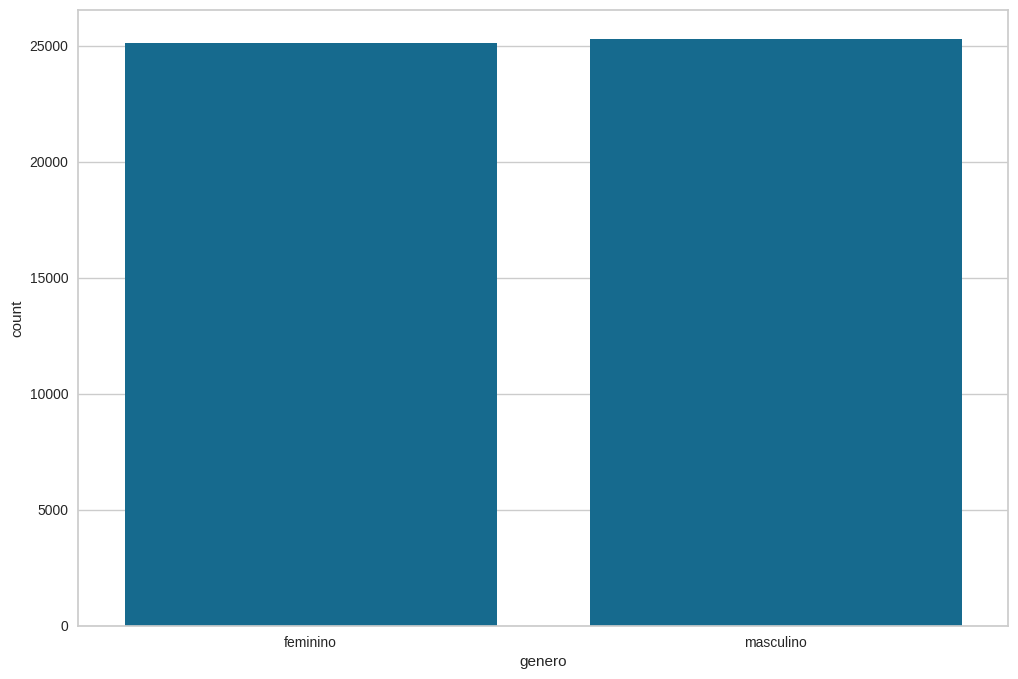

In [40]:
print(df4['genero'].value_counts(normalize=True))
sns.countplot(x='genero', data=df4)

### 4.2.9 ESTADO

estado
minas gerais      0.251340
sao paulo         0.250189
espirito santo    0.249772
rio de janeiro    0.248700
Name: proportion, dtype: float64


<Axes: xlabel='estado', ylabel='count'>

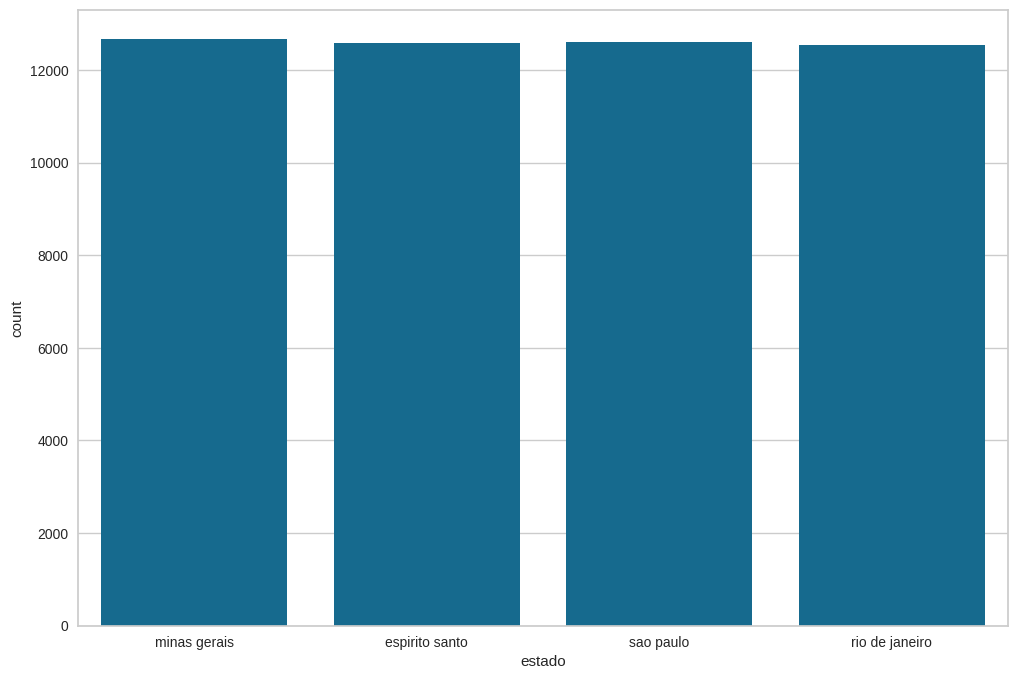

In [41]:
print(df4['estado'].value_counts(normalize=True))
sns.countplot(x='estado', data=df4)

# 5.0 CLEAN OUTLIERS

In [42]:
df5 = df4.copy()

In [43]:
df5['pago'].value_counts(normalize=True)

pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64

In [44]:
len(df5[df5['valor_emprestimo'] > 5_000_000]) /len(df5)

0.0015479261758285373

In [45]:
len(df5[df5['juros_porcentagem'] < 0.01]) / len(df5)

0.03464973208970034

In [46]:
df5 = df5[df5['valor_emprestimo'] < 5_000_000].copy()
df5 = df5[df5['juros_porcentagem'] > 0.01].copy()


In [47]:
df5['pago'].value_counts(normalize=True)

pago
sim    0.787073
nao    0.212927
Name: proportion, dtype: float64

In [48]:
df5.to_csv(config['data']['trusted_path'], index=False)

# 6.0 EDA BIVARIADA

In [49]:
df6 = pd.read_csv(config['data']['trusted_path'])

## 6.1 GENERO Mulheres são em média 10% mais ADIMPLENTES.(FALSO)

pago        nao    sim
genero                
feminino   5220  18992
masculino  5121  19233

pago            nao       sim
genero                       
feminino   0.215596  0.784404
masculino  0.210273  0.789727

<Axes: xlabel='genero'>

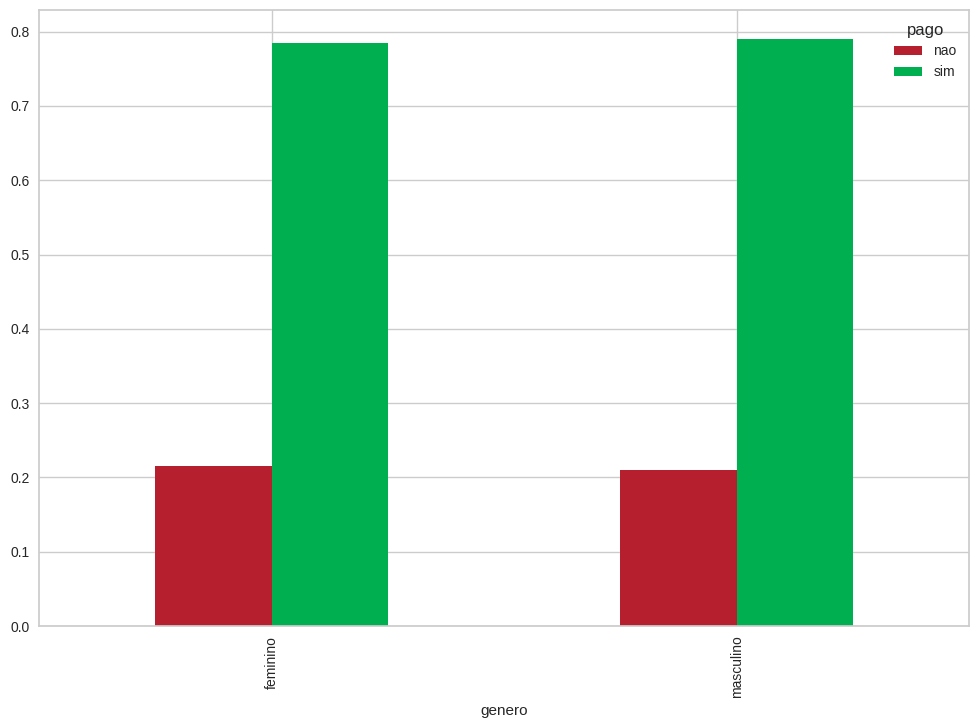

In [50]:
display(pd.crosstab(df6['genero'], df6['pago']))

display(pd.crosstab(df6['genero'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['genero'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.2 IDADE Clientes com Menos de 60 anos são em média 20% mais ADIMPLENTES.(FALSO)

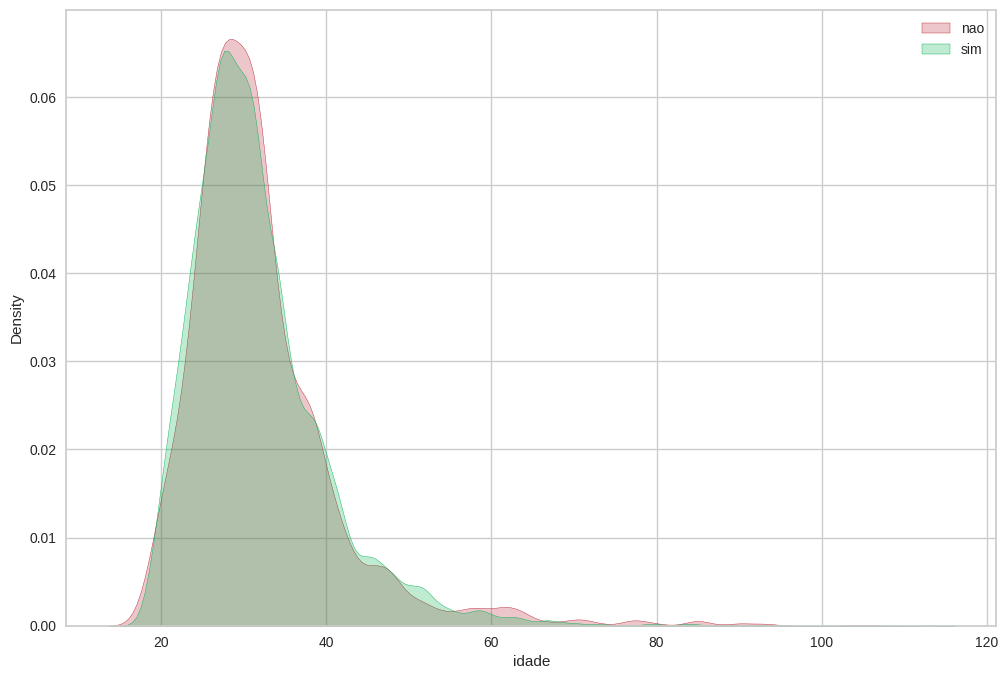

In [51]:
sns.kdeplot(df6[df6['pago'] == 'nao']['idade'], label= 'nao', fill=True, color='#b61f2e')
sns.kdeplot(df6[df6['pago'] == 'sim']['idade'], label= 'sim', fill=True, color='#00b050')
plt.legend();

pago          nao    sim
idade_bined             
(18, 38]     8715  32015
(38, 58]     1345   5649
(58, 78]      193    408
(78, 98]       46     80

pago              nao       sim
idade_bined                    
(18, 38]     0.213970  0.786030
(38, 58]     0.192308  0.807692
(58, 78]     0.321131  0.678869
(78, 98]     0.365079  0.634921

<Axes: xlabel='idade_bined'>

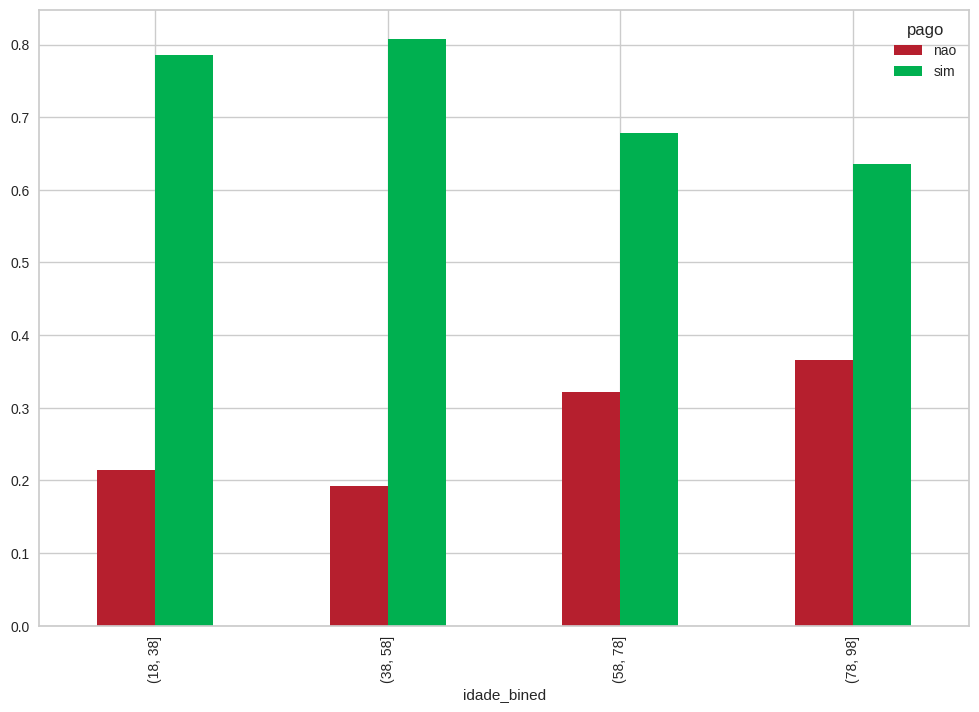

In [52]:
bins = list(np.arange(18,113,20))
aux = df6.copy()

aux['idade_bined'] = pd.cut(aux['idade'],bins = bins)

display(pd.crosstab(aux['idade_bined'], aux['pago']))

display(pd.crosstab(aux['idade_bined'], aux['pago'], normalize='index'))

display(pd.crosstab(aux['idade_bined'], aux['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.3 DEPENDENTES Clientes com Dependentes são em média 15% mais ADIMPLENTES.(VERDADEIRA)

pago          nao    sim
dependentes             
N            8661  22568
S            1680  15657

pago              nao       sim
dependentes                    
N            0.277338  0.722662
S            0.096903  0.903097

<Axes: xlabel='dependentes'>

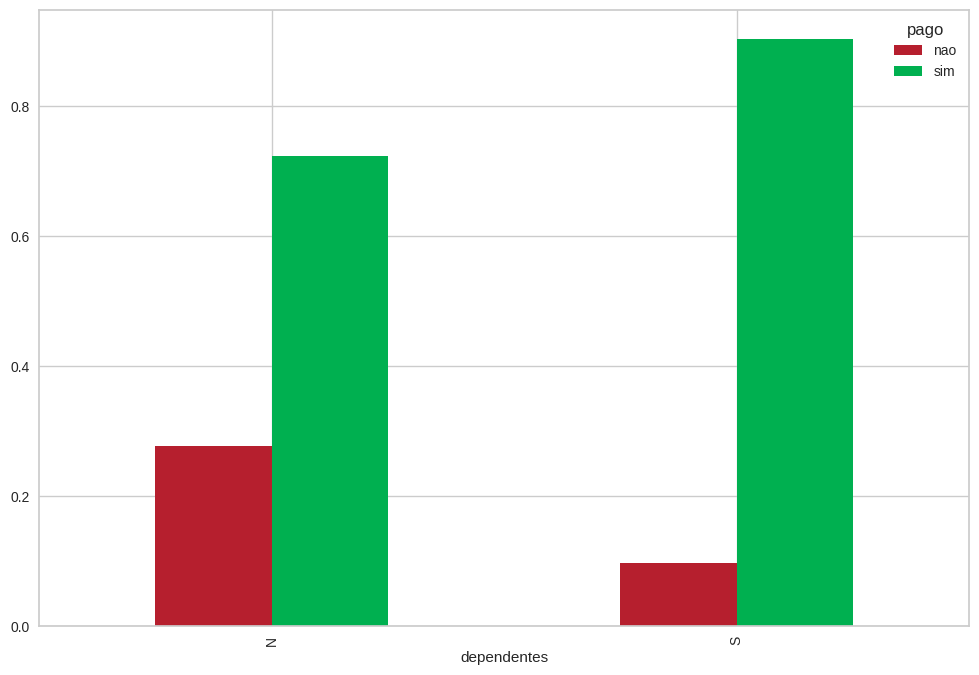

In [53]:
display(pd.crosstab(df6['dependentes'], df6['pago']))

display(pd.crosstab(df6['dependentes'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['dependentes'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.4 ESTADO CIVIL Clientes que são solteiros tem uma taxa percentual maior de INADIMPLÊNCIA que os demais. (FALSO)

pago                                     nao    sim
estado_civil                                       
casado(a) com comunhao de bens          1790   5825
casado(a) com comunhao parcial de bens  5112   8003
casado(a) com separacao de bens          401   1105
divorciado                                 6     56
outros                                    27      7
separado judicialmente                    33     41
solteiro                                2949  23170
viuvo(a)                                  23     18

pago                                         nao       sim
estado_civil                                              
casado(a) com comunhao de bens          0.235062  0.764938
casado(a) com comunhao parcial de bens  0.389783  0.610217
casado(a) com separacao de bens         0.266268  0.733732
divorciado                              0.096774  0.903226
outros                                  0.794118  0.205882
separado judicialmente                  0.445946  0.554054
solteiro                                0.112906  0.887094
viuvo(a)                                0.560976  0.439024

<Axes: xlabel='estado_civil'>

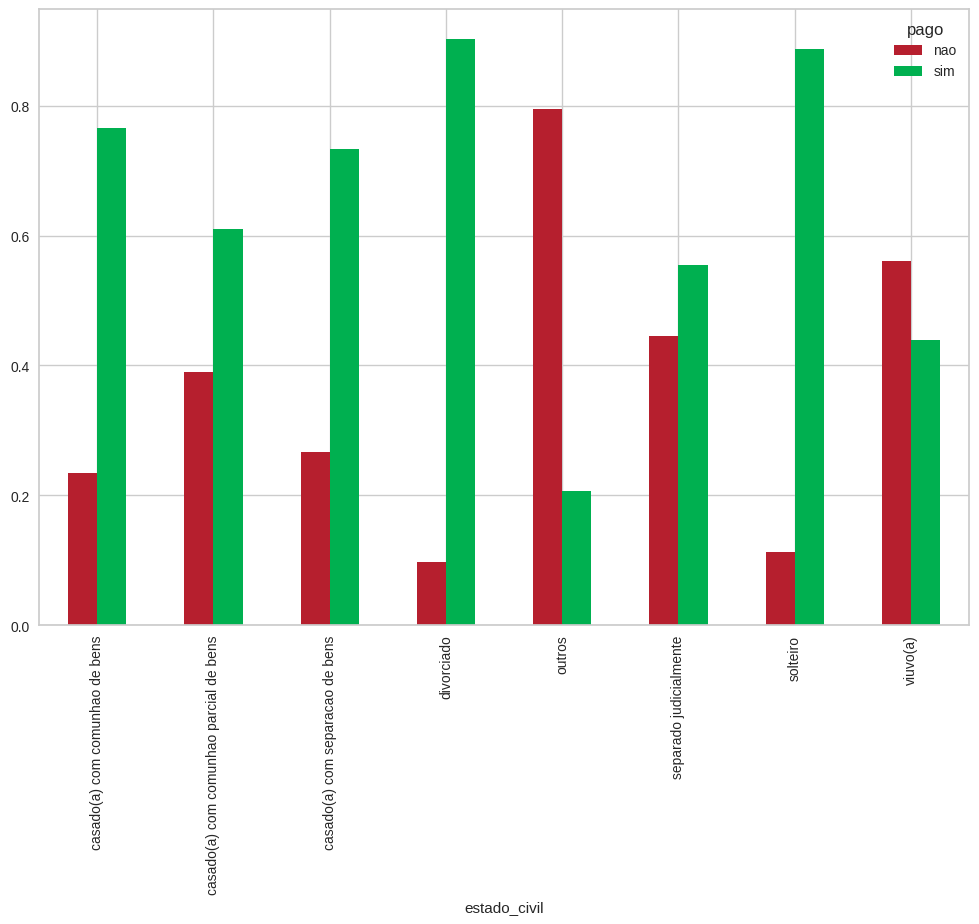

In [54]:
display(pd.crosstab(df6['estado_civil'], df6['pago']))

display(pd.crosstab(df6['estado_civil'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['estado_civil'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.5 CONTA SALARIO Clientes com conta salário são em média 30% mais ADIMPLENTES.(FALSO)

pago             nao    sim
conta_salario              
N              10030  37403
S                311    822

pago                nao       sim
conta_salario                    
N              0.211456  0.788544
S              0.274492  0.725508

<Axes: xlabel='conta_salario'>

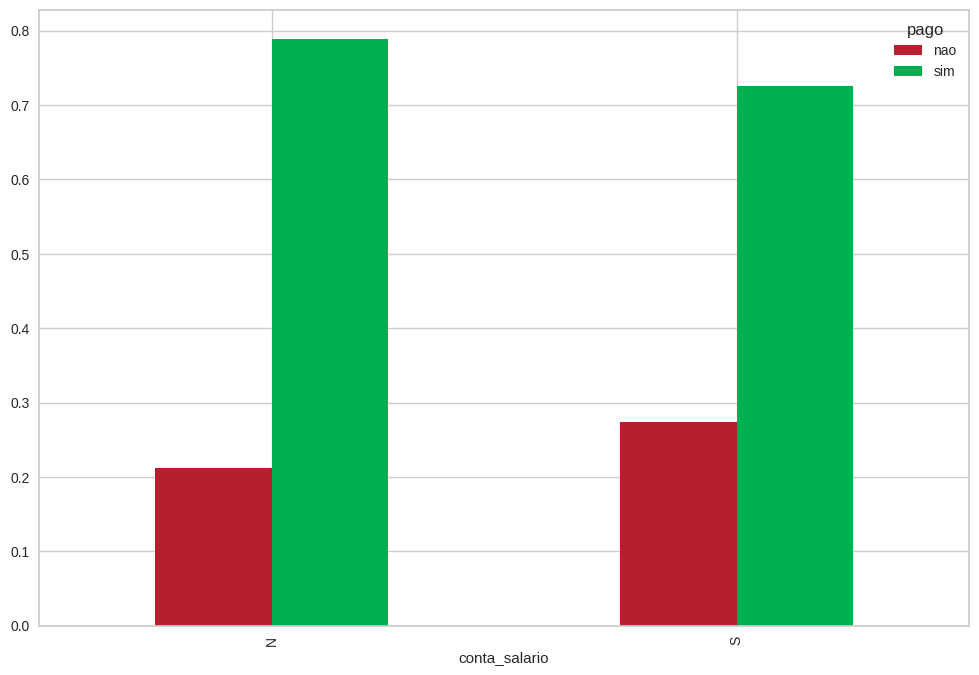

In [55]:
display(pd.crosstab(df6['conta_salario'], df6['pago']))

display(pd.crosstab(df6['conta_salario'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['conta_salario'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.6 CONTA POUPANCA Clientes com conta poupança são em média 10% mais ADIMPLENTES.(FALSO)

pago             nao    sim
conta_poupanca             
N               1847   5648
S               8494  32577

pago                 nao       sim
conta_poupanca                    
N               0.246431  0.753569
S               0.206813  0.793187

<Axes: xlabel='conta_poupanca'>

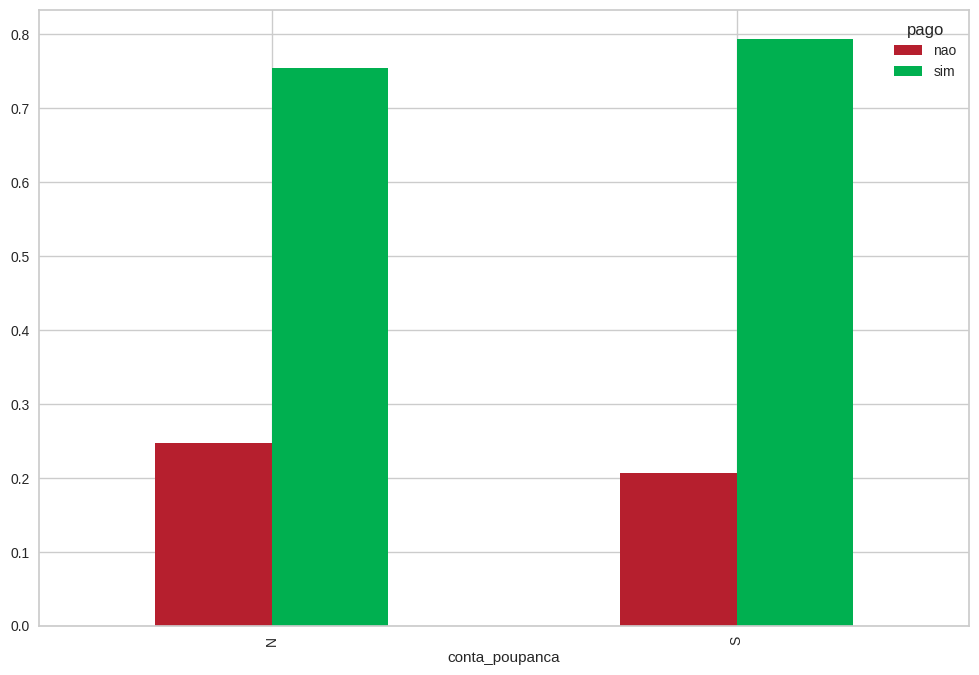

In [56]:
display(pd.crosstab(df6['conta_poupanca'], df6['pago']))

display(pd.crosstab(df6['conta_poupanca'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['conta_poupanca'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.7 CHEQUE SEM FUNDO Clientes que já passaram cheque sem fundo são em média 15% mais INADIMPLENTES.(VERDADEIRO)

pago               nao    sim
cheque_sem_fundo             
N                 1051   9958
S                 9290  28267

pago                   nao       sim
cheque_sem_fundo                    
N                 0.095467  0.904533
S                 0.247357  0.752643

<Axes: xlabel='cheque_sem_fundo'>

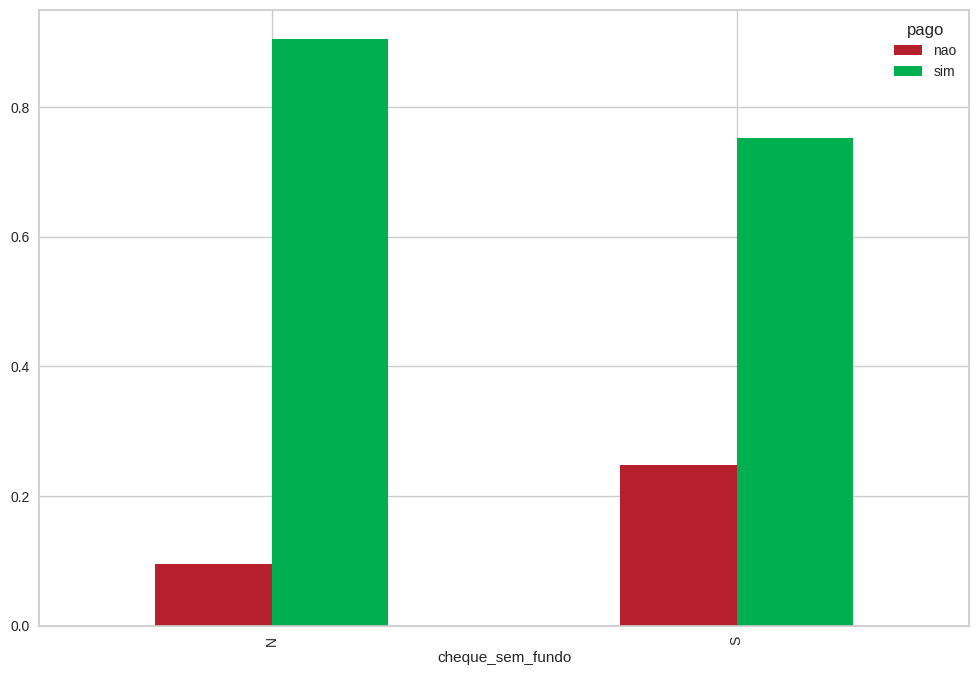

In [57]:
display(pd.crosstab(df6['cheque_sem_fundo'], df6['pago']))

display(pd.crosstab(df6['cheque_sem_fundo'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['cheque_sem_fundo'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.8 CONTA CONJUNTA Clientes que tem conta conjunta são em média 10% mais INADIMPLENTES. (FALSO)

pago              nao    sim
conta_conjunta              
N               10085  36489
S                 256   1736

pago                 nao       sim
conta_conjunta                    
N               0.216537  0.783463
S               0.128514  0.871486

<Axes: xlabel='conta_conjunta'>

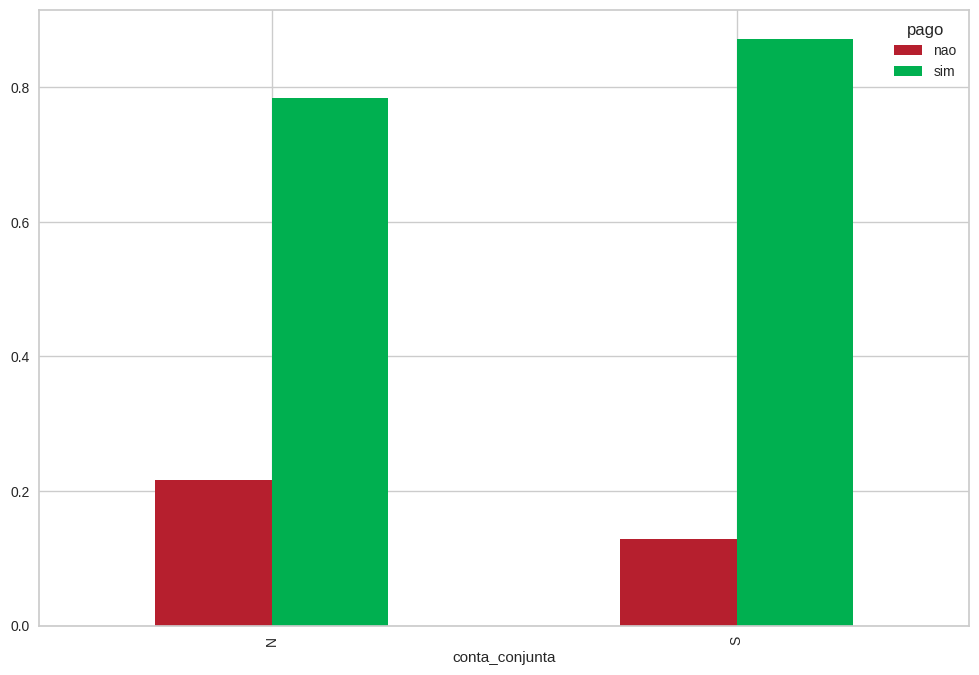

In [58]:
display(pd.crosstab(df6['conta_conjunta'], df6['pago']))

display(pd.crosstab(df6['conta_conjunta'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['conta_conjunta'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


## 6.9 EMPRESTIMO Clientes que pegaram empréstimos de mais de RS$20000 tem tendência a ser INADIMPLENTES.(VERDADEIRA)

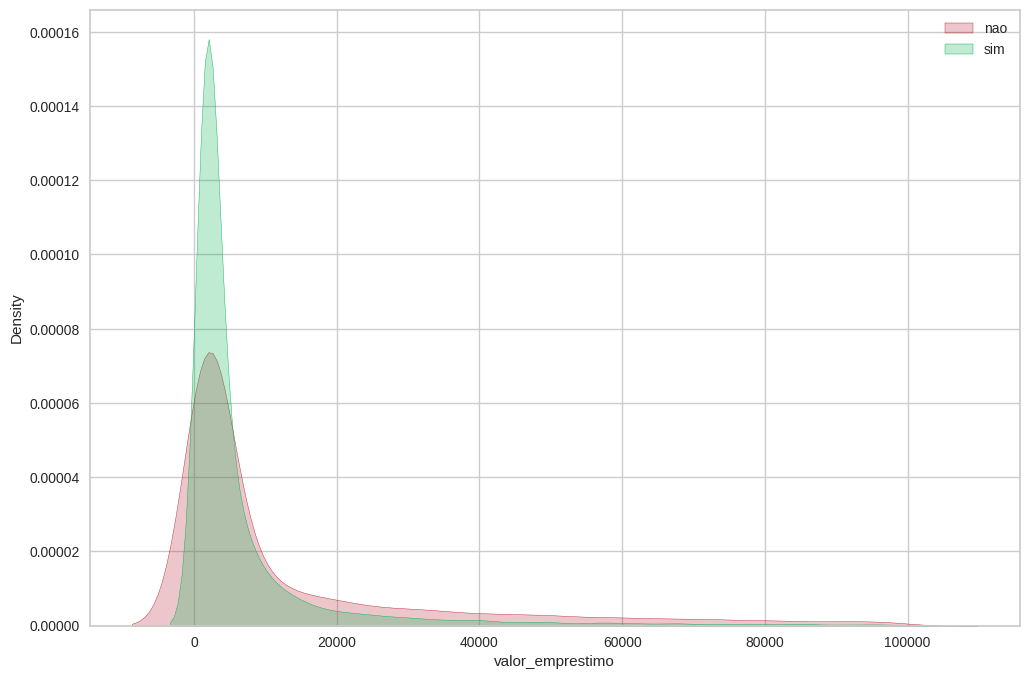

In [59]:
aux = df6[df6['valor_emprestimo'] < 100_000]

sns.kdeplot(aux[aux['pago'] == 'nao']['valor_emprestimo'], label= 'nao', fill=True, color='#b61f2e')
sns.kdeplot(aux[aux['pago'] == 'sim']['valor_emprestimo'], label= 'sim', fill=True, color='#00b050')
plt.legend();

## 6.10 ESTADO Clientes que moram no Estado RJ E SP tem maior percentual de ADIMPLENTE do que ES e MG.(FALSO)

pago             nao   sim
estado                    
espirito santo  2597  9550
minas gerais    2590  9612
rio de janeiro  2592  9483
sao paulo       2562  9580

pago                 nao       sim
estado                            
espirito santo  0.213798  0.786202
minas gerais    0.212260  0.787740
rio de janeiro  0.214658  0.785342
sao paulo       0.211003  0.788997

<Axes: xlabel='estado'>

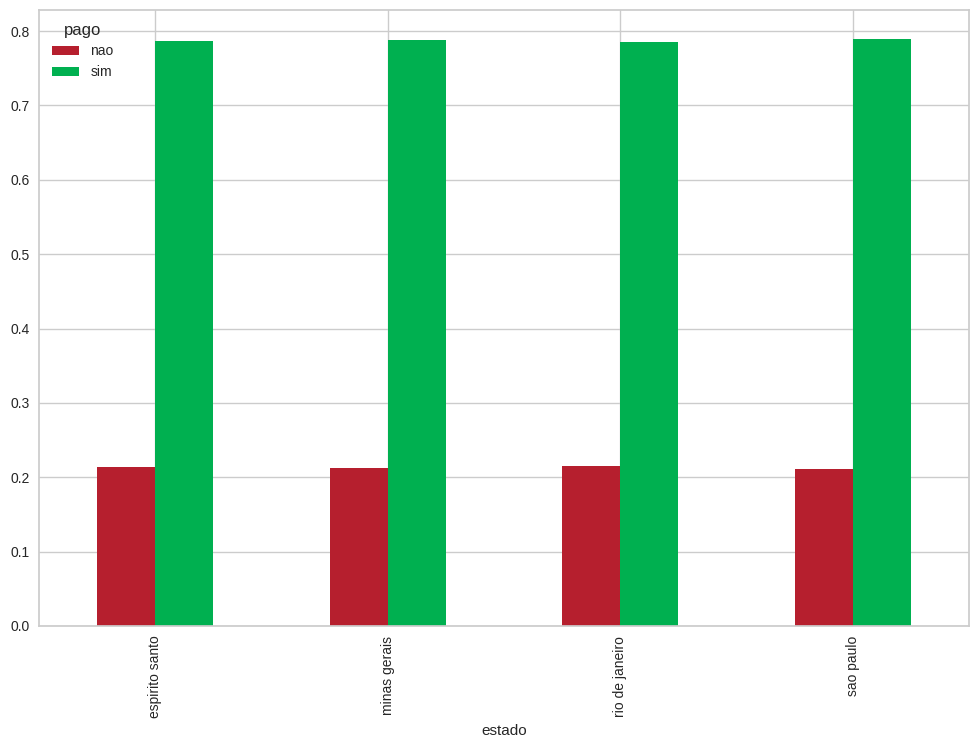

In [60]:
display(pd.crosstab(df6['estado'], df6['pago']))

display(pd.crosstab(df6['estado'], df6['pago'], normalize='index'))

display(pd.crosstab(df6['estado'], df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim':'#00b050'}))


# 7.0 ANALISE DE CORRELAÇÃO

In [61]:
df7 = df6.copy()

## 7.1 NUMERICAS X NUMERICAS

In [62]:
num_attributes = df7.select_dtypes(include=['int64', 'float64'])
num_attributes = num_attributes.drop('id', axis='columns')

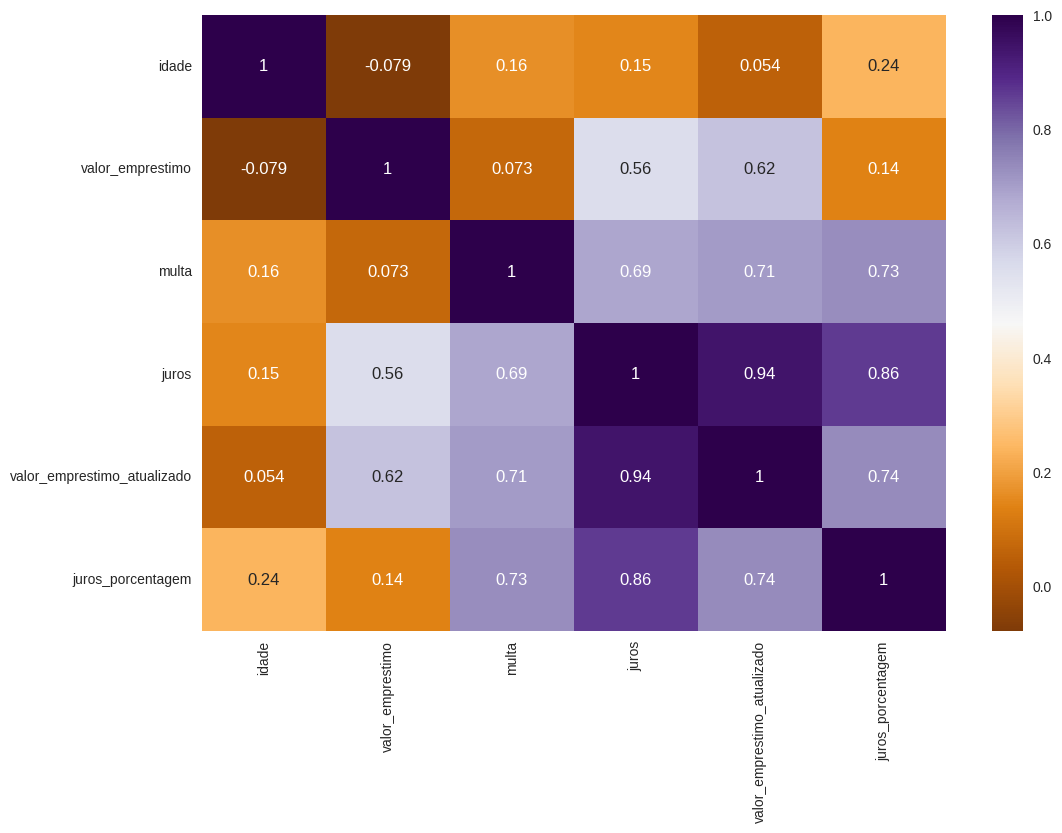

In [63]:
sns.heatmap(num_attributes.corr('spearman'), cmap='PuOr', annot=True);

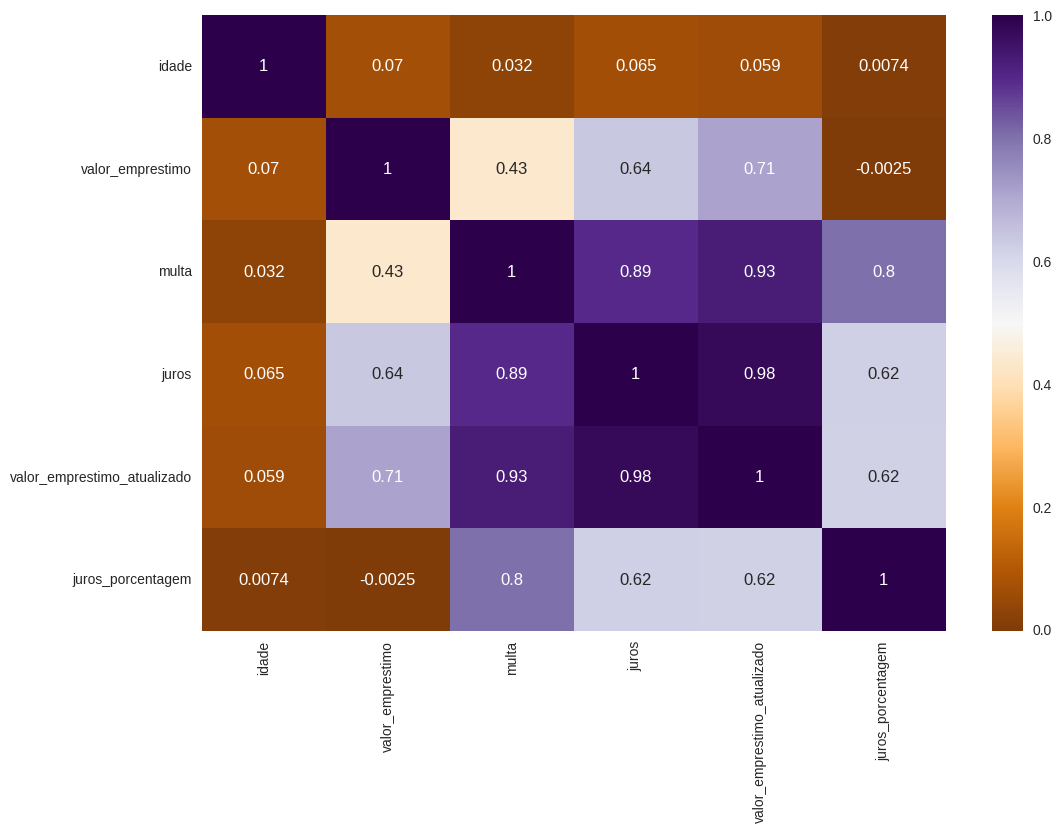

In [64]:
sns.heatmap(num_attributes.corr('pearson'), cmap='PuOr', annot=True);

## 7.2 CATEGORICAS X CATEGORICAS

In [65]:
cat_attributes = df7.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}

for i in range(len(cat_attributes_list)):
    corr_list = []

    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]

        # correlation
        confusion_matrix = pd.crosstab(cat_attributes[ref], cat_attributes[feat])
        corr = cramers_v(confusion_matrix.values)

        #append a list
        corr_list.append(corr)

    corr_dict[ref] = corr_list


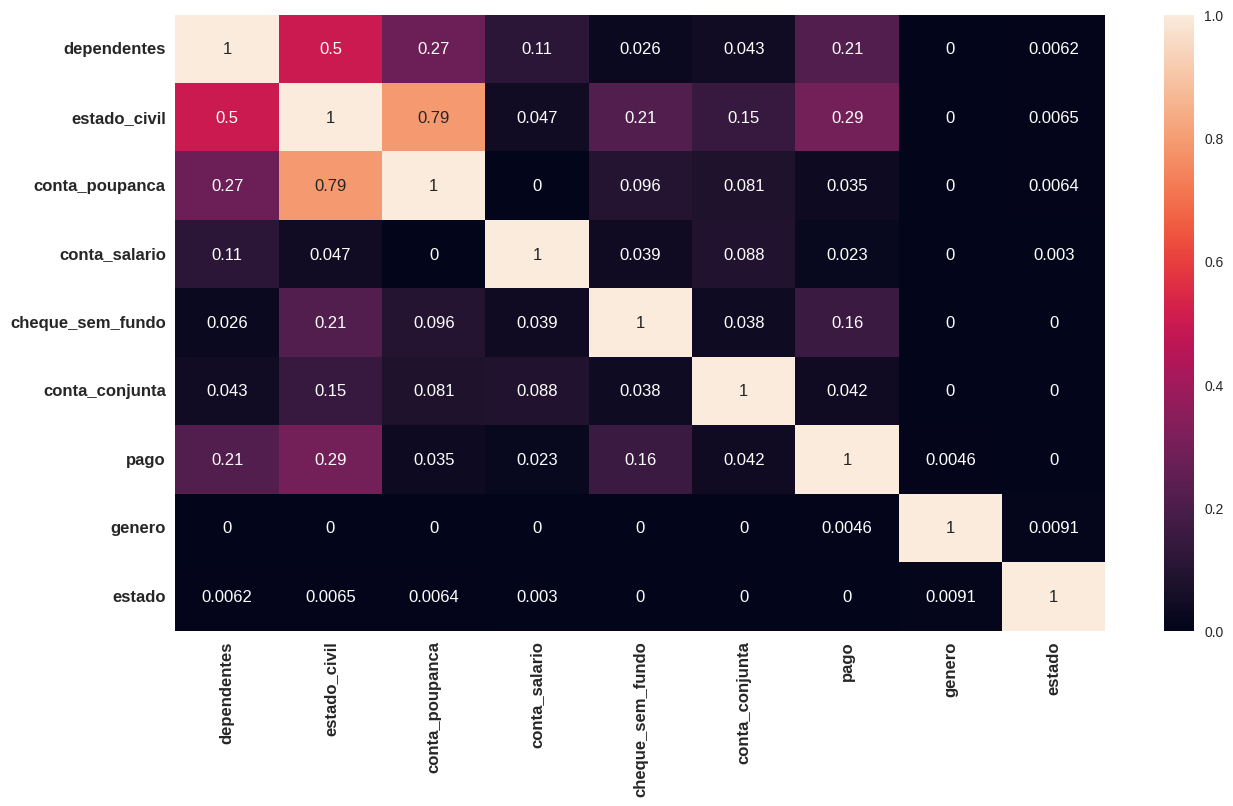

In [66]:
d = pd.DataFrame(corr_dict)

d = d.set_index(d.columns)

plt.figure(figsize=(15,8))
sns.heatmap(d, annot=True)

plt.xticks(rotation=90, fontsize=12, weight='bold')
plt.yticks(rotation=360, fontsize=12, weight='bold');

# 8.0 SPLIT TREINO TESTE E VALIDACAO

In [67]:
df8 = pd.read_csv(config['data']['trusted_path'])

In [68]:
def label_pago(x):
    if x == 'sim':
        return 0
    else:
        return 1

In [69]:
df8['pago'] = df8['pago'].apply(label_pago)

In [70]:
train_set, test_set = train_test_split(df8, test_size=config['split']['teste_size'], random_state=config['split']['seed'], stratify=df8['pago'])

In [71]:
print(len(train_set))
print(len(test_set))

38852
9714


In [72]:
train_set.to_csv(config['data']['train_path'], index=False)
test_set.to_csv(config['data']['test_path'], index=False)


# 9.0 FEATURE SELECTION

In [73]:
df9 = pd.read_csv(config['data']['train_path']).drop(['id','multa', 'juros', 'valor_emprestimo_atualizado', 'juros_porcentagem'], axis='columns').copy()

## 9.1 LOGISTIC REGRESSION

In [74]:
columns_select = ['dependentes', 'estado_civil', 'idade', 'conta_conjunta', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_lr = df9[columns_select].copy()

### 9.1.1 SELECT VARIABLES P VALUE

In [75]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(df9_lr)

df9_lr =ce_rare.transform(df9_lr)

ce_rare.encoder_dict_

{'estado_civil': ['solteiro',
  'casado(a) com comunhao parcial de bens',
  'casado(a) com comunhao de bens']}

In [76]:
x_train, x_train_2, x_test, y_test = reamostrar_lr(df9_lr, frac=0.7)

In [77]:
ss = StandardScaler()

ss.fit(x_train_2[['idade']].values)
x_train_2['idade'] = ss.transform(x_train_2[['idade']])
x_test['idade'] = ss.transform(x_test[['idade']])

yj = PowerTransformer(method='yeo-johnson', standardize=True)

yj.fit(x_train_2[['valor_emprestimo']].values)
x_train_2['valor_emprestimo'] = yj.transform(x_train_2[['valor_emprestimo']])
x_test['valor_emprestimo'] = yj.transform(x_test[['valor_emprestimo']])

In [78]:
log_reg = smf.logit("pago ~ valor_emprestimo + idade + estado_civil + conta_conjunta + dependentes + cheque_sem_fundo", data=x_train_2).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.596245
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   pago   No. Observations:                13957
Model:                          Logit   Df Residuals:                    13948
Method:                           MLE   Df Model:                            8
Date:                Tue, 16 Apr 2024   Pseudo R-squ.:                  0.1381
Time:                        14:37:24   Log-Likelihood:                -8321.8
converged:                       True   LL-Null:                       -9655.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept           

In [79]:
yhat_lr = log_reg.predict(x_test)
predictions = list(map(round, yhat_lr))

cm = metrics.confusion_matrix(y_test, predictions)
print("Confusion Matrix: '\n", cm)

Confusion Matrix: '
 [[4450 1666]
 [ 588 1067]]


### 9.1.2 SELECT kbest ANOVA (LOGISTIC REGRESSION)

In [88]:
df9 = pd.read_csv(config['data']['train_path']).drop(['id','multa', 'juros', 'valor_emprestimo_atualizado', 'juros_porcentagem'], axis='columns').copy()

columns_select = ['dependentes', 'estado_civil', 'idade', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_lr = df9[columns_select].copy()

In [89]:
x_train, x_test, y_train, y_test = train_test_split(df9_lr.drop(['pago'], axis='columns'), df9_lr['pago'], test_size=config['split']['teste_size'], random_state=config['split']['seed'], stratify=df9_lr['pago'])


In [90]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)

x_train = ce_rare.transform(x_train)

In [91]:
ss = StandardScaler()

ss.fit(x_train[['idade']].values)
x_train['idade'] = ss.transform(x_train[['idade']])
x_test['idade'] = ss.transform(x_test[['idade']])

yj = PowerTransformer(method='yeo-johnson', standardize=True)

yj.fit(x_train[['valor_emprestimo']].values)
x_train['valor_emprestimo'] = yj.transform(x_train[['valor_emprestimo']].values)
x_test['valor_emprestimo'] = yj.transform(x_test[['valor_emprestimo']].values)

ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)

x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

ce_OHE = OneHotEncoder(variables=['dependentes', 'estado_civil', 'cheque_sem_fundo'], drop_last=True).fit(x_train)

x_train = ce_OHE.transform(x_train)
x_test = ce_OHE.transform(x_test)

In [92]:
def fs_kbest(x_train, y_train, x_test, y_test, model):
    k_vs_score_0 = []
    k_vs_score_1 = []

    for k in range(1, len(x_test.columns)+1, 1):
        selector = SelectKBest(score_func=f_classif, k=k)
    
        xtrain2 = selector.fit_transform(x_train, y_train)
        xval2 = selector.transform(x_test)

        model.fit(xtrain2, y_train)

        p = model.predict(xval2)

        score_0 = round(metrics.f1_score(y_test, p, average=None)[0],3)
        score_1 = round(metrics.f1_score(y_test, p, average=None)[1],3)

        print("k = {} - F1_0 = {} - F1_1 = {}".format(k, score_0,score_1))
        k_vs_score_0.append(score_0)
        k_vs_score_1.append(score_1)

    pd.Series(k_vs_score_0, index=range(1, len(x_train.columns)+1,1)).plot(figsize=(10,7))
    pd.Series(k_vs_score_1, index=range(1, len(x_train.columns)+1,1)).plot(figsize=(10,7))

    plt.title('VISUALIZING METRIC', fontsize=10, weight='bold')
    plt.ylabel('F1 Score', fontsize=10, weight='bold')
    plt.xlabel('QTD FEATURES', fontsize=10, weight='bold')

    plt.show()

    selector = SelectKBest(score_func= f_classif, k=len(x_train.columns))
    selector.fit(x_train, y_train)

    pd.Series(selector.scores_, index=x_train.columns).sort_values().plot.barh()


    plt.show()

    df_score = pd.DataFrame({'variavel': x_train.columns, 'fs_score': selector.scores_, 'p_value': selector.pvalues_})
    df_score = df_score.sort_values('fs_score', ascending=False).reset_index(drop=True)
    display(df_score)


k = 1 - F1_0 = 0.823 - F1_1 = 0.433
k = 2 - F1_0 = 0.718 - F1_1 = 0.447
k = 3 - F1_0 = 0.731 - F1_1 = 0.45
k = 4 - F1_0 = 0.753 - F1_1 = 0.462
k = 5 - F1_0 = 0.768 - F1_1 = 0.48
k = 6 - F1_0 = 0.774 - F1_1 = 0.481
k = 7 - F1_0 = 0.772 - F1_1 = 0.478


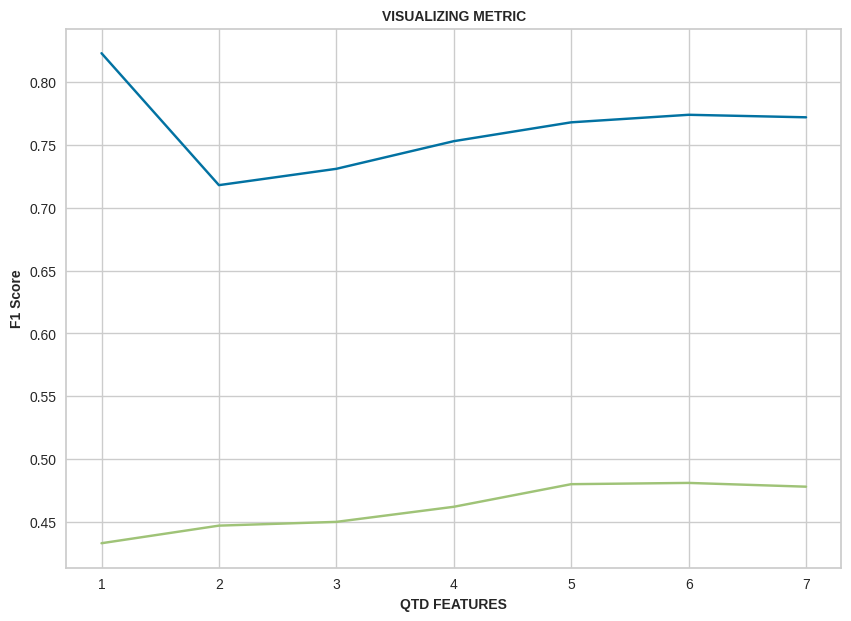

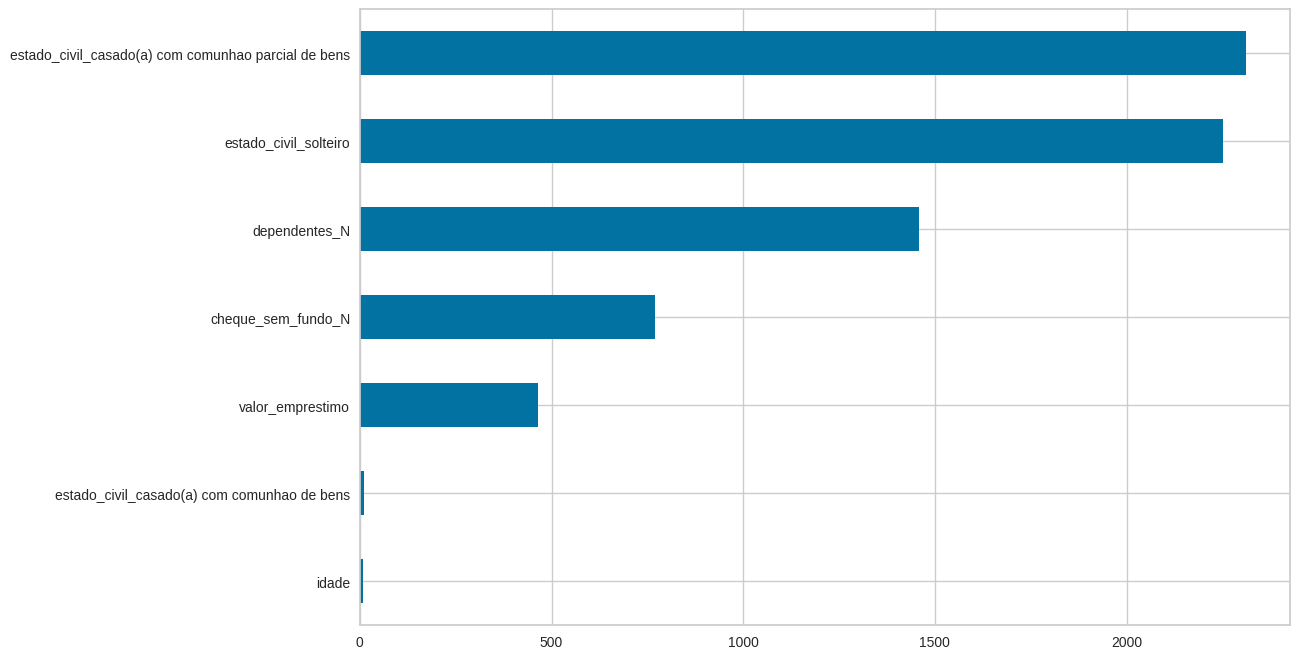

variavel     fs_score  \
0  estado_civil_casado(a) com comunhao parcial de...  2310.296370   
1                              estado_civil_solteiro  2252.493119   
2                                      dependentes_N  1457.194867   
3                                 cheque_sem_fundo_N   770.260255   
4                                   valor_emprestimo   463.627919   
5        estado_civil_casado(a) com comunhao de bens    11.793905   
6                                              idade     9.240297   

         p_value  
0   0.000000e+00  
1   0.000000e+00  
2  1.253339e-311  
3  1.747998e-167  
4  4.356637e-102  
5   5.950249e-04  
6   2.369434e-03

In [93]:
fs_kbest(x_train, y_train, x_test, y_test, model= LogisticRegression(class_weight='balanced'))

## 9.2 DECISION TREE

### 9.2.1 RECURSIVE FEATURE ADDITION

In [94]:
columns_select = ['dependentes', 'estado_civil', 'idade', 'conta_conjunta', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_dt = df9[columns_select].copy()

In [95]:
x_train, x_test, y_train, y_test = train_test_split(df9_dt.drop(['pago'], axis='columns'), df9_dt['pago'], test_size=config['split']['teste_size'], random_state=config['split']['seed'], stratify=df9_dt['pago'])


In [96]:

ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)

x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

ce_mean = MeanEncoder(variables=['conta_conjunta', 'dependentes', 'estado_civil', 'cheque_sem_fundo']).fit(x_train, y_train)

x_train = ce_mean.transform(x_train)
x_test = ce_mean.transform(x_test)


In [97]:
ce_mean.encoder_dict_

{'conta_conjunta': {'N': 0.21619533821454961, 'S': 0.1384850803366488},
 'dependentes': {'N': 0.27766357483078463, 'S': 0.09698275862068965},
 'estado_civil': {'casado(a) com comunhao de bens': 0.2315179126113067,
  'casado(a) com comunhao parcial de bens': 0.3888560972730492,
  'outros': 0.2767527675276753,
  'solteiro': 0.11415224291788945},
 'cheque_sem_fundo': {'N': 0.09542038848716858, 'S': 0.2474196770434493}}

In [98]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=config['split']['seed'])

estimator = DecisionTreeClassifier(class_weight='balanced', random_state=config['split']['seed'], max_depth=5)
rfa = RecursiveFeatureAddition(estimator, scoring='roc_auc', cv=kf, threshold=0.05, confirm_variables=False)
rfa.fit_transform(x_train,y_train)

estado_civil  valor_emprestimo
38633      0.114152          10946.00
15255      0.114152           2898.91
22547      0.231518           1501.00
14271      0.114152           3169.21
29288      0.114152           7989.45
...             ...               ...
852        0.114152           1569.00
27337      0.114152           2630.11
19111      0.231518          54697.40
37121      0.114152           1866.15
9323       0.114152          18395.02

[31081 rows x 2 columns]

### 9.2.2 FEATURE IMPORTANCE

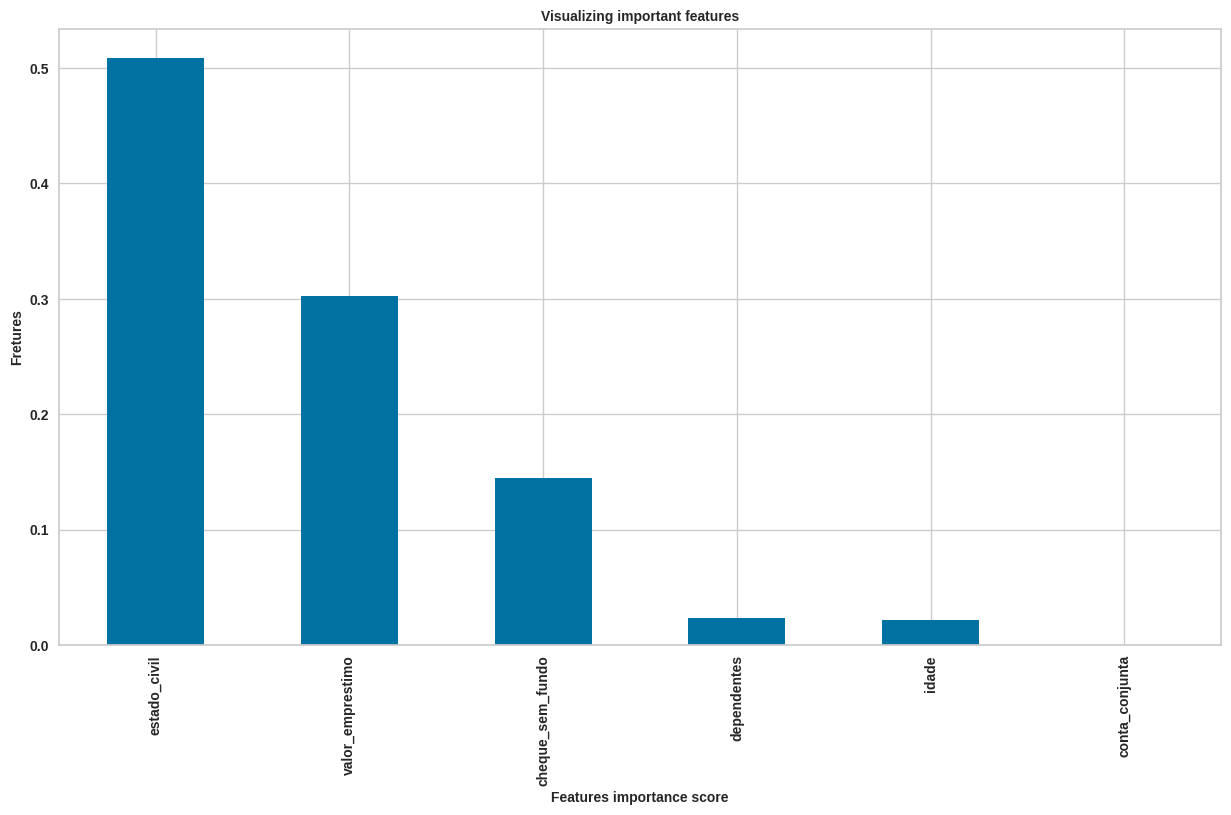

In [99]:
estimator = DecisionTreeClassifier(class_weight='balanced', random_state=config['split']['seed'], max_depth=5).fit(x_train, y_train)

features = pd.Series(estimator.feature_importances_)
features.index = x_train.columns

features.sort_values(ascending=False, inplace=True)

features.plot.bar(figsize=(15,8))

plt.xlabel('Features importance score', fontsize=10, weight='bold')
plt.ylabel('Fretures', fontsize=10, weight='bold')

plt.title('Visualizing important features', fontsize=10, weight='bold')

plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')

plt.show()


## 9.3 RANDOM FLOREST

### 9.3.1 RECURSIVE FEATURE ADDITION

In [100]:
columns_select = ['dependentes', 'estado_civil', 'idade', 'conta_conjunta', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_rf = df9[columns_select].copy()

In [101]:
x_train, x_test, y_train, y_test = train_test_split(df9_rf.drop(['pago'], axis='columns'), df9_rf['pago'], test_size=config['split']['teste_size'], random_state=config['split']['seed'], stratify=df9_rf['pago'])


In [102]:

ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)

x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

ce_mean = MeanEncoder(variables=['conta_conjunta', 'dependentes', 'estado_civil', 'cheque_sem_fundo']).fit(x_train, y_train)

x_train = ce_mean.transform(x_train)
x_test = ce_mean.transform(x_test)

In [103]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=config['split']['seed'])

estimator = RandomForestClassifier(class_weight='balanced', random_state=config['split']['seed'], max_depth=5)
rfa = RecursiveFeatureAddition(estimator, scoring='roc_auc', cv=kf, threshold=0.05, confirm_variables=False)
rfa.fit_transform(x_train,y_train)

estado_civil  valor_emprestimo
38633      0.114152          10946.00
15255      0.114152           2898.91
22547      0.231518           1501.00
14271      0.114152           3169.21
29288      0.114152           7989.45
...             ...               ...
852        0.114152           1569.00
27337      0.114152           2630.11
19111      0.231518          54697.40
37121      0.114152           1866.15
9323       0.114152          18395.02

[31081 rows x 2 columns]

### 9.3.2 FEATURE IMPORTANCE

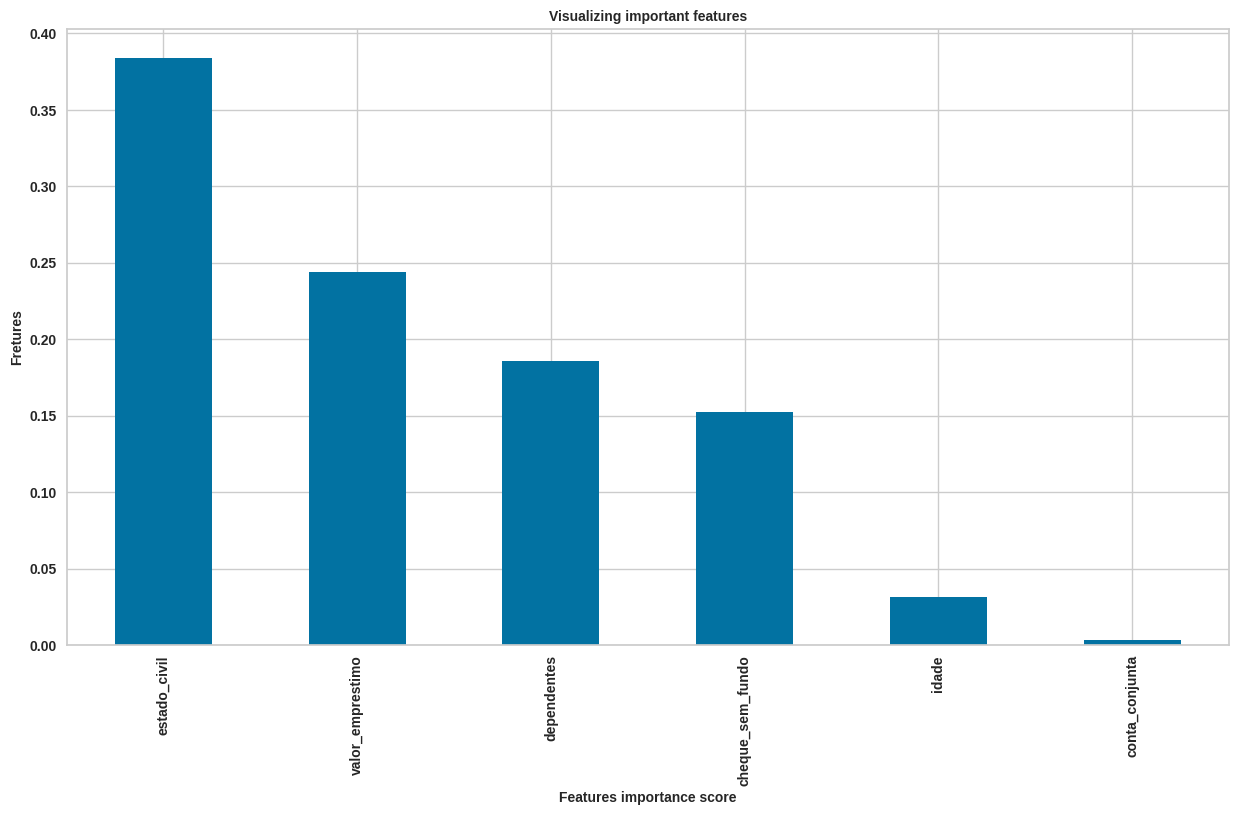

In [104]:
estimator = RandomForestClassifier(class_weight='balanced', random_state=config['split']['seed'], max_depth=5).fit(x_train, y_train)

features = pd.Series(estimator.feature_importances_)
features.index = x_train.columns

features.sort_values(ascending=False, inplace=True)

features.plot.bar(figsize=(15,8))

plt.xlabel('Features importance score', fontsize=10, weight='bold')
plt.ylabel('Fretures', fontsize=10, weight='bold')

plt.title('Visualizing important features', fontsize=10, weight='bold')

plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')

plt.show()


# 10.0 PIPELINE ML AND EVALUATION MODEL

## 10.1 LOGISTIC REGRESSION

In [105]:
df10_lr = pd.read_csv(config['data']['train_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df10_lr = df10_lr[columns_select].copy()

### 10.1.1 PIPILINE

In [106]:
onehot_features = ['dependentes', 'cheque_sem_fundo', 'estado_civil']
onehot_encoder = OneHotEncoder(drop_last=True)

target_features = []
target_encoder = MeanEncoder()

std_features = []
std_encoder = StandardScaler()

rare_label = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')

yj_features = ['valor_emprestimo']
yj_scaler = PowerTransformer(method='yeo-johnson', standardize=True)

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot_endcoder',onehot_encoder, onehot_features),
        ('target_endcoder',target_encoder, target_features),
        ('std_scaler',std_encoder, std_features),
        ('yj_scaler', yj_scaler, yj_features)
    ]
)

clf = Pipeline(
    steps=[
        ('rare_label',rare_label ),
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(n_jobs=-1,random_state=config['split']['seed'],class_weight='balanced'))
    ]
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=config['split']['seed'])


### 10.1.2 TRAIN AND VALIDATION METRICS

In [107]:
lr_result = cv_clf_metrics(model=clf, df=df10_lr, target='pago', cv=kf, model_name='lr', search=False)

TRAIN DATA
accuracy: [0.683, 0.696, 0.694, 0.683, 0.684] / media: 0.688 / std: 0.006
balanced_accuracy: [0.687, 0.688, 0.687, 0.688, 0.686] / media: 0.687 / std: 0.001
roc_auc: [0.747, 0.746, 0.745, 0.745, 0.745] / media: 0.746 / std: 0.001
f1_class_0: [0.772, 0.784, 0.782, 0.772, 0.773] / media: 0.777 / std: 0.005
f1_class_1: [0.483, 0.486, 0.484, 0.483, 0.482] / media: 0.484 / std: 0.001
precision_class_0: [0.892, 0.889, 0.888, 0.892, 0.89] / media: 0.89 / std: 0.002
precision_class_1: [0.37, 0.38, 0.378, 0.37, 0.371] / media: 0.374 / std: 0.004
recall_class_0: [0.68, 0.702, 0.699, 0.68, 0.683] / media: 0.689 / std: 0.01
recall_class_1: [0.694, 0.675, 0.676, 0.696, 0.689] / media: 0.686 / std: 0.009

-----------------------------------------------------------------

TEST DATA
accuracy: [0.689, 0.688, 0.699, 0.675, 0.685] / media: 0.687 / std: 0.008
balanced_accuracy: [0.686, 0.677, 0.689, 0.686, 0.691] / media: 0.686 / std: 0.005
roc_auc: [0.741, 0.745, 0.746, 0.746, 0.749] / media: 

Model Name    Accuracy CV balanced_accuracy CV Roc Auc Score CV  \
0         lr  0.687+/-0.008        0.686+/-0.005    0.745+/-0.003   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0        0.889+/-0.004        0.373+/-0.006     0.688+/-0.014   

  Recall Class 1 CV  F1 Class 0 CV  F1 Class 1 CV  
0     0.684+/-0.019  0.776+/-0.008  0.482+/-0.005

### 10.1.3 GRID_SEARCH

In [108]:
param_grid = {
    'classifier__C':np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1','l2', 'elasticnet', None],
    'classifier__class_weight': ['balanced'],
    'classifier__solver': ['saga', 'liblinear', 'lbfgs']
}

In [109]:
lr = GridSearchCV(clf, param_grid, scoring=['f1', 'balanced_accuracy', 'roc_auc', 'accuracy'], cv=kf, refit='roc_auc')
search_lr = lr.fit(df10_lr.drop('pago', axis='columns'), df10_lr['pago'])
print(search_lr.best_params_)
print('\n')
print(round(search_lr.best_score_,3))


{'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


0.745


In [110]:
results = pd.DataFrame(search_lr.cv_results_) [['params', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_f1', 'std_test_f1', 
                                               'mean_test_balanced_accuracy', 'std_test_balanced_accuracy','mean_test_accuracy', 'std_test_accuracy']]

results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)
results.head()

params  mean_test_roc_auc  \
29  {'classifier__C': 0.1, 'classifier__class_weig...           0.745303   
28  {'classifier__C': 0.1, 'classifier__class_weig...           0.745284   
53  {'classifier__C': 10.0, 'classifier__class_wei...           0.745274   
83  {'classifier__C': 1000.0, 'classifier__class_w...           0.745274   
71  {'classifier__C': 100.0, 'classifier__class_we...           0.745274   

    std_test_roc_auc  mean_test_f1  std_test_f1  mean_test_balanced_accuracy  \
29          0.002502      0.482325     0.004726                     0.686194   
28          0.002504      0.482585     0.004851                     0.686458   
53          0.002509      0.481904     0.005133                     0.685781   
83          0.002509      0.481904     0.005133                     0.685781   
71          0.002509      0.481904     0.005133                     0.685781   

    std_test_balanced_accuracy  mean_test_accuracy  std_test_accuracy  
29                    0.004463            0.687017           0.007633  
28                    0.004621            0.687017           0.007644  
53                    0.004842            0.686992           0.007758  
83                    0.004842            0.686992           0.007758  
71                    0.004842            0.686992           0.007758

(array([0.71 , 0.715, 0.72 , 0.725, 0.73 , 0.735, 0.74 , 0.745, 0.75 ]),
 [Text(0, 0.71, '0.710'),
  Text(0, 0.715, '0.715'),
  Text(0, 0.72, '0.720'),
  Text(0, 0.725, '0.725'),
  Text(0, 0.73, '0.730'),
  Text(0, 0.735, '0.735'),
  Text(0, 0.74, '0.740'),
  Text(0, 0.745, '0.745'),
  Text(0, 0.75, '0.750')])

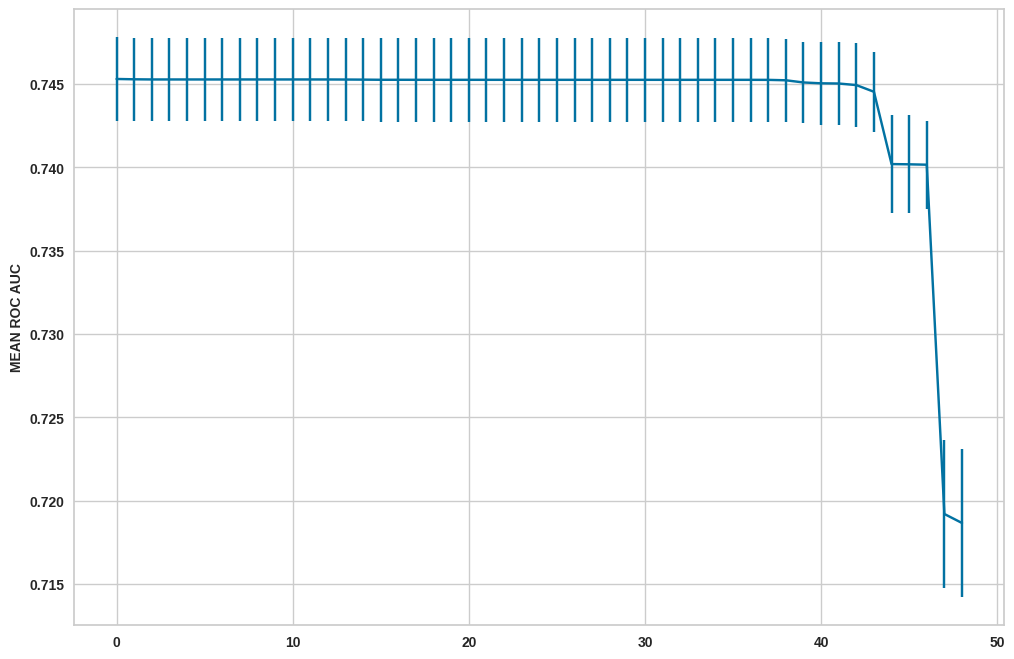

In [111]:
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True) 

results['mean_test_roc_auc'].plot(yerr=[results['std_test_roc_auc'], results['std_test_roc_auc']], subplots=True)
plt.ylabel('MEAN ROC AUC', fontsize=10, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')



### 10.1.4 EVAL BEST LR MODEL

In [112]:
search_lr.best_estimator_

Pipeline(steps=[('rare_label',
                 RareLabelEncoder(n_categories=5, replace_with='outros',
                                  variables=['estado_civil'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('onehot_endcoder',
                                                  OneHotEncoder(drop_last=True),
                                                  ['dependentes',
                                                   'cheque_sem_fundo',
                                                   'estado_civil']),
                                                 ('target_endcoder',
                                                  MeanEncoder(), []),
                                                 ('std_scaler',
                                                  StandardScaler(), []),
                                                 ('yj_scaler',
                                                  PowerTransformer(),
                                                  ['valor_emprestimo'])])),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1,
                                    random_state=42))])

In [113]:
lr_result = cv_clf_metrics(model=search_lr.best_estimator_, df=df10_lr, target='pago', cv=kf, model_name='lr', search=False)

TRAIN DATA
accuracy: [0.683, 0.696, 0.693, 0.683, 0.685] / media: 0.688 / std: 0.005
balanced_accuracy: [0.687, 0.688, 0.687, 0.688, 0.687] / media: 0.687 / std: 0.0
roc_auc: [0.747, 0.746, 0.745, 0.745, 0.745] / media: 0.746 / std: 0.001
f1_class_0: [0.771, 0.784, 0.782, 0.771, 0.773] / media: 0.776 / std: 0.006
f1_class_1: [0.483, 0.486, 0.484, 0.483, 0.483] / media: 0.484 / std: 0.001
precision_class_0: [0.892, 0.889, 0.889, 0.892, 0.891] / media: 0.891 / std: 0.001
precision_class_1: [0.37, 0.38, 0.377, 0.37, 0.371] / media: 0.374 / std: 0.004
recall_class_0: [0.68, 0.701, 0.698, 0.68, 0.683] / media: 0.688 / std: 0.009
recall_class_1: [0.695, 0.675, 0.676, 0.696, 0.691] / media: 0.687 / std: 0.009

-----------------------------------------------------------------

TEST DATA
accuracy: [0.689, 0.688, 0.698, 0.675, 0.685] / media: 0.687 / std: 0.007
balanced_accuracy: [0.687, 0.678, 0.689, 0.686, 0.691] / media: 0.686 / std: 0.004
roc_auc: [0.741, 0.745, 0.746, 0.746, 0.749] / media:

Model Name    Accuracy CV balanced_accuracy CV Roc Auc Score CV  \
0         lr  0.687+/-0.007        0.686+/-0.004    0.745+/-0.003   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0         0.89+/-0.004        0.372+/-0.006     0.688+/-0.013   

  Recall Class 1 CV  F1 Class 0 CV  F1 Class 1 CV  
0     0.685+/-0.018  0.776+/-0.008  0.482+/-0.005

### 10.1.5 TEST SET METRICS

In [114]:
test_set = pd.read_csv(config['data']['test_path'])
test_set = test_set[df10_lr.columns]
x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

     Predito     0     1   All
Real                          
0             5259  2387  7646
1              595  1473  2068
All           5854  3860  9714



              precision    recall  f1-score   support

           0       0.90      0.69      0.78      7646
           1       0.38      0.71      0.50      2068

    accuracy                           0.69      9714
   macro avg       0.64      0.70      0.64      9714
weighted avg       0.79      0.69      0.72      9714



ROC_AUC 0.76


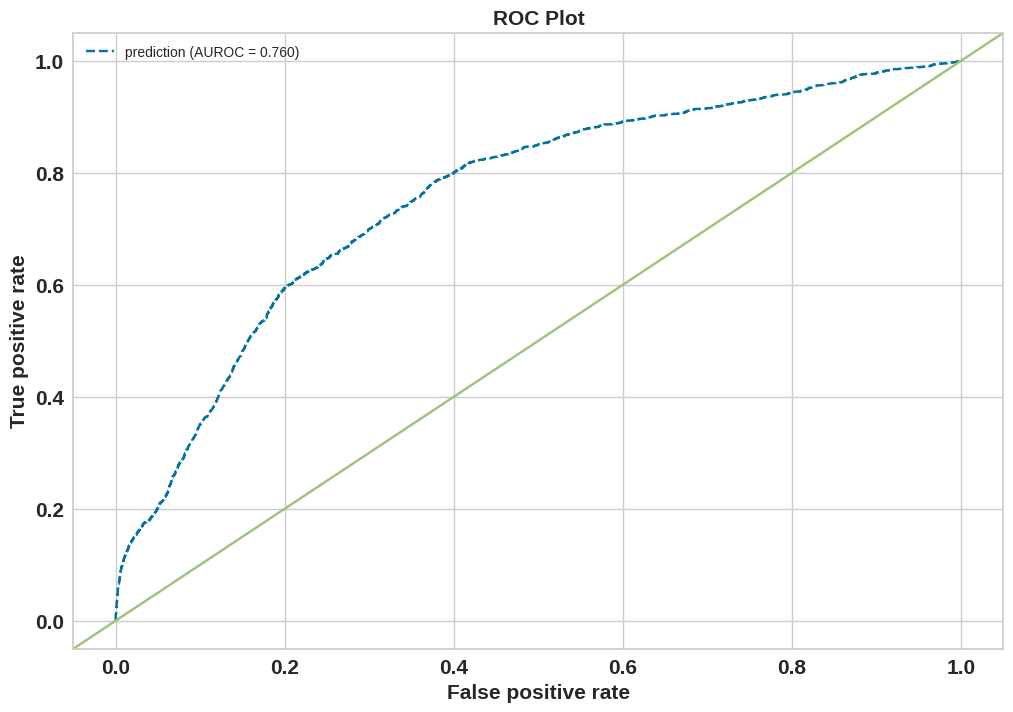

     Predito     0     1   All
Real                          
0             5745  1901  7646
1              732  1336  2068
All           6477  3237  9714



              precision    recall  f1-score   support

           0       0.89      0.75      0.81      7646
           1       0.41      0.65      0.50      2068

    accuracy                           0.73      9714
   macro avg       0.65      0.70      0.66      9714
weighted avg       0.79      0.73      0.75      9714





In [115]:
cm_roc_plot(search_lr.best_estimator_, x_test, y_test, th=0.55)

## 10.2 DECISION TREE

In [116]:
df10_dt = pd.read_csv(config['data']['train_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df10_dt = df10_dt[columns_select].copy()

### 10.2.1 PIPELINE

In [117]:
clf = Pipeline([
    ('rare_encoder', RareLabelEncoder(tol=0.05, n_categories=5, variables=['estado_civil'], replace_with='outros')),
    ('categorical_encoder',MeanEncoder(variables=['dependentes', 'estado_civil', 'cheque_sem_fundo'])),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=config['split']['seed'], max_depth=5))
])

kf = StratifiedKFold(n_splits=5,shuffle=True, random_state=config['split']['seed'])

### 10.2.2 TRAIN AND VALIDATION METRICS

In [118]:
dt_result = cv_clf_metrics(model=clf, df=df10_dt, target='pago', cv=kf, model_name='dt', search=False)

TRAIN DATA
accuracy: [0.673, 0.745, 0.736, 0.744, 0.726] / media: 0.725 / std: 0.027
balanced_accuracy: [0.705, 0.705, 0.705, 0.703, 0.703] / media: 0.704 / std: 0.001
roc_auc: [0.772, 0.769, 0.769, 0.768, 0.769] / media: 0.769 / std: 0.001
f1_class_0: [0.758, 0.827, 0.819, 0.826, 0.81] / media: 0.808 / std: 0.026
f1_class_1: [0.498, 0.515, 0.512, 0.512, 0.508] / media: 0.509 / std: 0.006
precision_class_0: [0.909, 0.887, 0.889, 0.886, 0.891] / media: 0.892 / std: 0.008
precision_class_1: [0.37, 0.433, 0.422, 0.431, 0.411] / media: 0.413 / std: 0.023
recall_class_0: [0.65, 0.775, 0.759, 0.774, 0.743] / media: 0.74 / std: 0.047
recall_class_1: [0.76, 0.636, 0.651, 0.633, 0.663] / media: 0.669 / std: 0.047

-----------------------------------------------------------------

TEST DATA
accuracy: [0.671, 0.74, 0.735, 0.74, 0.721] / media: 0.721 / std: 0.026
balanced_accuracy: [0.692, 0.699, 0.699, 0.705, 0.701] / media: 0.699 / std: 0.004
roc_auc: [0.753, 0.766, 0.766, 0.766, 0.767] / media:

Model Name    Accuracy CV balanced_accuracy CV Roc Auc Score CV  \
0         dt  0.721+/-0.026        0.699+/-0.004    0.764+/-0.005   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0         0.89+/-0.005        0.408+/-0.024     0.738+/-0.043   

  Recall Class 1 CV  F1 Class 0 CV F1 Class 1 CV  
0     0.661+/-0.036  0.806+/-0.025  0.503+/-0.01

### 10.2.3 GRID SEARCH 

In [119]:
param_grid = {
    'classifier__max_features':['auto', 'sqrt', 'log2'],
    'classifier__class_weight': ['balanced'],
    'classifier__min_samples_leaf': [100, 200, 300, 400],
    'classifier__min_samples_split': [100, 200, 300, 400],
    'classifier__max_depth': [3, 4, 5, 6, 7],
}

In [120]:
dt = GridSearchCV(clf, param_grid, scoring=['f1', 'balanced_accuracy', 'roc_auc', 'accuracy'], cv=kf, refit='roc_auc')
search_dt = dt.fit(df10_dt.drop('pago', axis='columns'), df10_dt['pago'])
print(search_dt.best_params_)
print('\n')
print(round(search_dt.best_score_,3))


{'classifier__class_weight': 'balanced', 'classifier__max_depth': 6, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 100, 'classifier__min_samples_split': 400}


0.766


In [121]:
results = pd.DataFrame(search_dt.cv_results_) [['params', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_f1', 'std_test_f1', 
                                               'mean_test_balanced_accuracy', 'std_test_balanced_accuracy','mean_test_accuracy', 'std_test_accuracy']]

results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)
results.head()

params  mean_test_roc_auc  \
163  {'classifier__class_weight': 'balanced', 'clas...           0.765881   
179  {'classifier__class_weight': 'balanced', 'clas...           0.765881   
178  {'classifier__class_weight': 'balanced', 'clas...           0.765414   
162  {'classifier__class_weight': 'balanced', 'clas...           0.765414   
164  {'classifier__class_weight': 'balanced', 'clas...           0.764742   

     std_test_roc_auc  mean_test_f1  std_test_f1  mean_test_balanced_accuracy  \
163          0.005549      0.505072     0.011163                     0.701677   
179          0.005549      0.505072     0.011163                     0.701677   
178          0.004845      0.503248     0.007747                     0.701471   
162          0.004845      0.503248     0.007747                     0.701471   
164          0.005505      0.508544     0.011782                     0.703480   

     std_test_balanced_accuracy  mean_test_accuracy  std_test_accuracy  
163                    0.006378            0.718960           0.025646  
179                    0.006378            0.718960           0.025646  
178                    0.003684            0.713014           0.024109  
162                    0.003684            0.713014           0.024109  
164                    0.006413            0.725266           0.025948

(array([0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78]),
 [Text(0, 0.72, '0.72'),
  Text(0, 0.73, '0.73'),
  Text(0, 0.74, '0.74'),
  Text(0, 0.75, '0.75'),
  Text(0, 0.76, '0.76'),
  Text(0, 0.77, '0.77'),
  Text(0, 0.78, '0.78')])

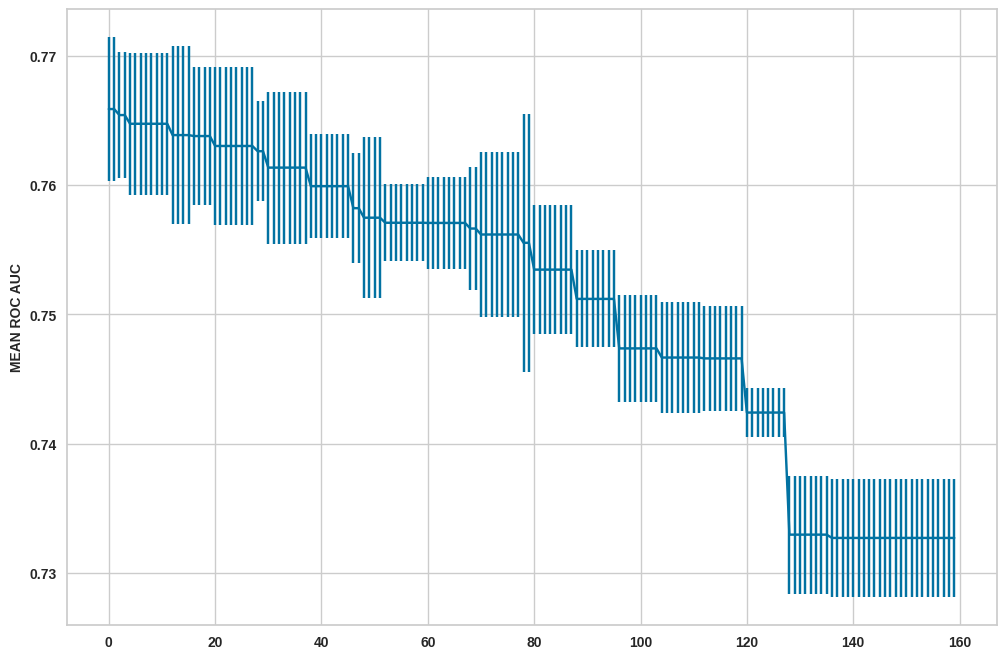

In [122]:
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True) 

results['mean_test_roc_auc'].plot(yerr=[results['std_test_roc_auc'], results['std_test_roc_auc']], subplots=True)
plt.ylabel('MEAN ROC AUC', fontsize=10, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')



### 10.2.4 EVAL BEST DT MODEL

In [123]:
search_dt.best_estimator_

Pipeline(steps=[('rare_encoder',
                 RareLabelEncoder(n_categories=5, replace_with='outros',
                                  variables=['estado_civil'])),
                ('categorical_encoder',
                 MeanEncoder(variables=['dependentes', 'estado_civil',
                                        'cheque_sem_fundo'])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                                        max_features='sqrt',
                                        min_samples_leaf=100,
                                        min_samples_split=400,
                                        random_state=42))])

In [124]:
dt_result = cv_clf_metrics(model=search_dt.best_estimator_, df=df10_dt, target='pago', cv=kf, model_name='dt', search=False)

TRAIN DATA
accuracy: [0.674, 0.739, 0.742, 0.737, 0.721] / media: 0.723 / std: 0.025
balanced_accuracy: [0.705, 0.709, 0.71, 0.707, 0.705] / media: 0.707 / std: 0.002
roc_auc: [0.773, 0.772, 0.773, 0.773, 0.77] / media: 0.772 / std: 0.001
f1_class_0: [0.758, 0.822, 0.824, 0.82, 0.805] / media: 0.806 / std: 0.025
f1_class_1: [0.498, 0.517, 0.519, 0.514, 0.508] / media: 0.511 / std: 0.008
precision_class_0: [0.909, 0.891, 0.891, 0.89, 0.894] / media: 0.895 / std: 0.007
precision_class_1: [0.37, 0.427, 0.43, 0.424, 0.407] / media: 0.412 / std: 0.022
recall_class_0: [0.65, 0.762, 0.766, 0.759, 0.733] / media: 0.734 / std: 0.044
recall_class_1: [0.761, 0.655, 0.653, 0.654, 0.678] / media: 0.68 / std: 0.041

-----------------------------------------------------------------

TEST DATA
accuracy: [0.67, 0.734, 0.739, 0.734, 0.718] / media: 0.719 / std: 0.026
balanced_accuracy: [0.691, 0.702, 0.701, 0.71, 0.704] / media: 0.702 / std: 0.006
roc_auc: [0.755, 0.769, 0.766, 0.772, 0.768] / media: 0.

Model Name    Accuracy CV balanced_accuracy CV Roc Auc Score CV  \
0         dt  0.719+/-0.026        0.702+/-0.006    0.766+/-0.006   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0        0.892+/-0.005        0.406+/-0.023     0.732+/-0.041   

  Recall Class 1 CV  F1 Class 0 CV  F1 Class 1 CV  
0     0.672+/-0.032  0.803+/-0.024  0.505+/-0.011

### 10.2.5 TEST SET METRICS

In [125]:
test_set = pd.read_csv(config['data']['test_path'])
test_set = test_set[df10_dt.columns]
x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

     Predito     0     1   All
Real                          
0             5630  2016  7646
1              663  1405  2068
All           6293  3421  9714



              precision    recall  f1-score   support

           0       0.89      0.74      0.81      7646
           1       0.41      0.68      0.51      2068

    accuracy                           0.72      9714
   macro avg       0.65      0.71      0.66      9714
weighted avg       0.79      0.72      0.74      9714



ROC_AUC 0.77


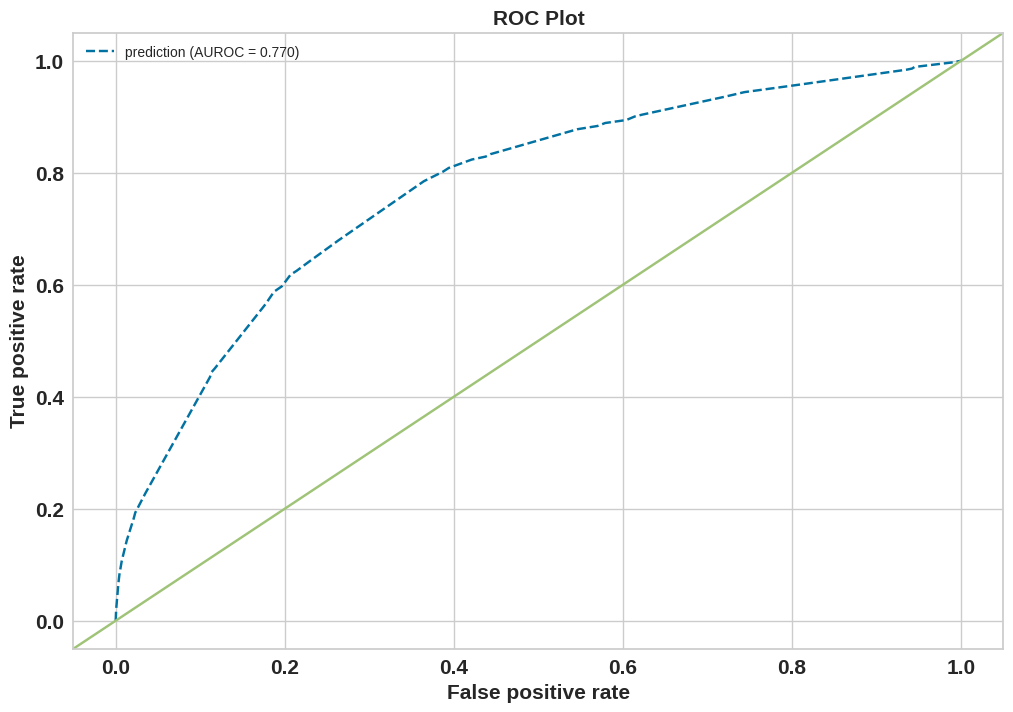

     Predito     0     1   All
Real                          
0             6010  1636  7646
1              776  1292  2068
All           6786  2928  9714



              precision    recall  f1-score   support

           0       0.89      0.79      0.83      7646
           1       0.44      0.62      0.52      2068

    accuracy                           0.75      9714
   macro avg       0.66      0.71      0.68      9714
weighted avg       0.79      0.75      0.77      9714





In [126]:
cm_roc_plot(search_dt.best_estimator_, x_test, y_test, th=0.55)

## 10.3 RANDOM FLOREST

In [127]:
df10_rf = pd.read_csv(config['data']['train_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']

df10_rf = df10_rf[columns_select].copy()

### 10.3.1 PIPELINE

In [128]:
clf = Pipeline([
    ('rare_encoder', RareLabelEncoder(tol=0.05, n_categories=5, variables=['estado_civil'], replace_with='outros')),
    ('categorical_encoder',MeanEncoder(variables=['dependentes', 'estado_civil', 'cheque_sem_fundo'])),
    ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=config['split']['seed'], max_depth=5, max_features='sqrt', n_jobs=-1))
])

kf = StratifiedKFold(n_splits=5,shuffle=True, random_state=config['split']['seed'])

### 10.3.2 TRAIN AND VALIDATION METRICS

In [129]:
rf_result = cv_clf_metrics(model=clf, df=df10_rf, target='pago', cv=kf, model_name='rf', search=False)

TRAIN DATA
accuracy: [0.687, 0.705, 0.714, 0.686, 0.684] / media: 0.695 / std: 0.012
balanced_accuracy: [0.714, 0.716, 0.718, 0.71, 0.709] / media: 0.713 / std: 0.003
roc_auc: [0.784, 0.78, 0.781, 0.781, 0.779] / media: 0.781 / std: 0.002
f1_class_0: [0.771, 0.788, 0.797, 0.77, 0.768] / media: 0.779 / std: 0.012
f1_class_1: [0.509, 0.515, 0.519, 0.505, 0.503] / media: 0.51 / std: 0.006
precision_class_0: [0.912, 0.906, 0.905, 0.908, 0.909] / media: 0.908 / std: 0.002
precision_class_1: [0.382, 0.396, 0.405, 0.38, 0.378] / media: 0.388 / std: 0.011
recall_class_0: [0.668, 0.698, 0.712, 0.668, 0.665] / media: 0.682 / std: 0.019
recall_class_1: [0.761, 0.734, 0.724, 0.751, 0.752] / media: 0.744 / std: 0.013

-----------------------------------------------------------------

TEST DATA
accuracy: [0.682, 0.702, 0.709, 0.677, 0.688] / media: 0.692 / std: 0.012
balanced_accuracy: [0.696, 0.714, 0.706, 0.706, 0.714] / media: 0.707 / std: 0.007
roc_auc: [0.765, 0.776, 0.777, 0.777, 0.781] / medi

Model Name    Accuracy CV balanced_accuracy CV Roc Auc Score CV  \
0         rf  0.692+/-0.012        0.707+/-0.007    0.775+/-0.005   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0        0.905+/-0.005         0.384+/-0.01       0.68+/-0.02   

  Recall Class 1 CV  F1 Class 0 CV  F1 Class 1 CV  
0     0.735+/-0.022  0.776+/-0.011  0.504+/-0.008

### 10.3.3 RANDOM SEARCH

In [130]:
param_grid = {
    'classifier__n_estimators': [150,200],
    'classifier__max_features':['auto', 'sqrt'],
    'classifier__class_weight': ['balanced'],
    'classifier__min_samples_leaf': [100, 200, 300],
    'classifier__min_samples_split': [100, 200, 300],
    'classifier__max_depth': [6, 7, 8],
}

In [131]:
rf = RandomizedSearchCV(clf, param_grid, scoring=['f1', 'balanced_accuracy', 'roc_auc', 'accuracy'], cv=kf, refit='roc_auc', random_state=config['split']['seed'], n_iter=60)
search_rf = rf.fit(df10_rf.drop('pago', axis='columns'), df10_rf['pago'])
print(search_rf.best_params_)
print('\n')
print(round(search_rf.best_score_,3))


{'classifier__n_estimators': 150, 'classifier__min_samples_split': 100, 'classifier__min_samples_leaf': 100, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 8, 'classifier__class_weight': 'balanced'}


0.778


In [132]:
results = pd.DataFrame(search_rf.cv_results_) [['params', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_f1', 'std_test_f1', 
                                               'mean_test_balanced_accuracy', 'std_test_balanced_accuracy','mean_test_accuracy', 'std_test_accuracy']]

results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)
results.head()

params  mean_test_roc_auc  \
53  {'classifier__n_estimators': 150, 'classifier_...           0.778027   
8   {'classifier__n_estimators': 200, 'classifier_...           0.777610   
16  {'classifier__n_estimators': 150, 'classifier_...           0.777379   
34  {'classifier__n_estimators': 200, 'classifier_...           0.777364   
52  {'classifier__n_estimators': 200, 'classifier_...           0.776051   

    std_test_roc_auc  mean_test_f1  std_test_f1  mean_test_balanced_accuracy  \
53          0.005190      0.515105     0.005190                     0.712946   
8           0.005342      0.513971     0.004180                     0.712298   
16          0.005225      0.515295     0.006933                     0.712288   
34          0.005246      0.516190     0.006597                     0.712937   
52          0.005312      0.513815     0.009319                     0.711347   

    std_test_balanced_accuracy  mean_test_accuracy  std_test_accuracy  
53                    0.004728            0.717054           0.005886  
8                     0.004047            0.715201           0.003069  
16                    0.005357            0.719834           0.010126  
34                    0.004980            0.720787           0.009915  
52                    0.006980            0.717312           0.014639

(array([0.766, 0.768, 0.77 , 0.772, 0.774, 0.776, 0.778, 0.78 , 0.782,
        0.784]),
 [Text(0, 0.766, '0.766'),
  Text(0, 0.768, '0.768'),
  Text(0, 0.77, '0.770'),
  Text(0, 0.772, '0.772'),
  Text(0, 0.774, '0.774'),
  Text(0, 0.776, '0.776'),
  Text(0, 0.778, '0.778'),
  Text(0, 0.78, '0.780'),
  Text(0, 0.782, '0.782'),
  Text(0, 0.784, '0.784')])

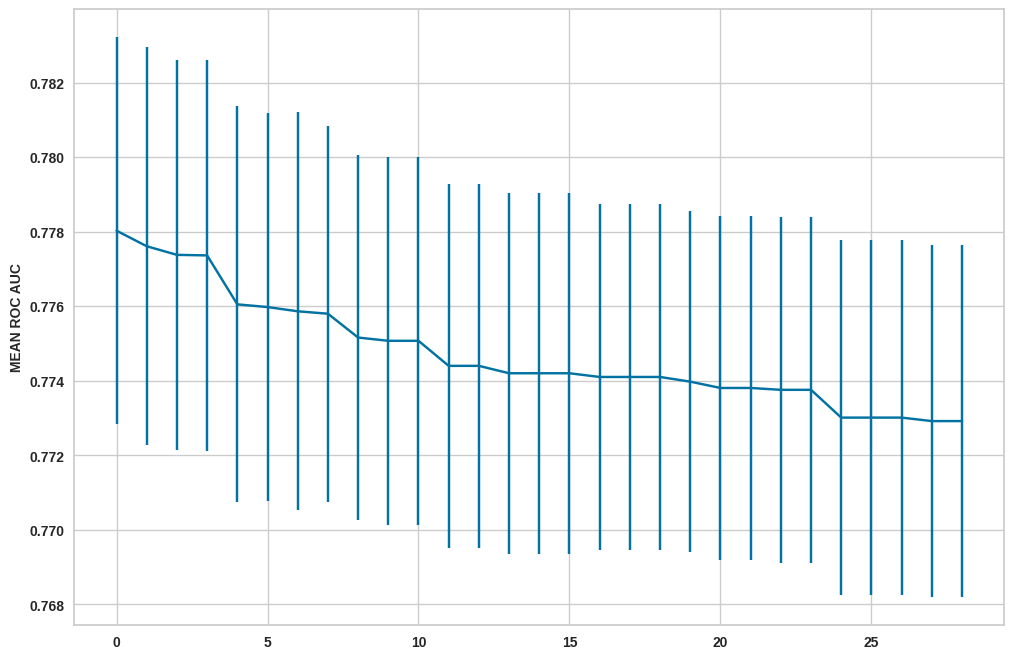

In [133]:
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True) 

results['mean_test_roc_auc'].plot(yerr=[results['std_test_roc_auc'], results['std_test_roc_auc']], subplots=True)
plt.ylabel('MEAN ROC AUC', fontsize=10, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')



### 10.3.4 EVAL BEST RF MODEL

In [134]:
search_rf.best_estimator_

Pipeline(steps=[('rare_encoder',
                 RareLabelEncoder(n_categories=5, replace_with='outros',
                                  variables=['estado_civil'])),
                ('categorical_encoder',
                 MeanEncoder(variables=['dependentes', 'estado_civil',
                                        'cheque_sem_fundo'])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        min_samples_leaf=100,
                                        min_samples_split=100, n_estimators=150,
                                        n_jobs=-1, random_state=42))])

In [135]:
rf_result = cv_clf_metrics(model=search_rf.best_estimator_, df=df10_rf, target='pago', cv=kf, model_name='rf', search=False)

TRAIN DATA
accuracy: [0.716, 0.728, 0.724, 0.715, 0.721] / media: 0.721 / std: 0.005
balanced_accuracy: [0.721, 0.717, 0.72, 0.718, 0.718] / media: 0.719 / std: 0.001
roc_auc: [0.79, 0.787, 0.788, 0.787, 0.787] / media: 0.788 / std: 0.001
f1_class_0: [0.798, 0.81, 0.806, 0.797, 0.803] / media: 0.803 / std: 0.005
f1_class_1: [0.522, 0.522, 0.524, 0.519, 0.521] / media: 0.522 / std: 0.002
precision_class_0: [0.907, 0.9, 0.903, 0.905, 0.903] / media: 0.904 / std: 0.002
precision_class_1: [0.407, 0.417, 0.414, 0.405, 0.41] / media: 0.411 / std: 0.004
recall_class_0: [0.712, 0.737, 0.727, 0.713, 0.723] / media: 0.722 / std: 0.009
recall_class_1: [0.73, 0.697, 0.712, 0.722, 0.712] / media: 0.715 / std: 0.011

-----------------------------------------------------------------

TEST DATA
accuracy: [0.714, 0.727, 0.718, 0.709, 0.718] / media: 0.717 / std: 0.006
balanced_accuracy: [0.708, 0.715, 0.707, 0.715, 0.72] / media: 0.713 / std: 0.005
roc_auc: [0.768, 0.78, 0.78, 0.78, 0.783] / media: 0.7

Model Name    Accuracy CV balanced_accuracy CV Roc Auc Score CV  \
0         rf  0.717+/-0.006        0.713+/-0.005    0.778+/-0.005   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0          0.9+/-0.003        0.406+/-0.006       0.72+/-0.01   

  Recall Class 1 CV F1 Class 0 CV  F1 Class 1 CV  
0     0.706+/-0.015   0.8+/-0.006  0.515+/-0.005

### 10.3.5 TEST SET METRICS

In [136]:
test_set = pd.read_csv(config['data']['test_path'])
test_set = test_set[df10_rf.columns]
x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

     Predito     0     1   All
Real                          
0             5584  2062  7646
1              598  1470  2068
All           6182  3532  9714



              precision    recall  f1-score   support

           0       0.90      0.73      0.81      7646
           1       0.42      0.71      0.53      2068

    accuracy                           0.73      9714
   macro avg       0.66      0.72      0.67      9714
weighted avg       0.80      0.73      0.75      9714



ROC_AUC 0.79


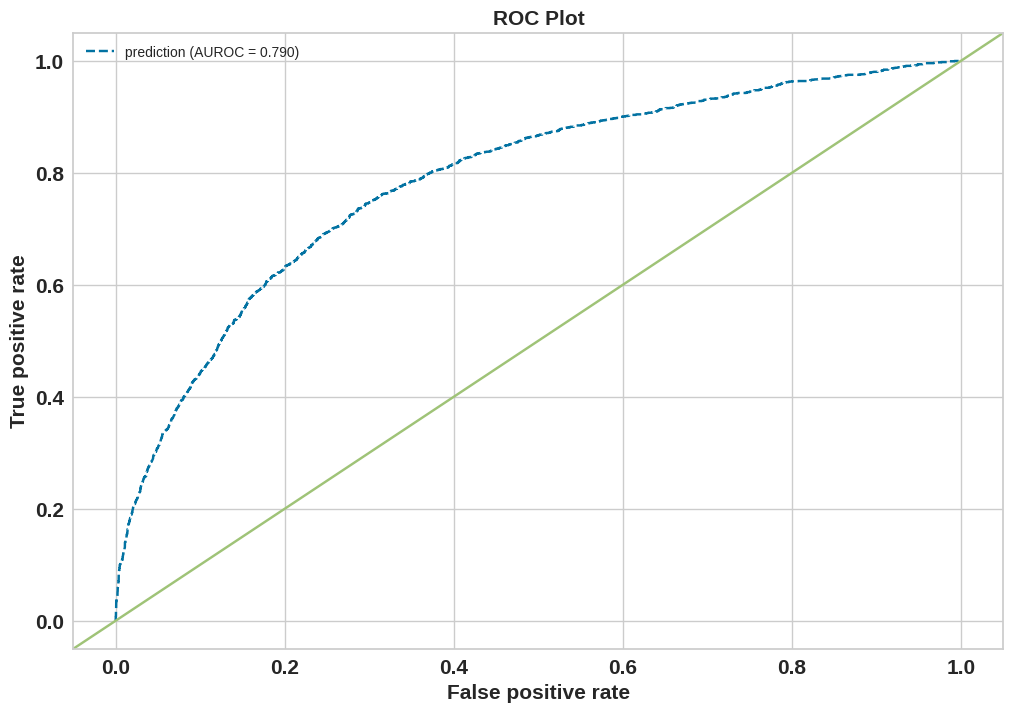

     Predito     0     1   All
Real                          
0             6055  1591  7646
1              748  1320  2068
All           6803  2911  9714



              precision    recall  f1-score   support

           0       0.89      0.79      0.84      7646
           1       0.45      0.64      0.53      2068

    accuracy                           0.76      9714
   macro avg       0.67      0.72      0.68      9714
weighted avg       0.80      0.76      0.77      9714





In [137]:
cm_roc_plot(search_rf.best_estimator_, x_test, y_test, th=0.55)

## 10.4 XGBOOST 

In [138]:
df10_xgb = pd.read_csv(config['data']['train_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']

df10_xgb = df10_xgb[columns_select].copy()

### 10.4.1 PIPELINE

In [139]:
clf = Pipeline([
    ('rare_encoder', RareLabelEncoder(tol=0.05, n_categories=5, variables=['estado_civil'], replace_with='outros')),
    ('categorical_encoder',MeanEncoder(variables=['dependentes', 'estado_civil', 'cheque_sem_fundo'])),
    ('classifier', xgb.XGBClassifier(n_estimators=200, random_state=config['split']['seed'], scale_pos_weight=4, max_depth=3, n_jobs=-1))
])

kf = StratifiedKFold(n_splits=5,shuffle=True, random_state=config['split']['seed'])

### 10.4.2 TRAIN AND VALIDATION METRICS

In [140]:
xgb_result = cv_clf_metrics(model=clf, df=df10_xgb, target='pago', cv=kf, model_name='xgb', search=False)

TRAIN DATA
accuracy: [0.729, 0.728, 0.731, 0.727, 0.724] / media: 0.728 / std: 0.002
balanced_accuracy: [0.733, 0.732, 0.733, 0.732, 0.73] / media: 0.732 / std: 0.001
roc_auc: [0.808, 0.805, 0.806, 0.806, 0.805] / media: 0.806 / std: 0.001
f1_class_0: [0.809, 0.807, 0.81, 0.807, 0.804] / media: 0.807 / std: 0.002
f1_class_1: [0.538, 0.537, 0.538, 0.536, 0.534] / media: 0.537 / std: 0.001
precision_class_0: [0.912, 0.912, 0.911, 0.911, 0.911] / media: 0.911 / std: 0.0
precision_class_1: [0.423, 0.421, 0.424, 0.42, 0.417] / media: 0.421 / std: 0.002
recall_class_0: [0.727, 0.725, 0.729, 0.724, 0.72] / media: 0.725 / std: 0.003
recall_class_1: [0.74, 0.74, 0.738, 0.739, 0.74] / media: 0.739 / std: 0.001

-----------------------------------------------------------------

TEST DATA
accuracy: [0.716, 0.715, 0.717, 0.711, 0.712] / media: 0.714 / std: 0.002
balanced_accuracy: [0.705, 0.713, 0.708, 0.715, 0.718] / media: 0.712 / std: 0.005
roc_auc: [0.766, 0.776, 0.778, 0.781, 0.78] / media: 0.

Model Name    Accuracy CV balanced_accuracy CV Roc Auc Score CV  \
0        xgb  0.714+/-0.002        0.712+/-0.005    0.776+/-0.005   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0        0.901+/-0.004        0.403+/-0.001     0.716+/-0.007   

  Recall Class 1 CV  F1 Class 0 CV  F1 Class 1 CV  
0     0.707+/-0.016  0.798+/-0.003  0.513+/-0.004

### 10.4.3 RANDOM SEARCH

In [141]:
param_grid = {
    'classifier__n_estimators': [100,150,200],
    'classifier__eta':[0.01,0.03,0.05],
    'classifier__scale_pos_weight': [4],
    'classifier__subsample': [0.3, 0.5, 0.7],
    'classifier__colsample_bytree': [0.3, 0.5, 0.7],
    'classifier__max_depth': [6, 7, 8],
    'classifier__min_child_weight': [3, 7, 10, 15],
    'classifier__alpha': [0.01, 0.1, 0.3],
    'classifier__lambda': [0.01, 0.1, 0.3]
}

In [142]:
xgb = RandomizedSearchCV(clf, param_grid, scoring=['f1', 'balanced_accuracy', 'roc_auc', 'accuracy'], cv=kf, refit='roc_auc', random_state=config['split']['seed'], n_iter=60)
search_xgb = xgb.fit(df10_xgb.drop('pago', axis='columns'), df10_xgb['pago'])
print(search_xgb.best_params_)
print('\n')
print(round(search_xgb.best_score_,3))


{'classifier__subsample': 0.5, 'classifier__scale_pos_weight': 4, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 3, 'classifier__max_depth': 6, 'classifier__lambda': 0.01, 'classifier__eta': 0.03, 'classifier__colsample_bytree': 0.7, 'classifier__alpha': 0.1}


0.78


In [143]:
results = pd.DataFrame(search_xgb.cv_results_) [['params', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_f1', 'std_test_f1', 
                                               'mean_test_balanced_accuracy', 'std_test_balanced_accuracy','mean_test_accuracy', 'std_test_accuracy']]

results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)
results.head()

params  mean_test_roc_auc  \
3   {'classifier__subsample': 0.5, 'classifier__sc...           0.779744   
39  {'classifier__subsample': 0.7, 'classifier__sc...           0.779723   
9   {'classifier__subsample': 0.3, 'classifier__sc...           0.779464   
4   {'classifier__subsample': 0.5, 'classifier__sc...           0.779462   
25  {'classifier__subsample': 0.7, 'classifier__sc...           0.779406   

    std_test_roc_auc  mean_test_f1  std_test_f1  mean_test_balanced_accuracy  \
3           0.005454      0.514607     0.004996                     0.714300   
39          0.005581      0.512225     0.005428                     0.712580   
9           0.005165      0.514082     0.004899                     0.713664   
4           0.005488      0.514648     0.005074                     0.714700   
25          0.005356      0.515542     0.004228                     0.714733   

    std_test_balanced_accuracy  mean_test_accuracy  std_test_accuracy  
3                     0.004665            0.710234           0.003820  
39                    0.004928            0.707248           0.005000  
9                     0.004826            0.710620           0.002286  
4                     0.004816            0.708921           0.005089  
25                    0.003657            0.712164           0.004547

(array([0.75 , 0.755, 0.76 , 0.765, 0.77 , 0.775, 0.78 , 0.785, 0.79 ]),
 [Text(0, 0.75, '0.750'),
  Text(0, 0.755, '0.755'),
  Text(0, 0.76, '0.760'),
  Text(0, 0.765, '0.765'),
  Text(0, 0.77, '0.770'),
  Text(0, 0.775, '0.775'),
  Text(0, 0.78, '0.780'),
  Text(0, 0.785, '0.785'),
  Text(0, 0.79, '0.790')])

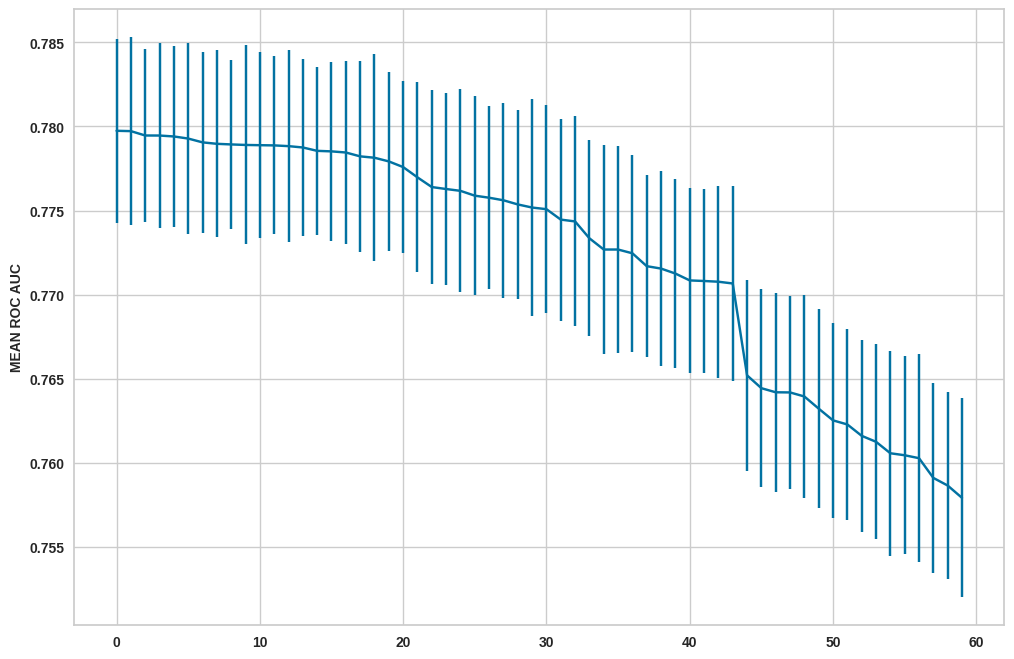

In [144]:
results.sort_values(by='mean_test_roc_auc', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True) 

results['mean_test_roc_auc'].plot(yerr=[results['std_test_roc_auc'], results['std_test_roc_auc']], subplots=True)
plt.ylabel('MEAN ROC AUC', fontsize=10, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')



### 10.4.4 EVAL BEST RF MODEL

In [145]:
search_xgb.best_estimator_

Pipeline(steps=[('rare_encoder',
                 RareLabelEncoder(n_categories=5, replace_with='outros',
                                  variables=['estado_civil'])),
                ('categorical_encoder',
                 MeanEncoder(variables=['dependentes', 'estado_civil',
                                        'cheque_sem_fundo'])),
                ('classifier',
                 XGBClassifier(alpha=0.1, base_score=None, booster=None,
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_b...
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, lambda=0.01,
                               learning_rate=None, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, ...))])

In [146]:
xgb_result = cv_clf_metrics(model=search_xgb.best_estimator_, df=df10_xgb, target='pago', cv=kf, model_name='xgb', search=False)

TRAIN DATA
accuracy: [0.72, 0.722, 0.725, 0.72, 0.719] / media: 0.721 / std: 0.002
balanced_accuracy: [0.733, 0.73, 0.73, 0.73, 0.729] / media: 0.73 / std: 0.001
roc_auc: [0.806, 0.803, 0.804, 0.803, 0.803] / media: 0.804 / std: 0.001
f1_class_0: [0.8, 0.802, 0.805, 0.801, 0.799] / media: 0.801 / std: 0.002
f1_class_1: [0.535, 0.532, 0.533, 0.532, 0.53] / media: 0.532 / std: 0.002
precision_class_0: [0.915, 0.912, 0.911, 0.912, 0.912] / media: 0.912 / std: 0.001
precision_class_1: [0.414, 0.415, 0.418, 0.413, 0.411] / media: 0.414 / std: 0.002
recall_class_0: [0.71, 0.717, 0.721, 0.714, 0.711] / media: 0.715 / std: 0.004
recall_class_1: [0.756, 0.743, 0.738, 0.745, 0.746] / media: 0.746 / std: 0.006

-----------------------------------------------------------------

TEST DATA
accuracy: [0.705, 0.714, 0.715, 0.71, 0.707] / media: 0.71 / std: 0.004
balanced_accuracy: [0.706, 0.719, 0.712, 0.718, 0.716] / media: 0.714 / std: 0.005
roc_auc: [0.769, 0.782, 0.783, 0.782, 0.783] / media: 0.78

Model Name   Accuracy CV balanced_accuracy CV Roc Auc Score CV  \
0        xgb  0.71+/-0.004        0.714+/-0.005     0.78+/-0.005   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0        0.904+/-0.003          0.4+/-0.004     0.707+/-0.006   

  Recall Class 1 CV  F1 Class 0 CV  F1 Class 1 CV  
0     0.721+/-0.011  0.793+/-0.003  0.515+/-0.005

### 10.4.5 TEST SET METRICS

In [147]:
test_set = pd.read_csv(config['data']['test_path'])
test_set = test_set[df10_xgb.columns]
x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

     Predito     0     1   All
Real                          
0             5458  2188  7646
1              565  1503  2068
All           6023  3691  9714



              precision    recall  f1-score   support

           0       0.91      0.71      0.80      7646
           1       0.41      0.73      0.52      2068

    accuracy                           0.72      9714
   macro avg       0.66      0.72      0.66      9714
weighted avg       0.80      0.72      0.74      9714



ROC_AUC 0.79


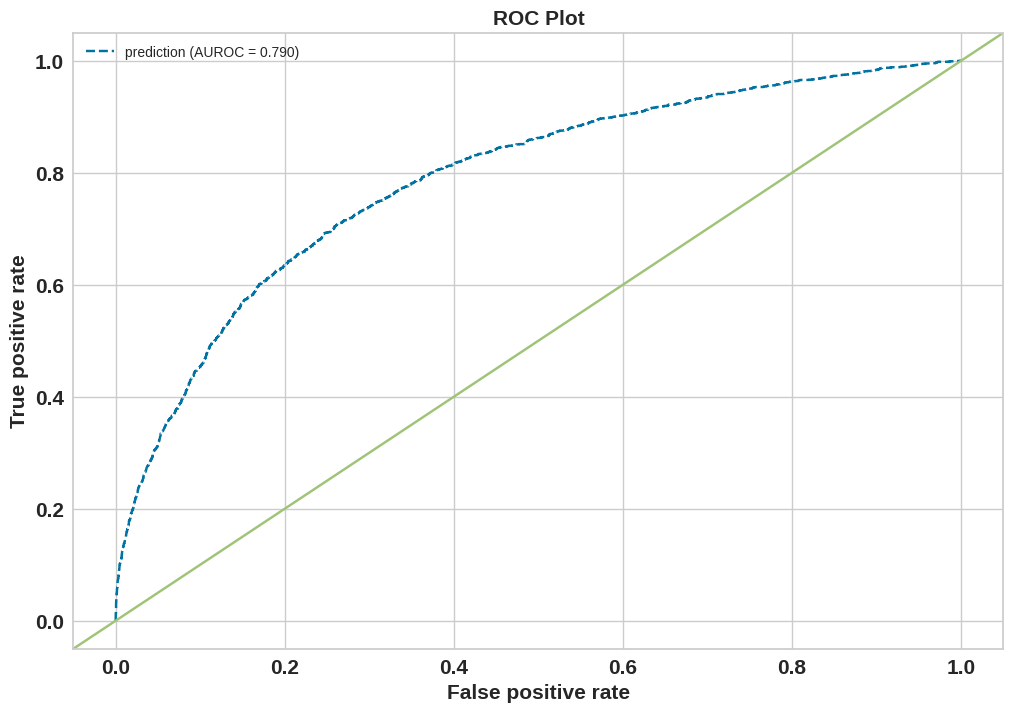

     Predito     0     1   All
Real                          
0             5915  1731  7646
1              697  1371  2068
All           6612  3102  9714



              precision    recall  f1-score   support

           0       0.89      0.77      0.83      7646
           1       0.44      0.66      0.53      2068

    accuracy                           0.75      9714
   macro avg       0.67      0.72      0.68      9714
weighted avg       0.80      0.75      0.77      9714





In [148]:
cm_roc_plot(search_xgb.best_estimator_, x_test, y_test, th=0.55)

# 11.0 COMPARE MODELS

In [149]:
train_set = pd.read_csv(config['data']['train_path'])
test_set = pd.read_csv(config['data']['test_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']

test_set = test_set[columns_select].copy()
train_set = test_set[columns_select].copy()

x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

x_train = train_set.drop('pago', axis='columns')
y_train = train_set['pago']

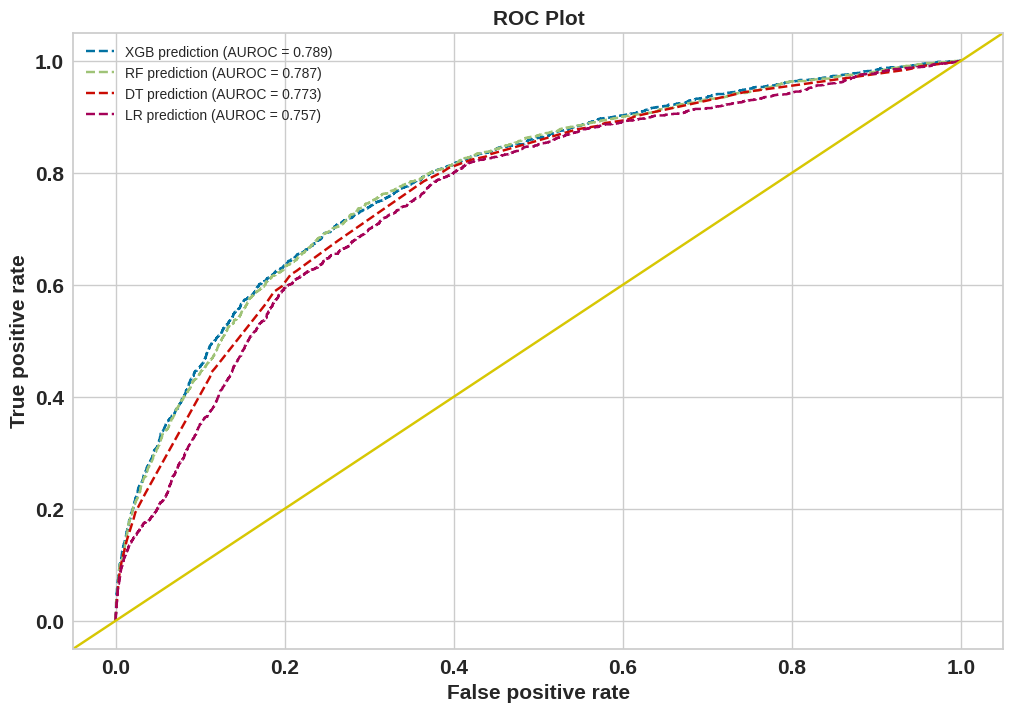

In [150]:
XGB_prob = search_xgb.best_estimator_.predict_proba(x_test)[:,1]
LR_prob = search_lr.best_estimator_.predict_proba(x_test.drop('idade', axis='columns'))[:,1]
RF_prob = search_rf.best_estimator_.predict_proba(x_test)[:,1]
DT_prob = search_dt.best_estimator_.predict_proba(x_test.drop('idade', axis='columns'))[:,1]

XGB_auc = metrics.roc_auc_score(y_test, XGB_prob)
LR_auc = metrics.roc_auc_score(y_test, LR_prob)
RF_auc = metrics.roc_auc_score(y_test, RF_prob)
DT_auc = metrics.roc_auc_score(y_test, DT_prob)

XGB_frp, XGB_tpr, _ = metrics.roc_curve(y_test, XGB_prob)
RF_frp, RF_tpr, _ = metrics.roc_curve(y_test, RF_prob)
DT_frp, DT_tpr, _ = metrics.roc_curve(y_test, DT_prob)
LR_frp, LR_tpr, _ = metrics.roc_curve(y_test, LR_prob)


fig, ax = plt.subplots(figsize=(12,8))


plt.plot(XGB_frp, XGB_tpr, linestyle='--', label ='XGB prediction (AUROC = %0.3f)' %XGB_auc)
plt.plot(RF_frp, RF_tpr, linestyle='--', label ='RF prediction (AUROC = %0.3f)' %RF_auc)
plt.plot(DT_frp, DT_tpr, linestyle='--', label ='DT prediction (AUROC = %0.3f)' %DT_auc)
plt.plot(LR_frp, LR_tpr, linestyle='--', label ='LR prediction (AUROC = %0.3f)' %LR_auc)
ax.plot([0,1],[0,1], transform=ax.transAxes)

# Title
plt.title('ROC Plot', fontsize=15, weight='bold')

# Axis labels
plt.xticks(fontsize=15, weight='bold')
plt.yticks(fontsize=15, weight='bold')

# recall class 0 - 1 True positive rate (TP / (TP + FN))
plt.ylabel('True positive rate', fontsize=15, weight='bold')

# recall class 0 - 1 False positive rate (FP / (FP + TN))
plt.xlabel('False positive rate', fontsize=15, weight='bold')

plt.legend()

plt.show()


In [151]:
modelling_result = pd.concat([xgb_result, rf_result, dt_result, lr_result])
modelling_result

Model Name    Accuracy CV balanced_accuracy CV Roc Auc Score CV  \
0        xgb   0.71+/-0.004        0.714+/-0.005     0.78+/-0.005   
0         rf  0.717+/-0.006        0.713+/-0.005    0.778+/-0.005   
0         dt  0.719+/-0.026        0.702+/-0.006    0.766+/-0.006   
0         lr  0.687+/-0.007        0.686+/-0.004    0.745+/-0.003   

  Precision Class 0 CV Precision Class 1 CV Recall Class 0 CV  \
0        0.904+/-0.003          0.4+/-0.004     0.707+/-0.006   
0          0.9+/-0.003        0.406+/-0.006       0.72+/-0.01   
0        0.892+/-0.005        0.406+/-0.023     0.732+/-0.041   
0         0.89+/-0.004        0.372+/-0.006     0.688+/-0.013   

  Recall Class 1 CV  F1 Class 0 CV  F1 Class 1 CV  
0     0.721+/-0.011  0.793+/-0.003  0.515+/-0.005  
0     0.706+/-0.015    0.8+/-0.006  0.515+/-0.005  
0     0.672+/-0.032  0.803+/-0.024  0.505+/-0.011  
0     0.685+/-0.018  0.776+/-0.008  0.482+/-0.005

In [152]:
result_xgb = test_metric(search_xgb.best_estimator_, x_test, y_test, 'xgb')
result_rf = test_metric(search_rf.best_estimator_, x_test, y_test, 'rf')
result_dt = test_metric(search_dt.best_estimator_, x_test.drop('idade',axis='columns'), y_test, 'dt')
result_lr = test_metric(search_lr.best_estimator_, x_test.drop('idade',axis='columns'), y_test, 'lr')

modeliing_result_test = pd.concat([result_xgb, result_rf, result_dt, result_lr])
modeliing_result_test

precision_0  precision_1  recall_0  recall_1   f1_0   f1_1  accuracy  \
0        0.906        0.407     0.714     0.727  0.799  0.522     0.717   
0        0.903        0.416     0.730     0.711  0.808  0.525     0.726   
0        0.895        0.411     0.736     0.679  0.808  0.512     0.724   
0        0.898        0.382     0.688     0.712  0.779  0.497     0.693   

   roc_auc  balanced_accuracy model_name  
0    0.789              0.720        xgb  
0    0.787              0.721         rf  
0    0.773              0.708         dt  
0    0.757              0.700         lr

# 12.0 INTERPRETABILIDADE COM SHAP

## 12.1 XGBOOST

### 12.1.1 FIT AND PREDICT SHAP

In [293]:
train_set = pd.read_csv(config['data']['train_path'])
test_set = pd.read_csv(config['data']['test_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']

test_set = test_set[columns_select].copy()
train_set = test_set[columns_select].copy()

x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

x_train = train_set.drop('pago', axis='columns')
y_train = train_set['pago']

In [294]:
search_xgb.best_estimator_.named_steps

{'rare_encoder': RareLabelEncoder(n_categories=5, replace_with='outros',
                  variables=['estado_civil']),
 'categorical_encoder': MeanEncoder(variables=['dependentes', 'estado_civil', 'cheque_sem_fundo']),
 'classifier': XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=False, eta=0.03, eval_metric=None,
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None, lambda=0.01,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
               max_leaves=None, min_child_weight=3, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=200, ...)}

In [295]:
search_xgb.best_estimator_.named_steps['categorical_encoder'].encoder_dict_

{'dependentes': {'N': 0.27657761515713497, 'S': 0.09882310663911598},
 'estado_civil': {'casado(a) com comunhao de bens': 0.23026718335712829,
  'casado(a) com comunhao parcial de bens': 0.388116458704694,
  'outros': 0.2746858168761221,
  'solteiro': 0.11513513513513514},
 'cheque_sem_fundo': {'N': 0.09525159461374912, 'S': 0.24747159445623673}}

In [296]:
x_test = search_xgb.best_estimator_.named_steps['rare_encoder'].transform(x_test)
x_test = search_xgb.best_estimator_.named_steps['categorical_encoder'].transform(x_test)

x_train = search_xgb.best_estimator_.named_steps['rare_encoder'].transform(x_train)
x_train = search_xgb.best_estimator_.named_steps['categorical_encoder'].transform(x_train)

In [297]:
xgb = search_xgb.best_estimator_.named_steps['classifier'].fit(x_train, y_train)

In [298]:
explainer_xgb = shap.TreeExplainer(xgb)
shap_values = explainer_xgb(x_test)

In [159]:
shap_values.values

array([[-0.31327015, -0.40347067, -0.54345036,  0.26432616, -0.5030517 ],
       [ 0.15682761,  0.17484528,  0.25761026,  0.12876216,  0.1770631 ],
       [-0.3432652 , -0.52338856, -0.6847022 , -0.05685513, -0.83413374],
       ...,
       [-0.3916653 , -0.7422375 ,  0.09531884, -0.01606539, -0.28344455],
       [ 0.08160966,  0.71412766,  0.26377782, -0.28033987,  0.92654794],
       [ 0.24696726, -0.66523826,  0.2137641 , -0.18598148, -0.08934311]],
      dtype=float32)

In [160]:
shap_values

.values =
array([[-0.31327015, -0.40347067, -0.54345036,  0.26432616, -0.5030517 ],
       [ 0.15682761,  0.17484528,  0.25761026,  0.12876216,  0.1770631 ],
       [-0.3432652 , -0.52338856, -0.6847022 , -0.05685513, -0.83413374],
       ...,
       [-0.3916653 , -0.7422375 ,  0.09531884, -0.01606539, -0.28344455],
       [ 0.08160966,  0.71412766,  0.26377782, -0.28033987,  0.92654794],
       [ 0.24696726, -0.66523826,  0.2137641 , -0.18598148, -0.08934311]],
      dtype=float32)

.base_values =
array([0.17311981, 0.17311981, 0.17311981, ..., 0.17311981, 0.17311981,
       0.17311981], dtype=float32)

.data =
array([[9.88231066e-02, 1.15135135e-01, 9.52515946e-02, 2.30000000e+01,
        3.45680000e+03],
       [2.76577615e-01, 2.30267183e-01, 2.47471594e-01, 3.50000000e+01,
        1.40150900e+04],
       [9.88231066e-02, 1.15135135e-01, 9.52515946e-02, 2.90000000e+01,
        6.57705000e+03],
       ...,
       [9.88231066e-02, 1.15135135e-01, 2.47471594e-01, 3.10000000e+01,
     

<Axes: ylabel='Count'>

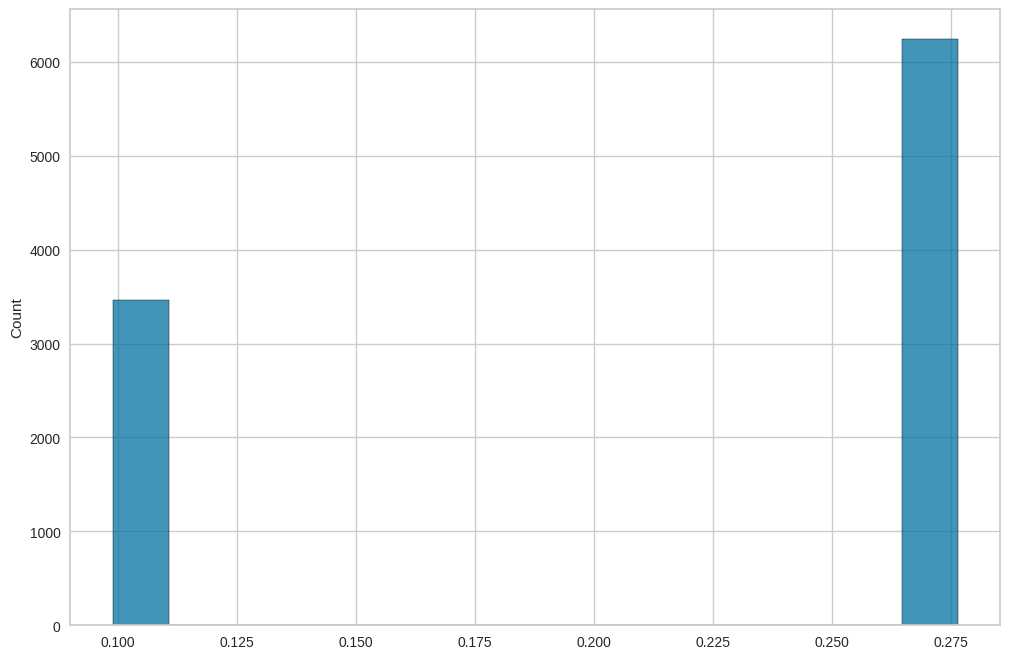

In [161]:
sns.histplot(shap_values.data[:,0])

<Axes: ylabel='Count'>

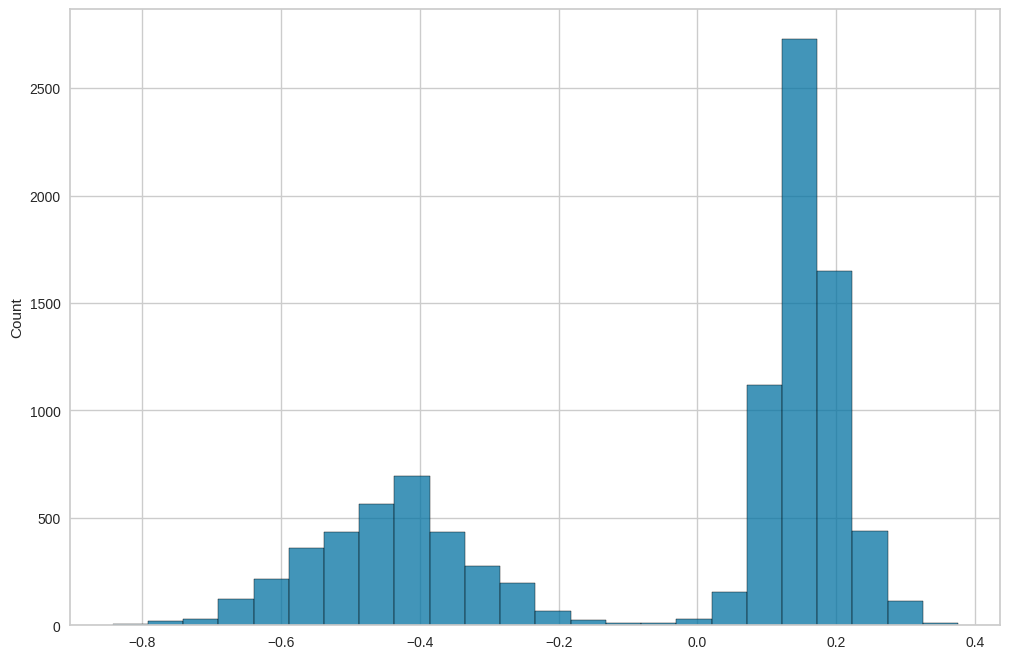

In [162]:
sns.histplot(shap_values.values[:,0])

### 12.1.2 SUMMARY PLOT (RESUMO)

In [163]:
search_xgb.best_estimator_.named_steps['categorical_encoder'].encoder_dict_

{'dependentes': {'N': 0.27657761515713497, 'S': 0.09882310663911598},
 'estado_civil': {'casado(a) com comunhao de bens': 0.23026718335712829,
  'casado(a) com comunhao parcial de bens': 0.388116458704694,
  'outros': 0.2746858168761221,
  'solteiro': 0.11513513513513514},
 'cheque_sem_fundo': {'N': 0.09525159461374912, 'S': 0.24747159445623673}}

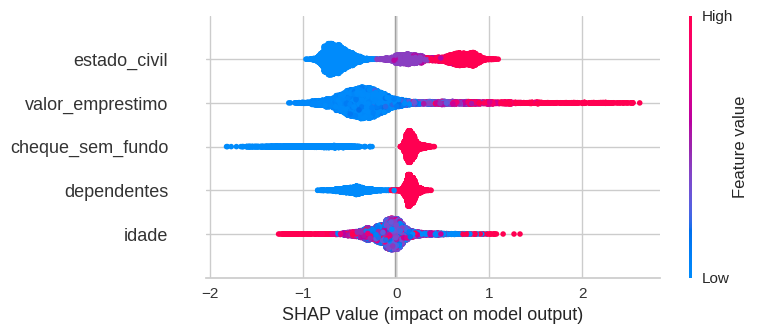

In [164]:
shap.summary_plot(shap_values, x_test)

### 12.1.3 WATERFALL (  CONTRIBUIÇOES INDIVIDUAIS)

In [165]:
x_test.head()

dependentes  estado_civil  cheque_sem_fundo  idade  valor_emprestimo
0     0.098823      0.115135          0.095252     23           3456.80
1     0.276578      0.230267          0.247472     35          14015.09
2     0.098823      0.115135          0.095252     29           6577.05
3     0.098823      0.115135          0.095252     31          44760.10
4     0.276578      0.115135          0.095252     33          36560.00

In [166]:
test_set.head()

dependentes                    estado_civil cheque_sem_fundo  idade  \
0           S                        solteiro                N     23   
1           N  casado(a) com comunhao de bens                S     35   
2           S                        solteiro                N     29   
3           S                        solteiro                N     31   
4           N                        solteiro                N     33   

   valor_emprestimo  pago  
0           3456.80     0  
1          14015.09     0  
2           6577.05     0  
3          44760.10     0  
4          36560.00     0

In [167]:
search_xgb.best_estimator_.named_steps['categorical_encoder'].encoder_dict_

{'dependentes': {'N': 0.27657761515713497, 'S': 0.09882310663911598},
 'estado_civil': {'casado(a) com comunhao de bens': 0.23026718335712829,
  'casado(a) com comunhao parcial de bens': 0.388116458704694,
  'outros': 0.2746858168761221,
  'solteiro': 0.11513513513513514},
 'cheque_sem_fundo': {'N': 0.09525159461374912, 'S': 0.24747159445623673}}

In [168]:
shap_values[0]

.values =
array([-0.31327015, -0.40347067, -0.54345036,  0.26432616, -0.5030517 ],
      dtype=float32)

.base_values =
0.17311981

.data =
array([9.88231066e-02, 1.15135135e-01, 9.52515946e-02, 2.30000000e+01,
       3.45680000e+03])

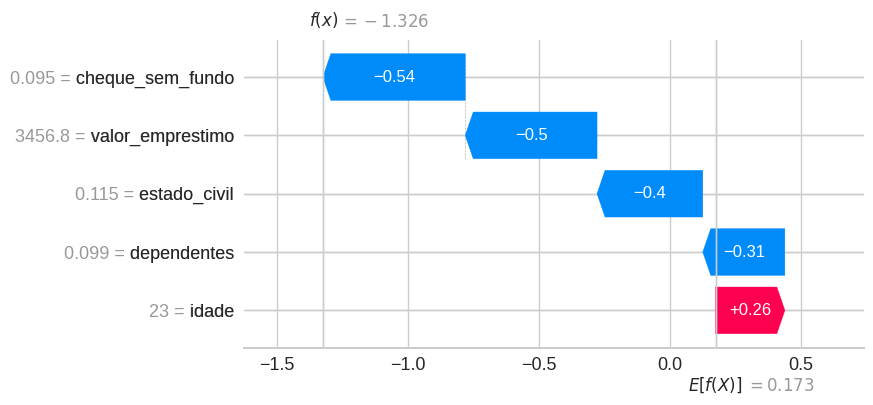

In [169]:
shap.plots.waterfall(shap_values[0])

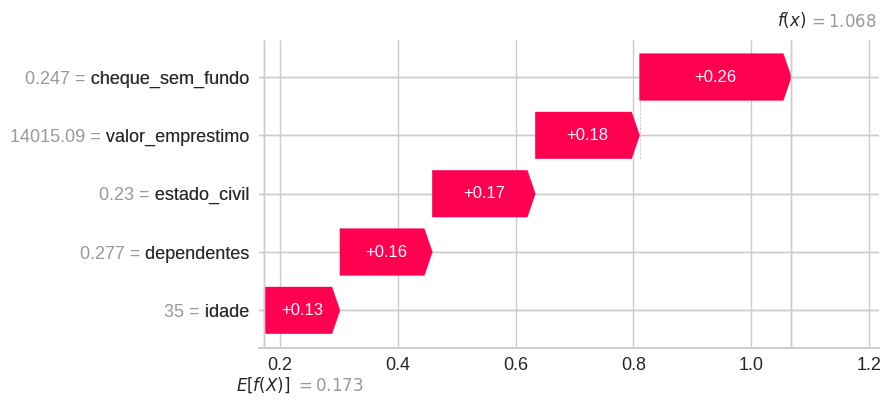

In [170]:
shap.plots.waterfall(shap_values[1])

In [171]:
shap.initjs()
shap.force_plot(shap_values[0])

### 12.1.4 EDA

#### 12.1.4.1 VALOR DO EMPRESTIMO

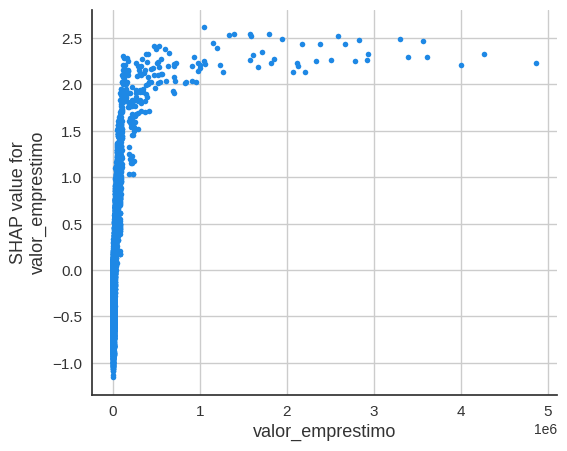

In [172]:
shap.dependence_plot('valor_emprestimo', shap_values.values, x_test, interaction_index=None)

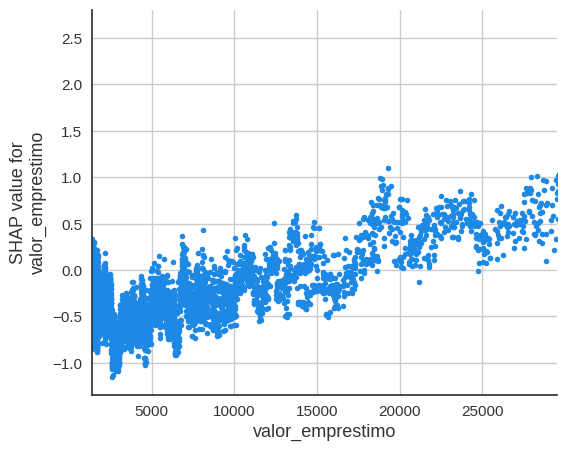

In [173]:
shap.dependence_plot('valor_emprestimo', shap_values.values, x_test, interaction_index=None, xmin='percentile(1)', xmax='percentile(90)')

In [174]:
df_shap_xgb = pd.DataFrame(shap_values.values, columns=x_test.columns)
df_shap_xgb = df_shap_xgb.add_suffix('_shap')

In [175]:
df_shap_xgb

dependentes_shap  estado_civil_shap  cheque_sem_fundo_shap  idade_shap  \
0            -0.313270          -0.403471              -0.543450    0.264326   
1             0.156828           0.174845               0.257610    0.128762   
2            -0.343265          -0.523389              -0.684702   -0.056855   
3            -0.253430          -0.512866              -0.667640    0.063591   
4             0.108056          -0.590177              -1.109537   -0.003177   
...                ...                ...                    ...         ...   
9709         -0.628602          -0.678358               0.141686   -0.370726   
9710          0.201142          -0.655616               0.160162   -0.248769   
9711         -0.391665          -0.742238               0.095319   -0.016065   
9712          0.081610           0.714128               0.263778   -0.280340   
9713          0.246967          -0.665238               0.213764   -0.185981   

      valor_emprestimo_shap  
0                 -0.503052  
1                  0.177063  
2                 -0.834134  
3                  1.160758  
4                  0.384374  
...                     ...  
9709              -0.579719  
9710              -0.676246  
9711              -0.283445  
9712               0.926548  
9713              -0.089343  

[9714 rows x 5 columns]

In [176]:
test_set_shap = pd.concat([test_set, df_shap_xgb], axis='columns')

In [177]:
test_set_shap

dependentes                            estado_civil cheque_sem_fundo  \
0              S                                solteiro                N   
1              N          casado(a) com comunhao de bens                S   
2              S                                solteiro                N   
3              S                                solteiro                N   
4              N                                solteiro                N   
...          ...                                     ...              ...   
9709           S                                solteiro                S   
9710           N                                solteiro                S   
9711           S                                solteiro                S   
9712           N  casado(a) com comunhao parcial de bens                S   
9713           N                                solteiro                S   

      idade  valor_emprestimo  pago  dependentes_shap  estado_civil_shap  \
0        23           3456.80     0         -0.313270          -0.403471   
1        35          14015.09     0          0.156828           0.174845   
2        29           6577.05     0         -0.343265          -0.523389   
3        31          44760.10     0         -0.253430          -0.512866   
4        33          36560.00     0          0.108056          -0.590177   
...     ...               ...   ...               ...                ...   
9709     34           4771.25     0         -0.628602          -0.678358   
9710     48           1493.00     0          0.201142          -0.655616   
9711     31           1685.00     1         -0.391665          -0.742238   
9712     37          29584.17     1          0.081610           0.714128   
9713     27          10199.52     0          0.246967          -0.665238   

      cheque_sem_fundo_shap  idade_shap  valor_emprestimo_shap  
0                 -0.543450    0.264326              -0.503052  
1                  0.257610    0.128762               0.177063  
2                 -0.684702   -0.056855              -0.834134  
3                 -0.667640    0.063591               1.160758  
4                 -1.109537   -0.003177               0.384374  
...                     ...         ...                    ...  
9709               0.141686   -0.370726              -0.579719  
9710               0.160162   -0.248769              -0.676246  
9711               0.095319   -0.016065              -0.283445  
9712               0.263778   -0.280340               0.926548  
9713               0.213764   -0.185981              -0.089343  

[9714 rows x 11 columns]

In [178]:
test_set_shap[(test_set_shap['valor_emprestimo_shap'] > 0) & (test_set_shap['valor_emprestimo_shap'] < 0.01) & (test_set_shap['valor_emprestimo'] > 10_000)].sort_values('valor_emprestimo', ascending=False)

dependentes                            estado_civil cheque_sem_fundo  \
1471           N  casado(a) com comunhao parcial de bens                S   
3747           N                                solteiro                N   
9624           N         casado(a) com separacao de bens                S   
4884           S                                solteiro                N   
9010           N          casado(a) com comunhao de bens                S   
8310           N          casado(a) com comunhao de bens                S   
4760           N          casado(a) com comunhao de bens                N   
2985           N                                solteiro                S   
1487           S                                solteiro                S   
2881           N          casado(a) com comunhao de bens                S   

      idade  valor_emprestimo  pago  dependentes_shap  estado_civil_shap  \
1471     27          14152.29     1          0.171238           0.712439   
3747     59          13630.19     0          0.160269          -0.461122   
9624     31          13004.22     0          0.123738           0.398970   
4884     20          12344.87     0         -0.388755          -0.589892   
9010     29          11977.81     1          0.196989           0.217041   
8310     29          11863.13     0          0.196989           0.217041   
4760     37          11125.05     0          0.090208           0.190595   
2985     25          10614.90     0          0.242240          -0.637133   
1487     36          10384.30     0         -0.574375          -0.696647   
2881     28          10211.53     0          0.161529           0.232511   

      cheque_sem_fundo_shap  idade_shap  valor_emprestimo_shap  
1471               0.288046   -0.196464               0.007484  
3747              -1.172810   -0.167291               0.004068  
9624               0.204168   -0.107099               0.007214  
4884              -0.667479    0.362511               0.007356  
9010               0.172242   -0.107556               0.004243  
8310               0.172242   -0.107556               0.004243  
4760              -0.957320   -0.151572               0.000093  
2985               0.203371   -0.213942               0.000182  
1487               0.166861   -0.115732               0.003152  
2881               0.161455   -0.079952               0.001293

In [179]:
test_set_shap[(test_set_shap['valor_emprestimo_shap'] > 0) & (test_set_shap['valor_emprestimo_shap'] < 0.01) & (test_set_shap['valor_emprestimo'] > 10_000)].sort_values('valor_emprestimo', ascending=False)['valor_emprestimo'].median()


11920.47

#### 12.1.4.2 IDADE

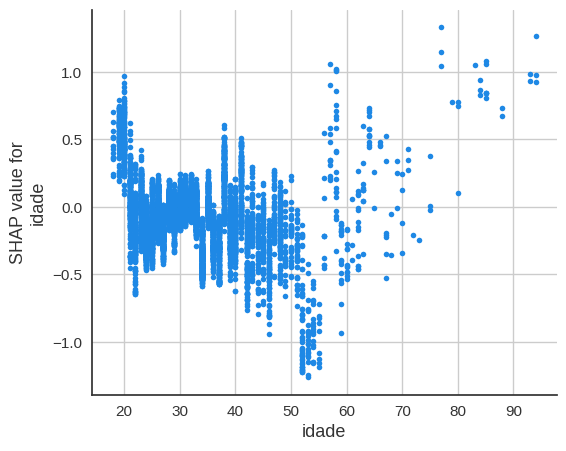

In [180]:
shap.dependence_plot('idade', shap_values.values, x_test, interaction_index=None)

#### 12.1.4.3 ESTADO CIVIL

In [181]:
search_xgb.best_estimator_.named_steps['categorical_encoder'].encoder_dict_

{'dependentes': {'N': 0.27657761515713497, 'S': 0.09882310663911598},
 'estado_civil': {'casado(a) com comunhao de bens': 0.23026718335712829,
  'casado(a) com comunhao parcial de bens': 0.388116458704694,
  'outros': 0.2746858168761221,
  'solteiro': 0.11513513513513514},
 'cheque_sem_fundo': {'N': 0.09525159461374912, 'S': 0.24747159445623673}}

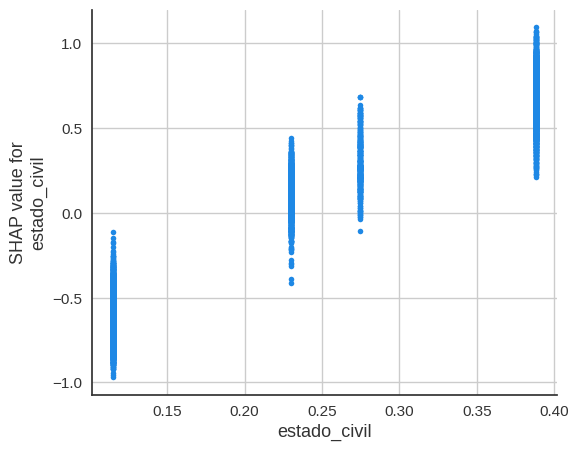

In [182]:
shap.dependence_plot('estado_civil', shap_values.values, x_test, interaction_index=None)


#### 12.1.4.4 CHEQUE SEM FUNDO

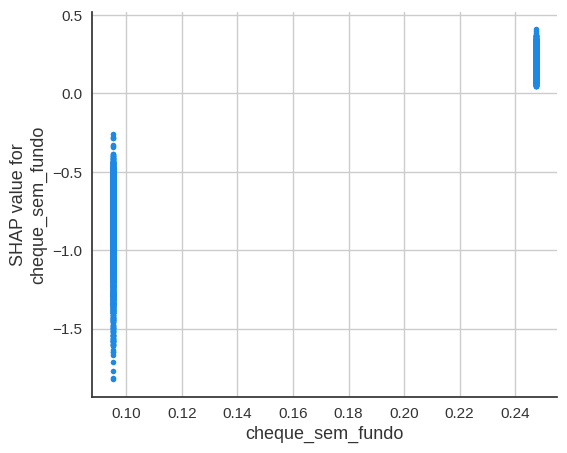

In [183]:
shap.dependence_plot('cheque_sem_fundo', shap_values.values, x_test, interaction_index=None)


#### 12.1.4.5 DEPENDENTES

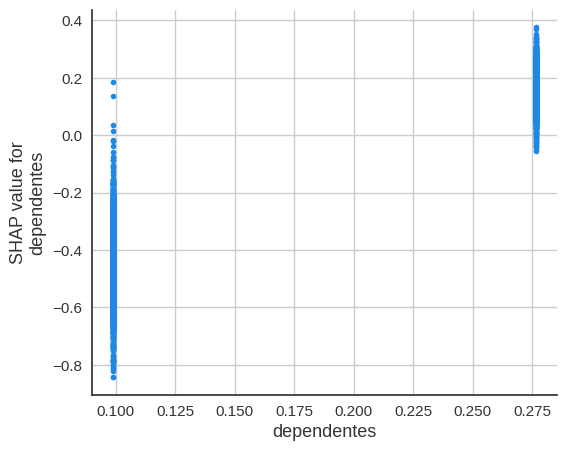

In [184]:
shap.dependence_plot('dependentes', shap_values.values, x_test, interaction_index=None)


#### 12.1.4.6 VALOR DO EMPRESTMO X IDADE

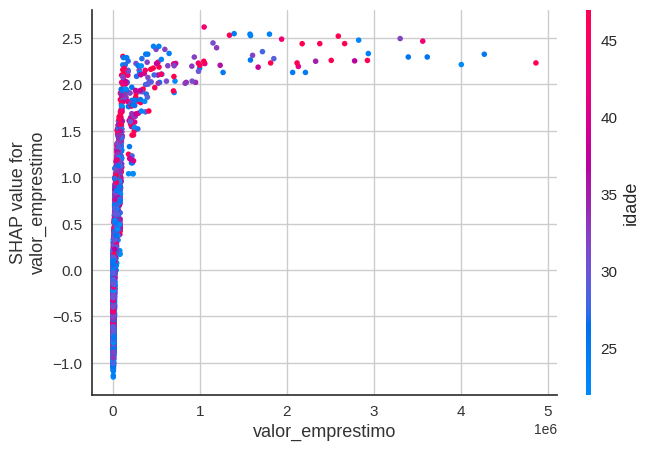

In [185]:
shap.dependence_plot('valor_emprestimo', shap_values.values, x_test, interaction_index='idade')


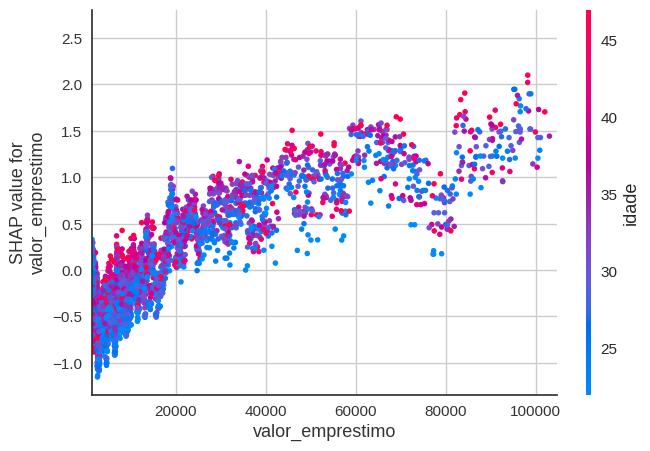

In [186]:
shap.dependence_plot('valor_emprestimo', shap_values.values, x_test, interaction_index='idade', xmin='percentile(1)', xmax='percentile(98)')


#### 12.1.4.7 VALOR DO EMPRESTIMO x CHEQUE SEM FUNDO

In [187]:
search_xgb.best_estimator_.named_steps['categorical_encoder'].encoder_dict_

{'dependentes': {'N': 0.27657761515713497, 'S': 0.09882310663911598},
 'estado_civil': {'casado(a) com comunhao de bens': 0.23026718335712829,
  'casado(a) com comunhao parcial de bens': 0.388116458704694,
  'outros': 0.2746858168761221,
  'solteiro': 0.11513513513513514},
 'cheque_sem_fundo': {'N': 0.09525159461374912, 'S': 0.24747159445623673}}

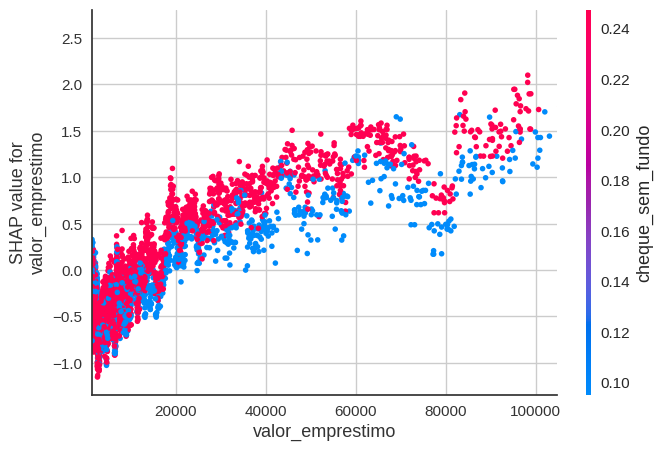

In [188]:
shap.dependence_plot('valor_emprestimo', shap_values.values, x_test, interaction_index='cheque_sem_fundo', xmin='percentile(1)', xmax='percentile(98)')


### 12.1.5 PERFIL ADIMPLETE E INADIMPLETE (CLUSTERING SHAP)

In [189]:
train_set = pd.read_csv(config['data']['train_path'])
test_set = pd.read_csv(config['data']['test_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']

test_set = test_set[columns_select].copy()
train_set = test_set[columns_select].copy()

x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

x_train = train_set.drop('pago', axis='columns')
y_train = train_set['pago']

In [190]:
test_set['pago'] = test_set['pago'].apply(lambda x: 'inadimplente' if x==1 else 'adimplente')
test_set['dependentes'] = test_set['dependentes'].apply(lambda x: 'dependentes_sim' if x == 'S' else 'dependentes_nao' )
test_set['cheque_sem_fundo'] = test_set['cheque_sem_fundo'].apply(lambda x: 'cheque_sim' if x == 'S' else 'cheque_nao' )

In [191]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')

ce_rare.fit(test_set)

test_set = ce_rare.transform(test_set)

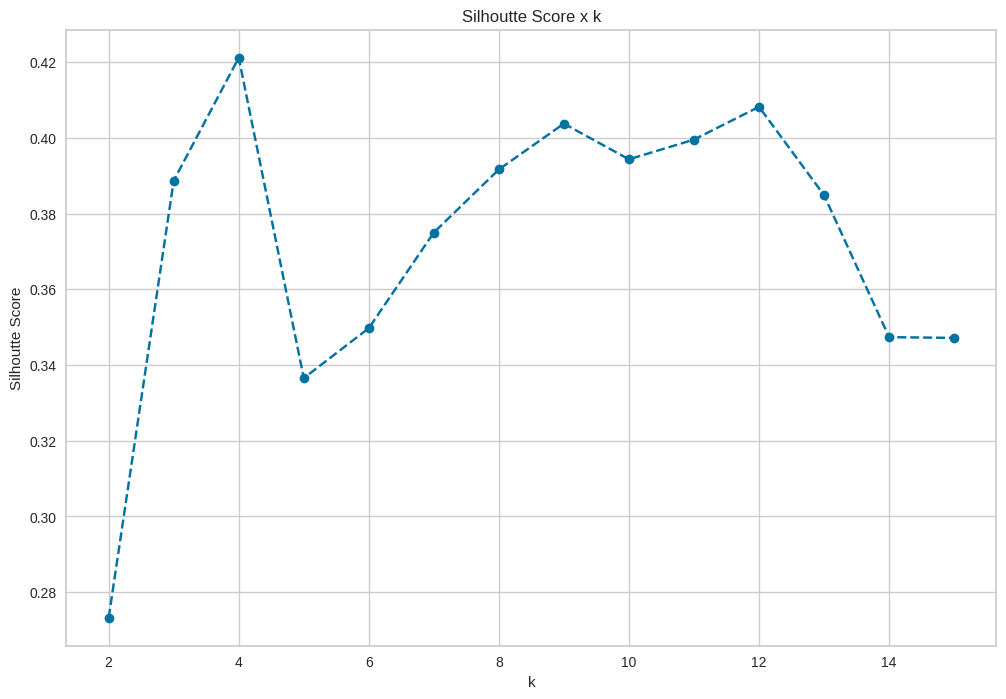

In [192]:
silhoette_score(df_shap_xgb, 'kmeans', 2, 15)

In [193]:
cluster_model = KMeans(n_clusters=10, random_state=config['split']['seed'])
cluster_model.fit(df_shap_xgb)
labels = cluster_model.predict(df_shap_xgb)

In [194]:
test_set['cluster'] = labels

In [195]:
test_set.head()

dependentes                    estado_civil cheque_sem_fundo  idade  \
0  dependentes_sim                        solteiro       cheque_nao     23   
1  dependentes_nao  casado(a) com comunhao de bens       cheque_sim     35   
2  dependentes_sim                        solteiro       cheque_nao     29   
3  dependentes_sim                        solteiro       cheque_nao     31   
4  dependentes_nao                        solteiro       cheque_nao     33   

   valor_emprestimo        pago  cluster  
0           3456.80  adimplente        5  
1          14015.09  adimplente        1  
2           6577.05  adimplente        5  
3          44760.10  adimplente        8  
4          36560.00  adimplente        9

In [196]:
test_set['cluster'] = labels
tabela_resultado_final(test_set)

## 12.2 LOGISTIC REGRESSION

### 12.2.1 FIT AND PREDICT SHAP

In [197]:
train_set = pd.read_csv(config['data']['train_path'])
test_set = pd.read_csv(config['data']['test_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

test_set = test_set[columns_select].copy()
train_set = test_set[columns_select].copy()

x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

x_train = train_set.drop('pago', axis='columns')
y_train = train_set['pago']

In [198]:
search_lr.best_estimator_.named_steps

{'rare_label': RareLabelEncoder(n_categories=5, replace_with='outros',
                  variables=['estado_civil']),
 'preprocessor': ColumnTransformer(transformers=[('onehot_endcoder',
                                  OneHotEncoder(drop_last=True),
                                  ['dependentes', 'cheque_sem_fundo',
                                   'estado_civil']),
                                 ('target_endcoder', MeanEncoder(), []),
                                 ('std_scaler', StandardScaler(), []),
                                 ('yj_scaler', PowerTransformer(),
                                  ['valor_emprestimo'])]),
 'classifier': LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1, random_state=42)}

In [199]:
p1 = search_lr.best_estimator_.named_steps['rare_label'].transform(x_test)
p2 = search_lr.best_estimator_.named_steps['preprocessor'].transform(p1)

In [200]:
pd.DataFrame(p2)

0    1    2    3    4         5
0     0.0  1.0  1.0  0.0  0.0  0.208659
1     1.0  0.0  0.0  1.0  0.0  1.270895
2     0.0  1.0  1.0  0.0  0.0  0.815467
3     0.0  1.0  1.0  0.0  0.0  1.652250
4     1.0  1.0  1.0  0.0  0.0  1.604580
...   ...  ...  ...  ...  ...       ...
9709  0.0  0.0  1.0  0.0  0.0  0.544055
9710  1.0  0.0  1.0  0.0  0.0 -1.075870
9711  0.0  0.0  1.0  0.0  0.0 -0.845254
9712  1.0  0.0  0.0  0.0  1.0  1.547566
9713  1.0  0.0  1.0  0.0  0.0  1.106212

[9714 rows x 6 columns]

In [201]:
yj = PowerTransformer(method='yeo-johnson', standardize=True)

yj.fit(x_train[['valor_emprestimo']].values)
x_train['valor_emprestimo'] = yj.transform(x_train[['valor_emprestimo']].values)
x_test['valor_emprestimo'] = yj.transform(x_test[['valor_emprestimo']].values)

ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)

x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

ce_OHE = OneHotEncoder(variables=['dependentes', 'estado_civil', 'cheque_sem_fundo'], drop_last=True).fit(x_train)

x_train = ce_OHE.transform(x_train)
x_test = ce_OHE.transform(x_test)

lr = search_lr.best_estimator_.named_steps['classifier'].fit(x_train, y_train)

In [202]:
x_test

valor_emprestimo  dependentes_S  estado_civil_solteiro  \
0             0.200930              1                      1   
1             1.261700              0                      0   
2             0.805951              1                      1   
3             1.645179              1                      1   
4             1.597104              0                      1   
...                ...            ...                    ...   
9709          0.535085              1                      1   
9710         -1.074709              0                      1   
9711         -0.846079              1                      1   
9712          1.539670              0                      0   
9713          1.096689              0                      1   

      estado_civil_casado(a) com comunhao de bens  \
0                                               0   
1                                               1   
2                                               0   
3                                               0   
4                                               0   
...                                           ...   
9709                                            0   
9710                                            0   
9711                                            0   
9712                                            0   
9713                                            0   

      estado_civil_casado(a) com comunhao parcial de bens  cheque_sem_fundo_N  
0                                                     0                     1  
1                                                     0                     0  
2                                                     0                     1  
3                                                     0                     1  
4                                                     0                     1  
...                                                 ...                   ...  
9709                                                  0                     0  
9710                                                  0                     0  
9711                                                  0                     0  
9712                                                  1                     0  
9713                                                  0                     0  

[9714 rows x 6 columns]

In [203]:
masker = shap.maskers.Partition(data = x_train)
explainer = shap.LinearExplainer(lr, masker=masker)
shap_values = explainer(x_test)

In [204]:
shap_values

.values =
array([[ 0.08473668, -0.44686136, -0.43767921,  0.01720038, -0.14433093,
        -0.81188757],
       [ 0.50496747,  0.25135952,  0.43767921, -0.12613612, -0.14433093,
         0.21581822],
       [ 0.32441977, -0.44686136, -0.43767921,  0.01720038, -0.14433093,
        -0.81188757],
       ...,
       [-0.33004228, -0.44686136, -0.43767921,  0.01720038, -0.14433093,
         0.21581822],
       [ 0.61508694,  0.25135952,  0.43767921,  0.01720038,  0.33677217,
         0.21581822],
       [ 0.43959728,  0.25135952, -0.43767921,  0.01720038, -0.14433093,
         0.21581822]])

.base_values =
array([-0.20382674, -0.20382674, -0.20382674, ..., -0.20382674,
       -0.20382674, -0.20382674])

.data =
array([[ 0.20092975,  1.        ,  1.        ,  0.        ,  0.        ,
         1.        ],
       [ 1.26170009,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.80595136,  1.        ,  1.        ,  0.        ,  0.        ,
         1.        ],

### 12.2.2 SUMMARY PLOT (RESUMO)

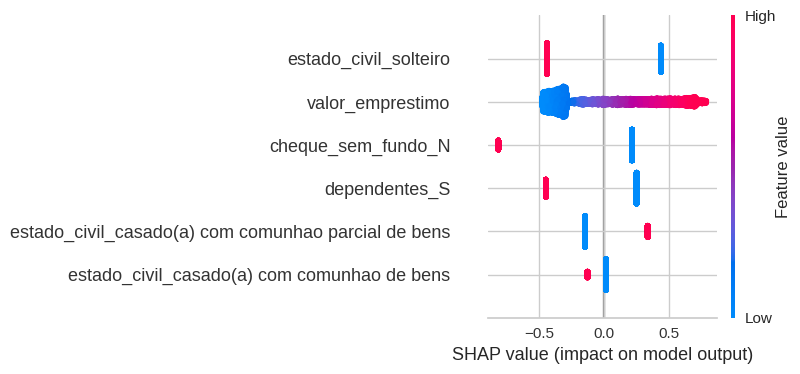

In [205]:
shap.summary_plot(shap_values, x_test)

### 12.2.3 WATERFALL (CONTRIBUIÇOES INDIVISUAIS)

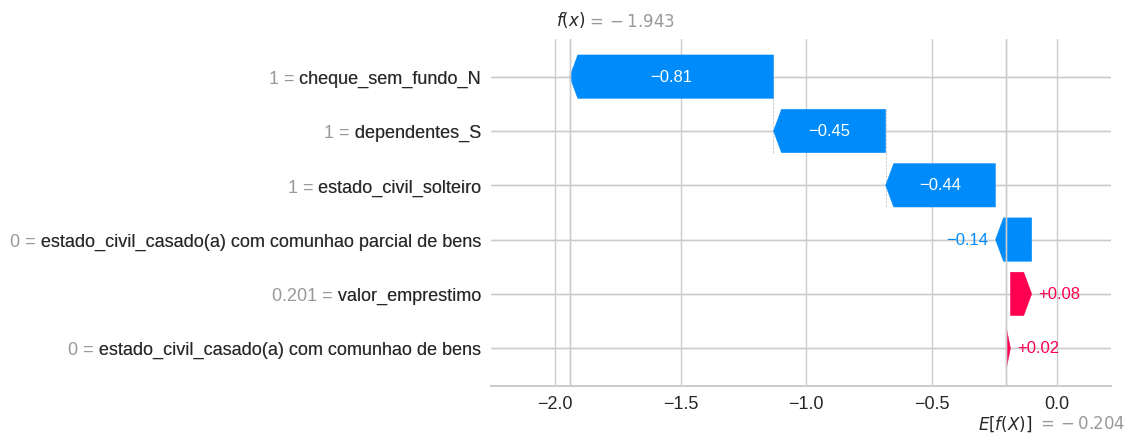

In [206]:
shap.plots.waterfall(shap_values[0])

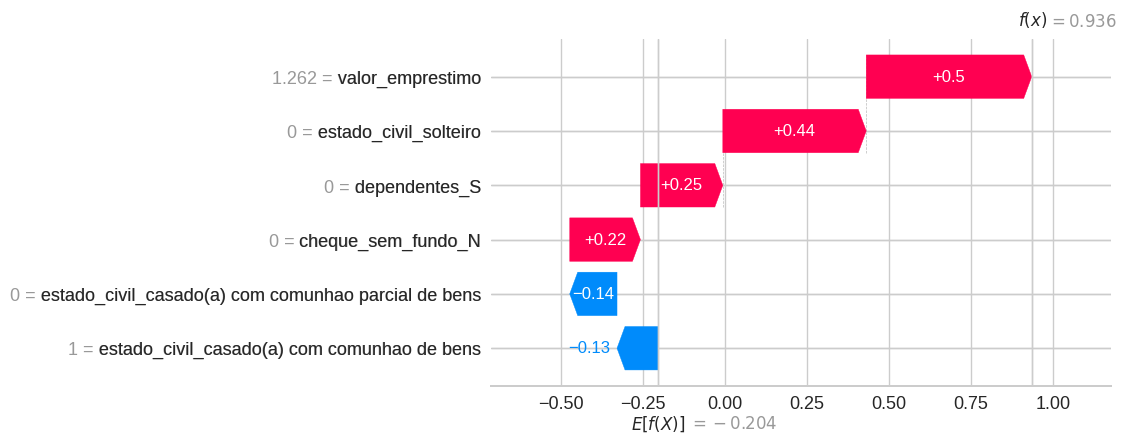

In [207]:
shap.plots.waterfall(shap_values[1])

In [208]:
shap.initjs()
shap.force_plot(shap_values[0])

### 12.2.4 EDA

#### 12.2.4.1 VALOR DO EMPRESTIMO

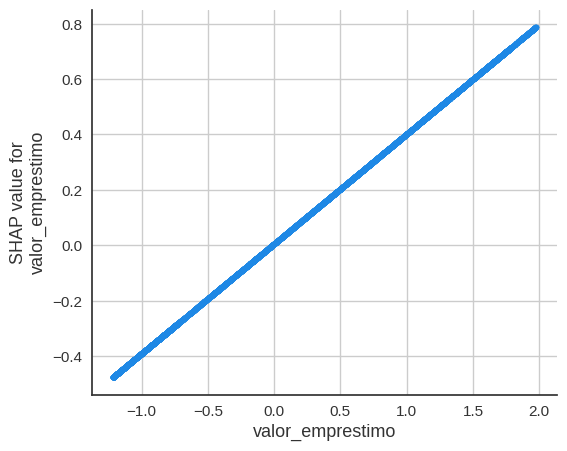

In [209]:
shap.dependence_plot('valor_emprestimo', shap_values.values, x_test, interaction_index=None)

In [210]:
df_shap_lr = pd.DataFrame(shap_values.values, columns=x_test.columns)
df_shap_lr = df_shap_lr.add_suffix('_shap')

test_set_shap = pd.concat([test_set, df_shap_lr], axis='columns')

In [211]:
test_set_shap

dependentes                            estado_civil cheque_sem_fundo  \
0              S                                solteiro                N   
1              N          casado(a) com comunhao de bens                S   
2              S                                solteiro                N   
3              S                                solteiro                N   
4              N                                solteiro                N   
...          ...                                     ...              ...   
9709           S                                solteiro                S   
9710           N                                solteiro                S   
9711           S                                solteiro                S   
9712           N  casado(a) com comunhao parcial de bens                S   
9713           N                                solteiro                S   

      valor_emprestimo  pago  valor_emprestimo_shap  dependentes_S_shap  \
0              3456.80     0               0.084737           -0.446861   
1             14015.09     0               0.504967            0.251360   
2              6577.05     0               0.324420           -0.446861   
3             44760.10     0               0.656885           -0.446861   
4             36560.00     0               0.637840            0.251360   
...                ...   ...                    ...                 ...   
9709           4771.25     0               0.217114           -0.446861   
9710           1493.00     0              -0.420615            0.251360   
9711           1685.00     1              -0.330042           -0.446861   
9712          29584.17     1               0.615087            0.251360   
9713          10199.52     0               0.439597            0.251360   

      estado_civil_solteiro_shap  \
0                      -0.437679   
1                       0.437679   
2                      -0.437679   
3                      -0.437679   
4                      -0.437679   
...                          ...   
9709                   -0.437679   
9710                   -0.437679   
9711                   -0.437679   
9712                    0.437679   
9713                   -0.437679   

      estado_civil_casado(a) com comunhao de bens_shap  \
0                                             0.017200   
1                                            -0.126136   
2                                             0.017200   
3                                             0.017200   
4                                             0.017200   
...                                                ...   
9709                                          0.017200   
9710                                          0.017200   
9711                                          0.017200   
9712                                          0.017200   
9713                                          0.017200   

      estado_civil_casado(a) com comunhao parcial de bens_shap  \
0                                             -0.144331          
1                                             -0.144331          
2                                             -0.144331          
3                                             -0.144331          
4                                             -0.144331          
...                                                 ...          
9709                                          -0.144331          
9710                                          -0.144331          
9711                                          -0.144331          
9712                                           0.336772          
9713                                          -0.144331          

      cheque_sem_fundo_N_shap  
0                   -0.811888  
1                    0.215818  
2                   -0.811888  
3                   -0.811888  
4                   -0.811888  
...                       ...  
9709                 0.215818  


In [212]:
test_set_shap[(test_set_shap['valor_emprestimo_shap'] > 0)].sort_values('valor_emprestimo_shap', ascending=False)

dependentes                            estado_civil cheque_sem_fundo  \
3982           N                                solteiro                S   
2540           N  casado(a) com comunhao parcial de bens                S   
1296           N  casado(a) com comunhao parcial de bens                S   
3616           N  casado(a) com comunhao parcial de bens                S   
5805           S                                solteiro                S   
...          ...                                     ...              ...   
7037           N  casado(a) com comunhao parcial de bens                S   
3160           N          casado(a) com comunhao de bens                S   
3690           N                                solteiro                N   
364            N          casado(a) com comunhao de bens                S   
780            N  casado(a) com comunhao parcial de bens                S   

      valor_emprestimo  pago  valor_emprestimo_shap  dependentes_S_shap  \
3982        4863816.07     1               0.787633            0.251360   
2540        4269994.14     1               0.787039            0.251360   
1296        4005443.42     1               0.786729            0.251360   
3616        3613664.22     1               0.786202            0.251360   
5805        3561731.58     1               0.786125           -0.446861   
...                ...   ...                    ...                 ...   
7037           2904.14     1               0.000956            0.251360   
3160           2902.82     0               0.000724            0.251360   
3690           2902.55     0               0.000677            0.251360   
364            2900.25     0               0.000274            0.251360   
780            2899.11     0               0.000074            0.251360   

      estado_civil_solteiro_shap  \
3982                   -0.437679   
2540                    0.437679   
1296                    0.437679   
3616                    0.437679   
5805                   -0.437679   
...                          ...   
7037                    0.437679   
3160                    0.437679   
3690                   -0.437679   
364                     0.437679   
780                     0.437679   

      estado_civil_casado(a) com comunhao de bens_shap  \
3982                                          0.017200   
2540                                          0.017200   
1296                                          0.017200   
3616                                          0.017200   
5805                                          0.017200   
...                                                ...   
7037                                          0.017200   
3160                                         -0.126136   
3690                                          0.017200   
364                                          -0.126136   
780                                           0.017200   

      estado_civil_casado(a) com comunhao parcial de bens_shap  \
3982                                          -0.144331          
2540                                           0.336772          
1296                                           0.336772          
3616                                           0.336772          
5805                                          -0.144331          
...                                                 ...          
7037                                           0.336772          
3160                                          -0.144331          
3690                                          -0.144331          
364                                           -0.144331          
780                                            0.336772          

      cheque_sem_fundo_N_shap  
3982                 0.215818  
2540                 0.215818  
1296                 0.215818  
3616                 0.215818  
5805                 0.215818  
...                       ...  
7037                 0.215818  


In [213]:
test_set_shap[(test_set_shap['valor_emprestimo_shap'] > 0) & (test_set_shap['valor_emprestimo_shap'] < 0.01)].sort_values('valor_emprestimo', ascending=False)['valor_emprestimo'].median()


2924.17

#### 12.1.4.2 ESTADO CIVIL

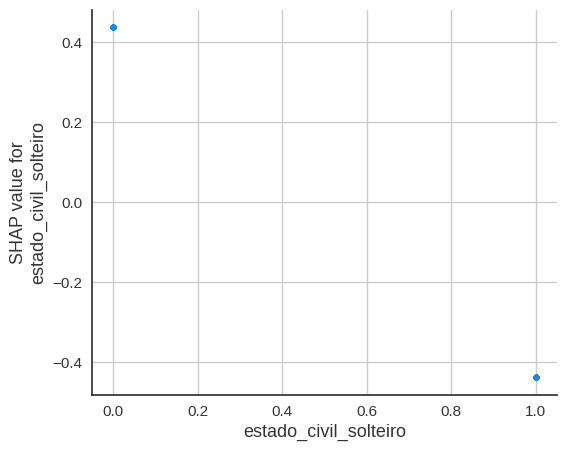

In [214]:
shap.dependence_plot('estado_civil_solteiro', shap_values.values, x_test, interaction_index=None)


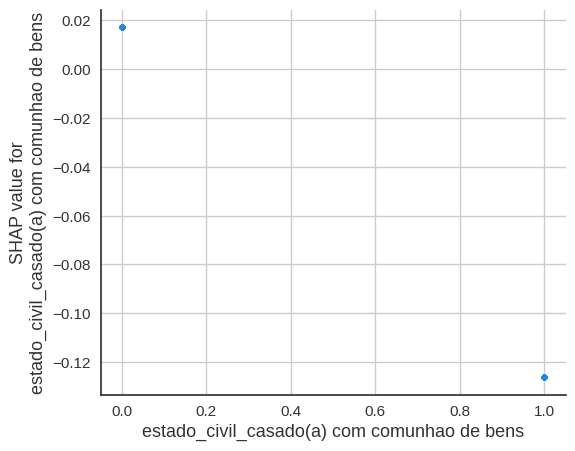

In [215]:
shap.dependence_plot('estado_civil_casado(a) com comunhao de bens', shap_values.values, x_test, interaction_index=None)


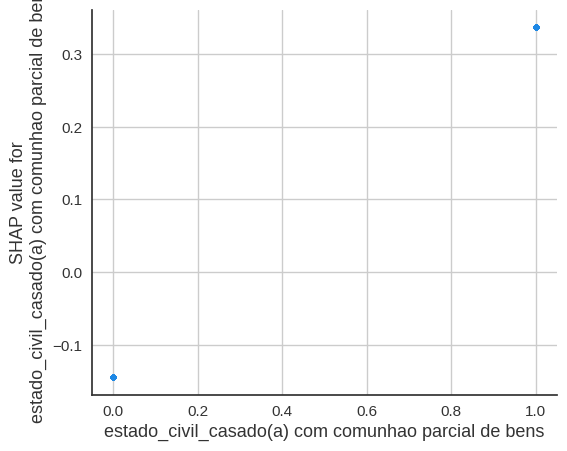

In [216]:
shap.dependence_plot('estado_civil_casado(a) com comunhao parcial de bens', shap_values.values, x_test, interaction_index=None)

#### 12.1.4.3 CHEQUE SEM FUNDO

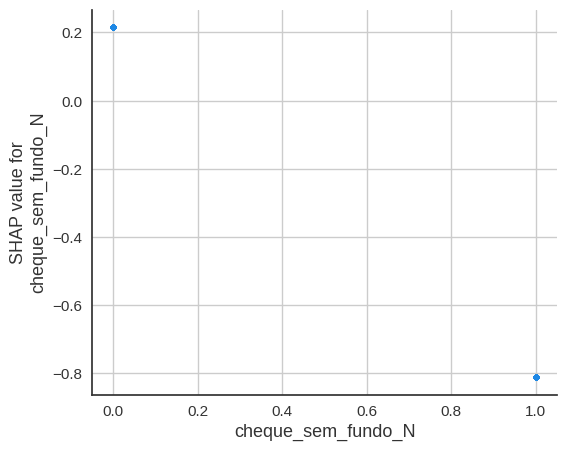

In [217]:
shap.dependence_plot('cheque_sem_fundo_N', shap_values.values, x_test, interaction_index=None)


#### 12.1.4.4 DEPENDENTES

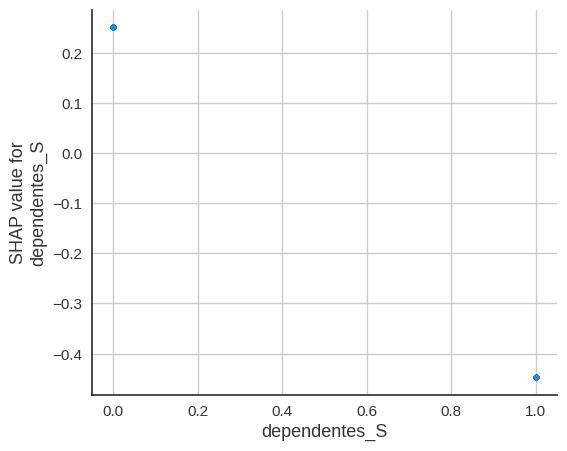

In [218]:
shap.dependence_plot('dependentes_S', shap_values.values, x_test, interaction_index=None)


#### 12.1.4.5 VALOR DO EMPRESTMO X CHEQUE SEM FUNDO

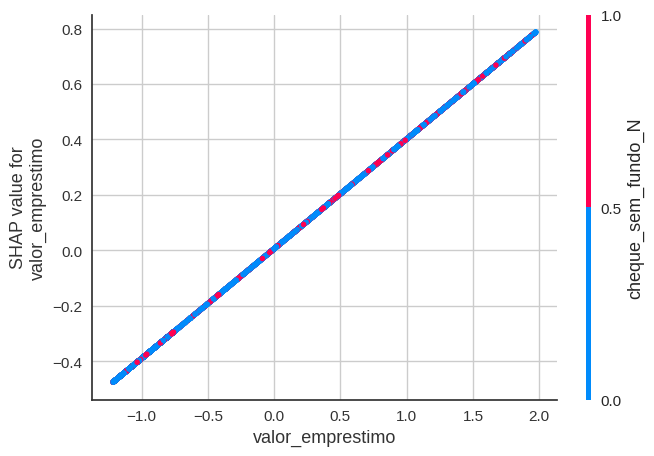

In [219]:
shap.dependence_plot('valor_emprestimo', shap_values.values, x_test, interaction_index='cheque_sem_fundo_N')


### 12.2.5 PERFIL ADIMPLENTE E INADIMPLENTE (CLUSTERING SHAP)

In [220]:
train_set = pd.read_csv(config['data']['train_path'])
test_set = pd.read_csv(config['data']['test_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

test_set = test_set[columns_select].copy()
train_set = test_set[columns_select].copy()

x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

x_train = train_set.drop('pago', axis='columns')
y_train = train_set['pago']

In [221]:
test_set['pago'] = test_set['pago'].apply(lambda x: 'inadimplente' if x==1 else 'adimplente')
test_set['dependentes'] = test_set['dependentes'].apply(lambda x: 'dependentes_sim' if x == 'S' else 'dependentes_nao' )
test_set['cheque_sem_fundo'] = test_set['cheque_sem_fundo'].apply(lambda x: 'cheque_sim' if x == 'S' else 'cheque_nao' )

In [222]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')

ce_rare.fit(test_set)

test_set = ce_rare.transform(test_set)

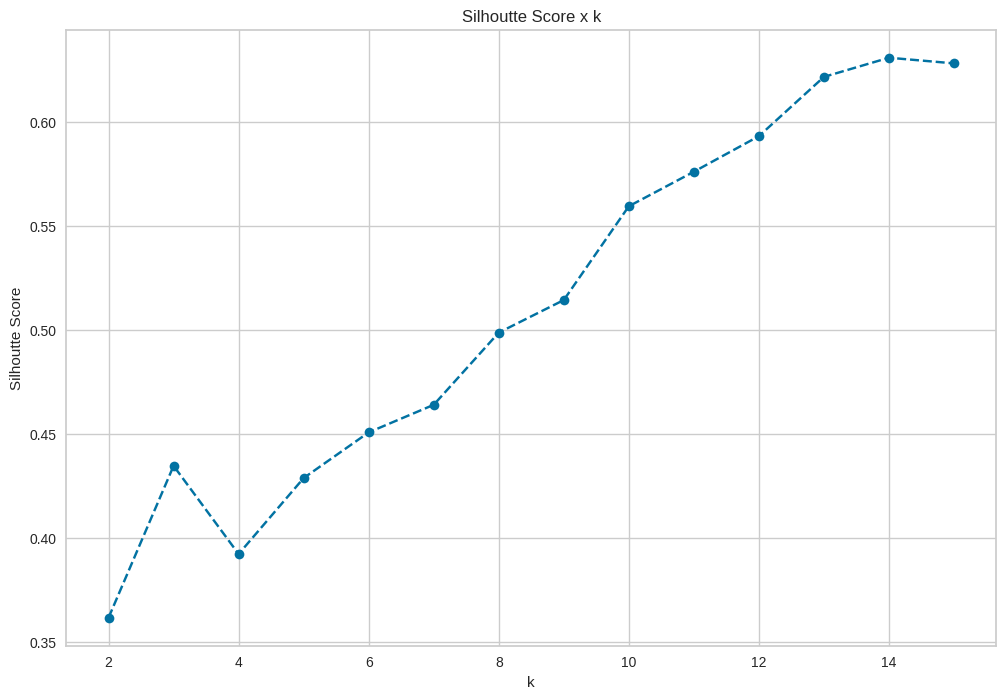

In [223]:
silhoette_score(df_shap_lr, 'kmeans', 2, 15)

In [224]:
cluster_model = KMeans(n_clusters=10, random_state=config['split']['seed'])
cluster_model.fit(df_shap_lr)
labels = cluster_model.predict(df_shap_lr)

In [225]:
test_set['cluster'] = labels
tabela_resultado_final(test_set)

# 13.0 RESULTADO DE NEGÓCIO

In [226]:
test_set = pd.read_csv(config['data']['test_path'])
columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade','valor_emprestimo', 'pago']
test_set = test_set[columns_select]
x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

## 13.1 CURVA AUC ROC CURVE

     Predito     0     1   All
Real                          
0             5568  2078  7646
1              454  1614  2068
All           6022  3692  9714



              precision    recall  f1-score   support

           0       0.92      0.73      0.81      7646
           1       0.44      0.78      0.56      2068

    accuracy                           0.74      9714
   macro avg       0.68      0.75      0.69      9714
weighted avg       0.82      0.74      0.76      9714



ROC_AUC 0.84


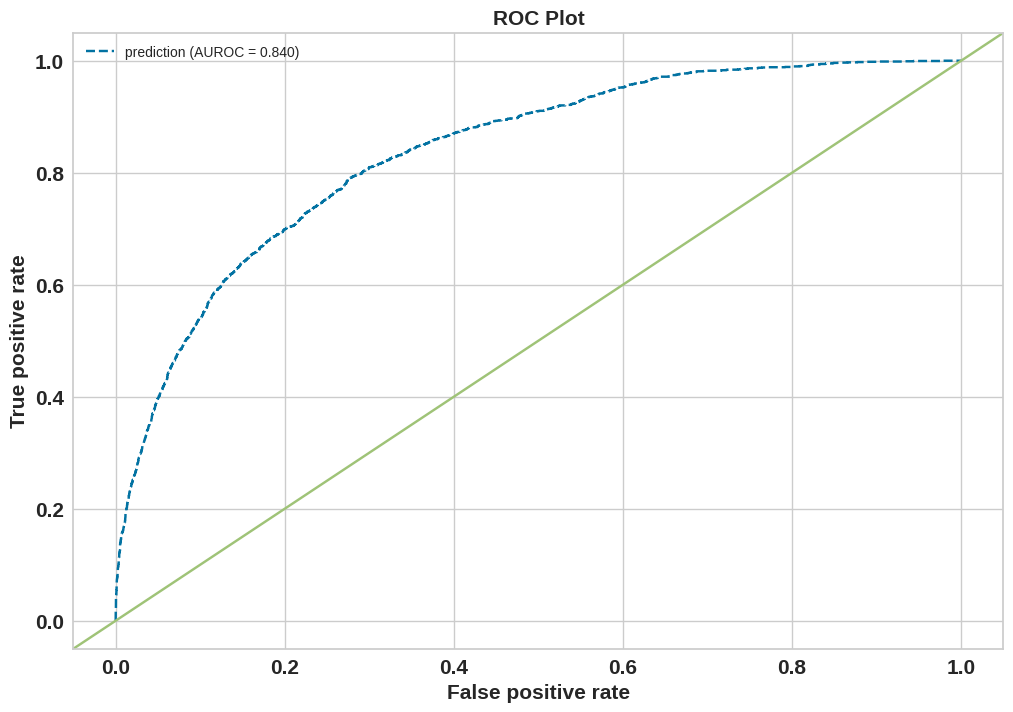

     Predito     0    1   All
Real                         
0             7487  159  7646
1             1544  524  2068
All           9031  683  9714



              precision    recall  f1-score   support

           0       0.83      0.98      0.90      7646
           1       0.77      0.25      0.38      2068

    accuracy                           0.82      9714
   macro avg       0.80      0.62      0.64      9714
weighted avg       0.82      0.82      0.79      9714





In [227]:
cm_roc_plot(search_xgb.best_estimator_, x_test, y_test, th=0.8)

## 13.1 PRECISION RECOLL CURVE

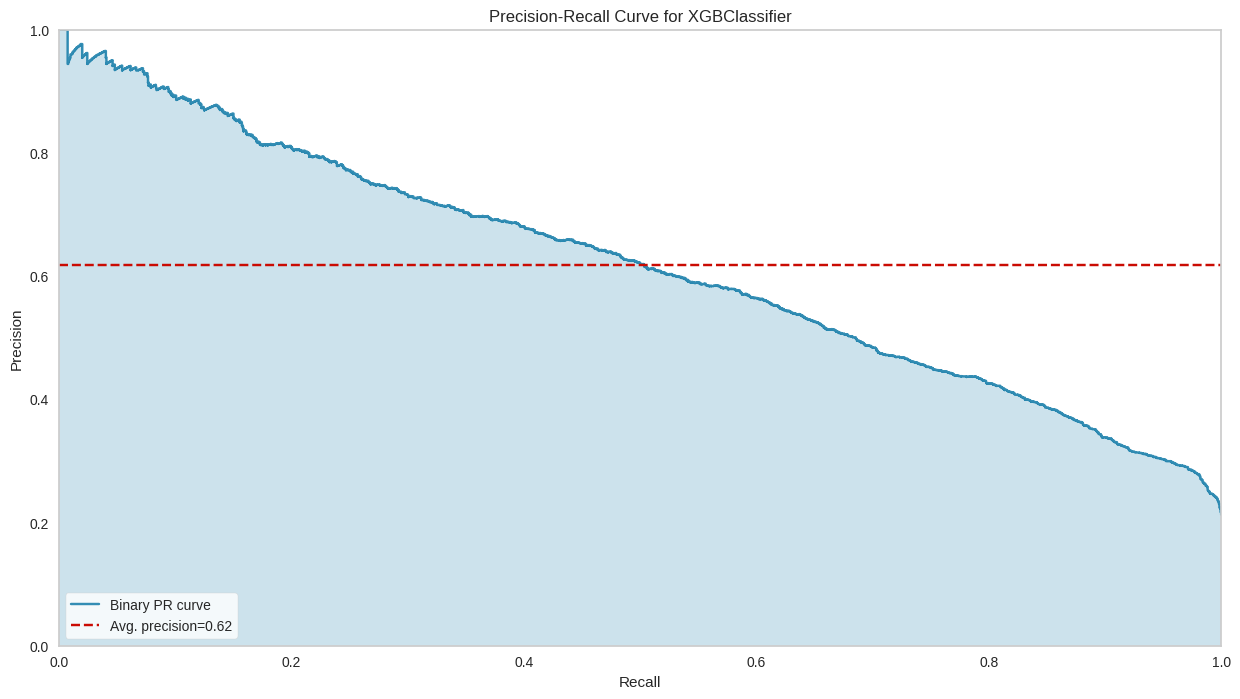

<Axes: title={'center': 'Precision-Recall Curve for XGBClassifier'}, xlabel='Recall', ylabel='Precision'>

In [228]:
plt.figure(figsize=(15,8))
viz = PrecisionRecallCurve(search_xgb.best_estimator_)
viz.fit(x_test, y_test)
viz.score(x_test, y_test)
viz.show()

## 13.3 MAXIMIZANDO ROI

### 13.3.1 CENARIO ATUAL DO BANCO

In [229]:
test_set = pd.read_csv(config['data']['test_path'])

df_business = test_set[['id', 'valor_emprestimo', 'multa', 'juros', 'valor_emprestimo_atualizado', 'pago']].dropna().reset_index(drop=True).copy()

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade','valor_emprestimo', 'pago']
test_set = test_set[columns_select]
x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']


In [230]:
df_business['probabilidade'] = np.round(search_xgb.best_estimator_.predict_proba(x_test)[:,1], 2)
df_business['pred_050'] = (search_xgb.best_estimator_.predict_proba(x_test)[:,1]>0.5).astype(int)

In [231]:
df_banco = df_business.groupby(['pago']).agg(
    valor_emprestimo = ('valor_emprestimo','sum'),
    juros = ('juros','sum'),
    multa = ('multa', 'sum'),
    emprestimo_atualizado = ('valor_emprestimo_atualizado', 'sum'),
).reset_index()

In [232]:
df_banco

pago  valor_emprestimo         juros         multa  emprestimo_atualizado
0     0      8.559284e+07  7.012149e+07  4.027410e+07           1.959884e+08
1     1      1.384250e+08  2.503221e+08  2.401617e+08           6.289088e+08

In [233]:
# cenario pago 0
# o banco emprestou (8.559284e+07)
# o banco ganhou (7.012149e+07 + 4.027410e+07)
# ROI = ((7.012149e+07 + 4.027410e+07) / (8.559284e+07)	)
# ROI = 129%
# Lucro = 110395590

# cenario pago 1
# o banco emprestou (1.384250e+08)
# o banco perdeu (1.384250e+08)
# ROI = 100%
# Lucro = - 138425000

# cenario geral

# o banco emprestou (8.559284e+07 + 1.384250e+08)
# o banco perdeu (1.384250e+08)
# o banco ganhou (7.012149e+07 + 4.027410e+07)

# ROI GERAL ((7.012149e+07 + 4.027410e+07) - (1.384250e+08)) / (8.559284e+07 + 1.384250e+08)
# ROI GERAL = -12.5%
# Lucro Geral = - 28029410



### 13.3.2 CENARIO DO XGBOOST COM TH 0.5

In [234]:
df_050 = df_business.groupby(['pago', 'pred_050']).agg(
    valor_emprestimo = ('valor_emprestimo','sum'),
    juros = ('juros','sum'),
    multa = ('multa', 'sum'),
    emprestimo_atualizado = ('valor_emprestimo_atualizado', 'sum'),
).reset_index()

In [235]:
df_050

pago  pred_050  valor_emprestimo         juros         multa  \
0     0         0      4.008043e+07  2.877924e+07  2.027714e+07   
1     0         1      4.551241e+07  4.134224e+07  1.999696e+07   
2     1         0      2.906639e+06  1.953728e+07  2.978257e+07   
3     1         1      1.355184e+08  2.307848e+08  2.103791e+08   

   emprestimo_atualizado  
0           8.913681e+07  
1           1.068516e+08  
2           5.222649e+07  
3           5.766823e+08

In [236]:
# cenario pago = 0 pred_050 = 0 (acertou corretamente os adimplentes)
# o banco emprestou (4.008043e+07)
# o banco ganhou (2.877924e+07 + 2.027714e+07)
# ROI = (2.877924e+07 + 2.027714e+07) / (4.008043e+07)
# o ROI = 122%
# Lucro = 89759500

# cenario pago = 0 e pred_50 = 1 (cliente adiplente e classificou como inadiplente)(erramos)
# o banco deixou de emprestar (4.551241e+07)
# o banco deixou de Lucrar (4.134224e+07 + 1.999696e+07	)
# o banco deixou de ter um ROI(4.134224e+07 + 1.999696e+07) / (4.551241e+07)
# o banco deixou de ter um Roi = 139%
# Lucro = 69027220

# o banco tem um custo de oportunidade de port exemplo (10%)
# ROI = 10%
# lucro = 4955498

# cenario pago 1 e pred_50 (cliente era inadipllente e classificamos como adiplente (erramos))
# o banco emprestou errado (2.906639e+06)
# o banco perdeu (2.906639e+06)
# ROI= -100%
# Lucro = - 2906639

# cenario pago = 2 e pred_50 1 (Acertou corretamente os onadimplentes)
# o banco deixou de emprestar de forma errada (1.355184e+08)
# ROI = 10%
# Lucro  = 1355184

# cenario geral
# o banco emprestou (4.008043e+07 + 4.551241e+07 + 2.906639e+06 + 1.355184e+08)
# o banco perdeu (- 2906639)
# o banco ganhou (8975950 + 69027220 + 4955498)
# ROI GERAL = (8975950 + 69027220 + 4955498 - 2906639) / (4.008043e+07 + 4.551241e+07 + 2.906639e+06 + 1.355184e+08)
# ROI GERAL = 24,8%
# LUCRO GERAL = 5504839

### 13.3.3 ESCOLHA DO MELHOR TH QUE MAXIMIZA O ROI

In [237]:
def maximizar_roi(x_test, df_business, model, custo_oportunidade):

    roi_list = []
    th_list = [i/100 for i in range(1, 101)]
    lucro_list = []

    for th in th_list:
        df_resultado = df_business.copy()

        df_resultado['pred_' + str(th)] = (model.predict_proba(x_test)[:,1] >= th).astype(int)

        df_aux = df_resultado.groupby(['pago', 'pred_' + str(th)]).agg(
        valor_emprestimo = ('valor_emprestimo','sum'),
        juros = ('juros','sum'),
        multa = ('multa', 'sum'),
        emprestimo_atualizado = ('valor_emprestimo_atualizado', 'sum'),
        ).reset_index()

        if(len(df_aux) < 4 ):
            lucro_geral = 0
            roi = 0
        
        else:
            valor_emprestimo_total = df_aux['valor_emprestimo'].sum()
            lucro_geral = (df_aux['juros'][0] + df_aux['multa'][0]) + (df_aux['valor_emprestimo'][1] * custo_oportunidade) - (df_aux['valor_emprestimo'][2]) + (df_aux['valor_emprestimo'][3] * custo_oportunidade) 
            roi = round(lucro_geral / valor_emprestimo_total, 2)

        
        roi_list.append(roi)
        lucro_list.append(lucro_geral)


    plt.plot(th_list, roi_list, linestyle='--', marker='o', color='b')
    plt.xlabel('TH')
    plt.ylabel('ROI')
    plt.title('ROI X TH')
    plt.show()


    plt.plot(th_list, lucro_list, linestyle='--', marker='o', color='b')
    plt.xlabel('TH')
    plt.ylabel('LUCRO')
    plt.title('LUCRO X TH')
    plt.show()

    print(f'Max ROI value {max(roi_list)}')
    print(f'Max LUCRO {lucro_list[roi_list.index(max(roi_list))]}')
    print(f'BEST TH value {th_list[roi_list.index(max(roi_list))]}')

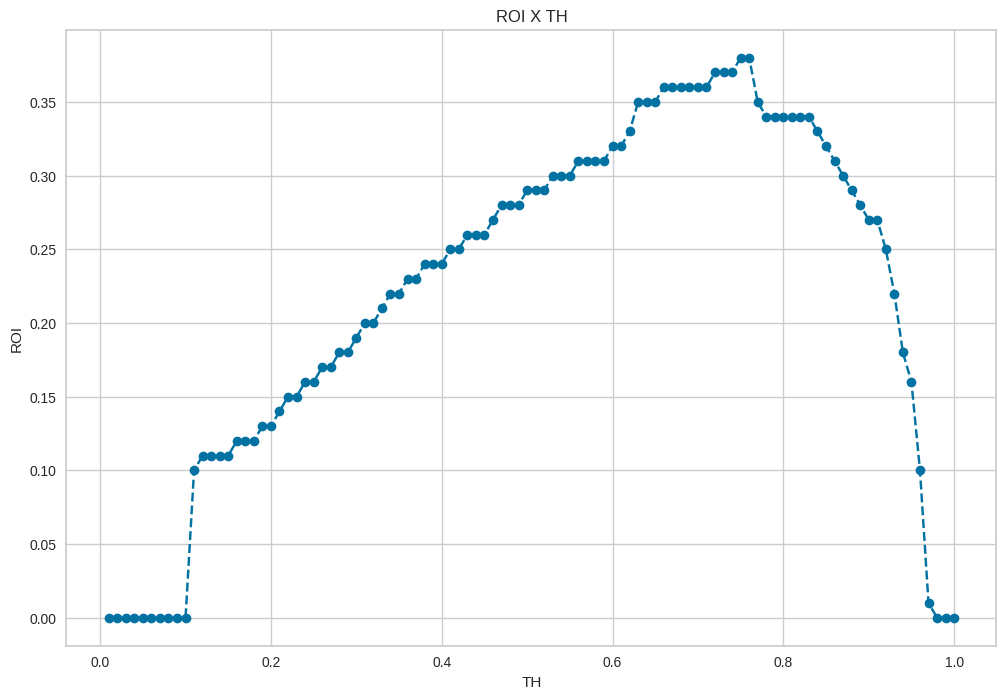

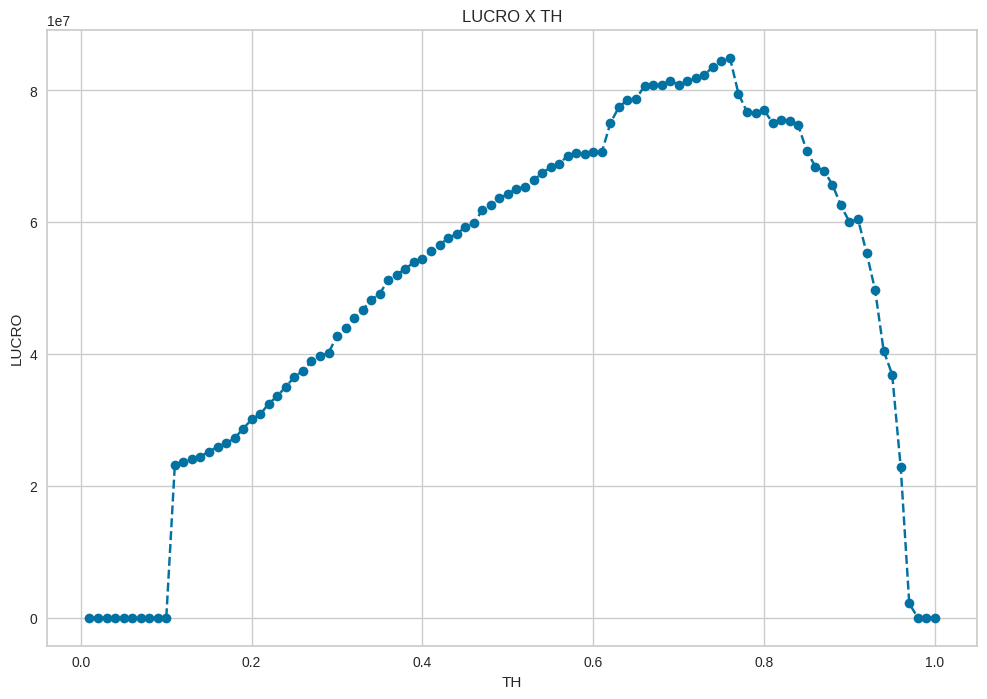

Max ROI value 0.38
Max LUCRO 84396972.75600001
BEST TH value 0.75


In [238]:
maximizar_roi(x_test, df_business, model= search_xgb.best_estimator_, custo_oportunidade=0.1)

## 13.4 VALOR DO EMPRESTIMO X PROBABILIDADE

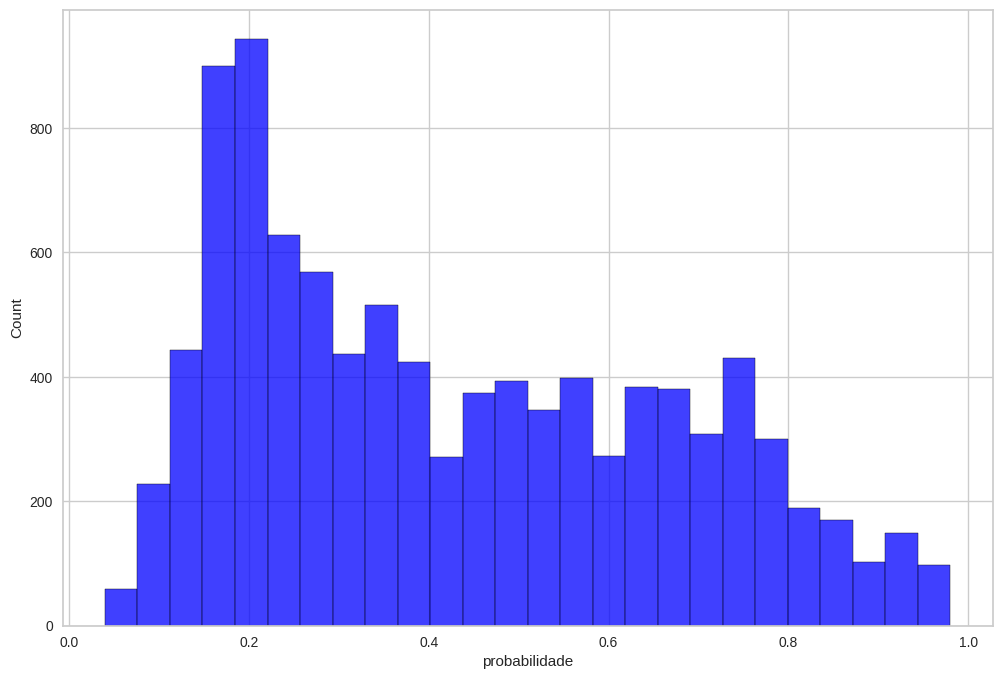

In [239]:
sns.histplot(df_business['probabilidade'], color='blue');

In [240]:
df_business.sort_values(['valor_emprestimo','probabilidade'], ascending=[False, False]).head()

id  valor_emprestimo       multa       juros  \
3982  584445481        4863816.07  2481192.54  5560717.26   
2540  978067398        4269994.14  2184281.61  3739531.47   
1296  232763886        4005443.42  2052006.23   964648.13   
3616  587261589        3613664.22  7424466.43  7848505.14   
5805  487750943        3561731.58  5490451.00  6162657.74   

      valor_emprestimo_atualizado  pago  probabilidade  pred_050  
3982                  12905725.87     1           0.97         1  
2540                  10193807.22     1           0.98         1  
1296                   7022097.78     1           0.98         1  
3616                  18886635.79     1           0.97         1  
5805                  15214840.32     1           0.89         1

### 13.4.1 INADIMPLETE PAGO = 1

In [241]:
df_pago_1 = df_business[df_business['pago'] == 1].reset_index(drop=True).copy()
df_pago = df_pago_1.sort_values(by='valor_emprestimo', ascending=False)

<Axes: xlabel='probabilidade', ylabel='valor_emprestimo'>

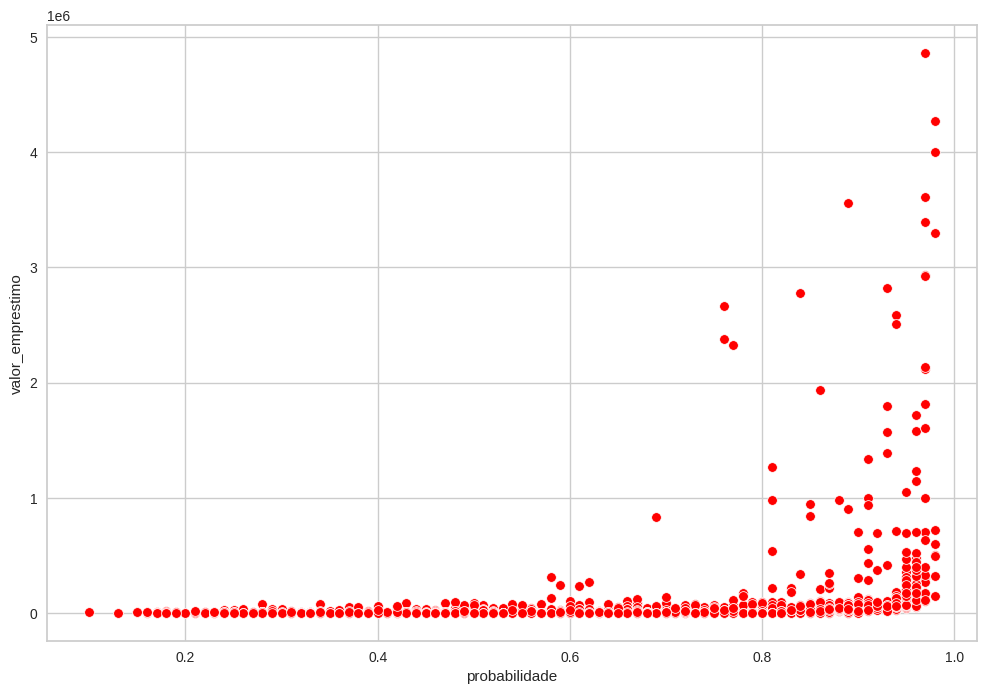

In [242]:
sns.scatterplot(x='probabilidade', y='valor_emprestimo', data=df_pago_1, color='red')

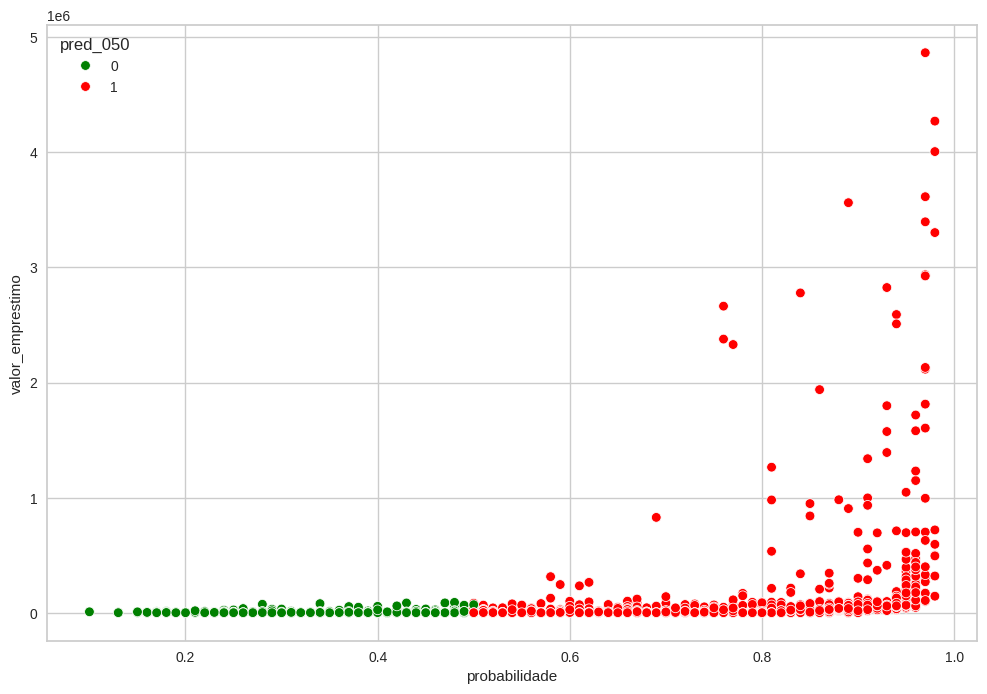

In [243]:
custom_palette = {0: 'green', 1: 'red'}
sns.set_palette(custom_palette.values())

sns.scatterplot(x='probabilidade', y= 'valor_emprestimo', data=df_pago_1,hue='pred_050');

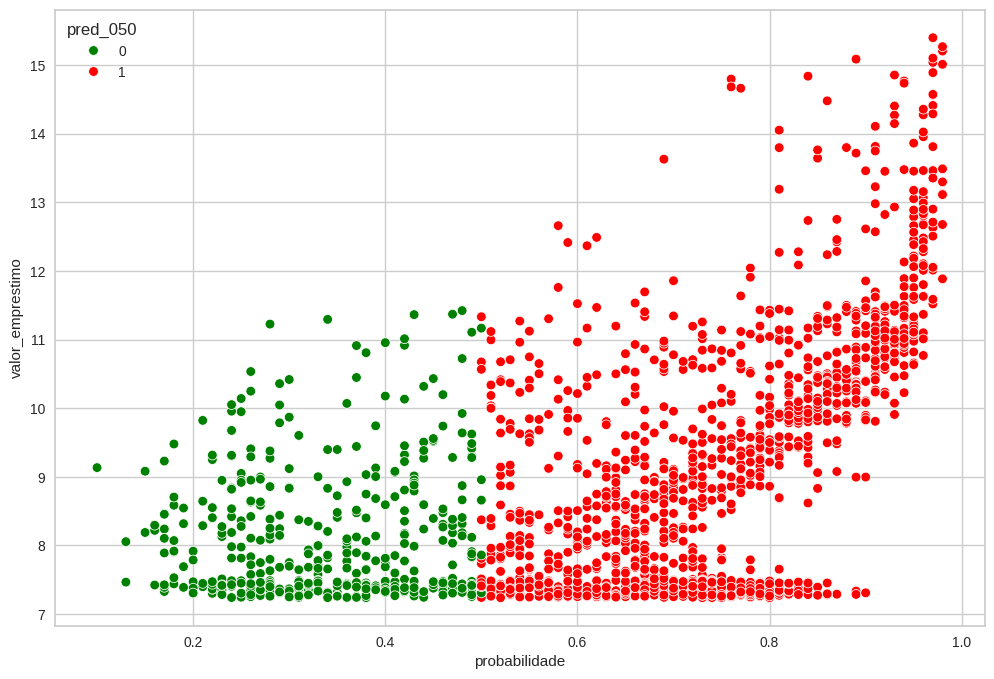

In [244]:
aux_1 = df_pago_1.copy()
aux_1['valor_emprestimo'] = np.log(aux_1['valor_emprestimo'])
sns.scatterplot(x='probabilidade', y= 'valor_emprestimo', data=aux_1,hue='pred_050');

### 13.4.2 ADIMPLENTE PAGO=0

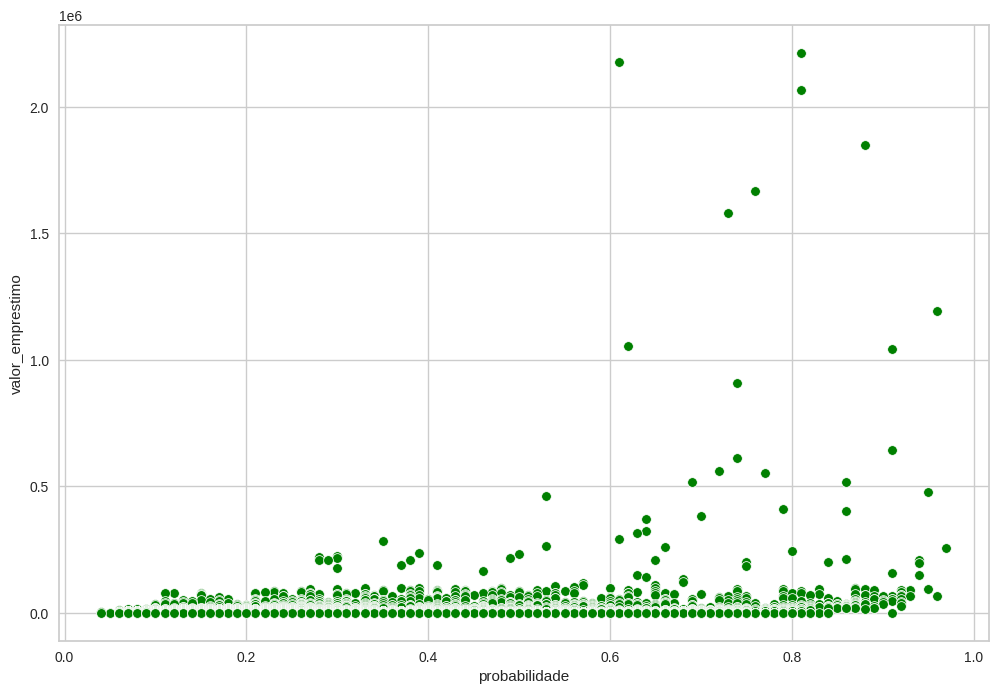

In [245]:
sns.set_palette('tab10')
df_pago_0 = df_business[df_business['pago']==0].reset_index(drop=True).copy()
df_pago_0 = df_pago_0.sort_values(by='valor_emprestimo',ascending=False)
sns.scatterplot(x=df_pago_0['probabilidade'], y = df_pago_0['valor_emprestimo'], color='green');

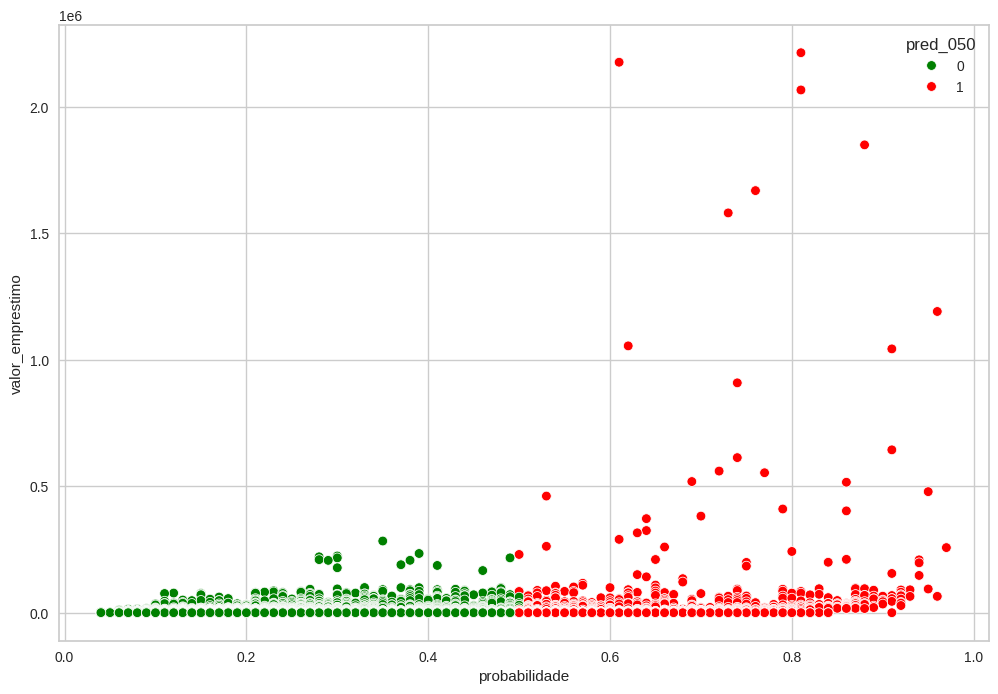

In [246]:
custom_palette = {0: 'green', 1: 'red'}
sns.set_palette(custom_palette.values())

sns.scatterplot(x='probabilidade', y='valor_emprestimo', data=df_pago_0, hue='pred_050');

<Axes: xlabel='probabilidade', ylabel='valor_emprestimo'>

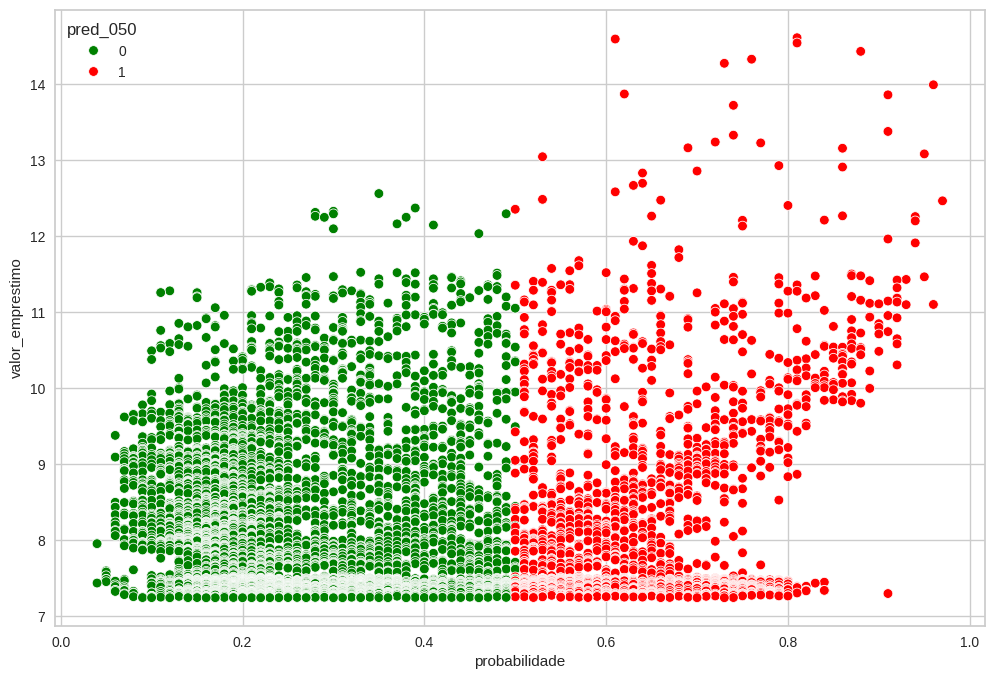

In [247]:
aux_0 = df_pago_0.copy()
aux_0['valor_emprestimo'] = np.log(aux_0['valor_emprestimo'])
sns.scatterplot(x='probabilidade', y='valor_emprestimo', data= aux_0, hue='pred_050')

## 13.5 ROI REAL POR CLIENTE

In [248]:
def roi(pago, valor_emprestimo, retorno_investimento):
    if(pago==1):
        roi = round((-valor_emprestimo / valor_emprestimo),2)
    else:
        roi = round((retorno_investimento / valor_emprestimo), 2)

    return roi

In [249]:
df_business['roi_real'] = df_business.apply(lambda x: roi(x['pago'],
                                                          x['valor_emprestimo'],
                                                          x['juros'] + x['multa']), axis=1)

count    9714.000000
mean        1.752629
std        11.158025
min        -1.000000
50%         0.330000
75%         0.940000
95%         7.764000
99%        32.638300
max       817.210000
Name: roi_real, dtype: float64


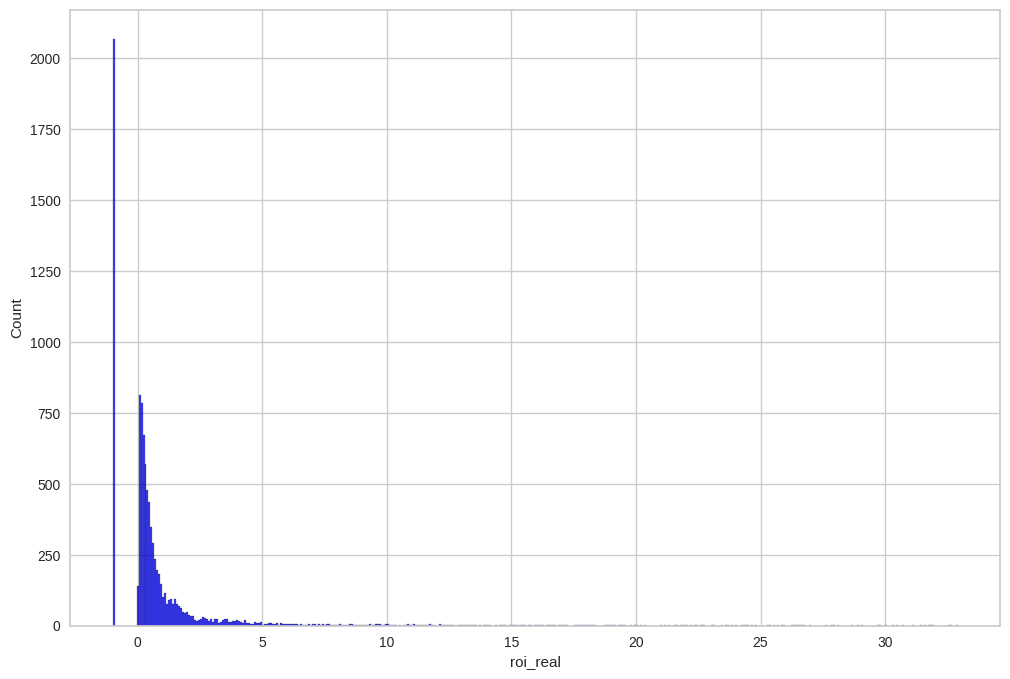

In [250]:
print(df_business['roi_real'].describe(percentiles=[0.99, 0.95, 0.75, 0.5]))
sns.histplot(df_business[df_business['roi_real']<33]['roi_real'], color='blue');

## 13.6 VALOR ESPERADO X VARIANCIA

In [251]:
def valor_esperado(prob_inadimplencia, valor_emprestimo, retorno_investimento):
    prob_adimplencia = 1 - prob_inadimplencia
    valor_esperado = (retorno_investimento * prob_adimplencia) + (-valor_emprestimo * prob_inadimplencia)

    return valor_esperado

In [252]:
df_business['valor_esperado'] = df_business.apply(lambda x: valor_esperado(x['probabilidade'], x['valor_emprestimo'], x['juros'] + x['multa']), axis=1)

In [253]:
def desvio_padrao(prob_inadimplencia, valor_emprestimo, retorno_investimento, valor_esperado):
    prob_adimplencia = 1 - prob_inadimplencia
    variancia = (((retorno_investimento - valor_esperado) **2 ) * prob_adimplencia) + (((-valor_emprestimo - valor_esperado) ** 2) * prob_inadimplencia)
    dp = np.sqrt(variancia)
    return dp

In [254]:
df_business['desvio_padrao'] = df_business.apply(lambda x: desvio_padrao(x['probabilidade'],
                                                           x['valor_emprestimo'],
                                                           x['juros'] + x['multa'],
                                                           x['valor_esperado']), axis=1)

In [255]:
df_business.sort_values(['valor_esperado', 'desvio_padrao'], ascending=[False,True]).head(20)

id  valor_emprestimo        multa        juros  \
2340  388730704           1418.00  17668900.00  13101489.35   
1108  665983594           1429.00  31990110.00  23218421.84   
174   251138144           1635.00   3836272.39    640831.72   
6838  229125865           1644.00   5110119.00   3361436.28   
4510  187674000           1782.00   2973041.50   1443411.65   
9360  564340706         217855.87    632849.74   1116601.71   
8045  961921316           1464.00   2674650.00   1983252.98   
6117  554061049           1591.00   1036200.00    723371.22   
3032  797826910           1649.00   1004850.00    607532.31   
2057  646723656           1603.00   1109402.21    200579.92   
9135  115740436           1490.00    856762.00    415957.95   
6207  749436987         316827.35    830792.70   1386291.28   
4403  305403171           1546.00   2048556.27    627267.94   
5267  789300752           1639.00   2279000.00    289433.00   
5647  596227983           1495.00   1122550.00    756823.21   
7608  951963631           1406.00    716705.00    458834.54   
4162  887045063           1538.00    354945.60    250201.15   
3783  118097899           1471.00    351988.00    170890.18   
4810  234317727           1627.00    539701.44    206327.86   
1864  897004621           1792.00    786175.40    389235.44   

      valor_emprestimo_atualizado  pago  probabilidade  pred_050  roi_real  \
2340                  30771807.35     1           0.49         0     -1.00   
1108                  55209960.84     1           0.73         1     -1.00   
174                    4478739.11     1           0.21         0     -1.00   
6838                   8473199.28     1           0.72         1     -1.00   
4510                   4418235.15     1           0.73         1     -1.00   
9360                   1967307.32     0           0.30         0      8.03   
8045                   4659366.98     1           0.77         1     -1.00   
6117                   1761162.22     1           0.47         0     -1.00   
3032                   1614031.31     1           0.45         0     -1.00   
2057                   1311585.13     0           0.35         0    817.21   
9135                   1274209.95     1           0.47         0     -1.00   
6207                   2533911.33     0           0.63         1      7.00   
4403                   2677370.21     1           0.78         1     -1.00   
5267                   2570072.00     1           0.78         1     -1.00   
5647                   1880868.21     1           0.74         1     -1.00   
7608                   1176945.54     1           0.64         1     -1.00   
4162                    606684.75     1           0.31         0     -1.00   
3783                    524349.18     1           0.23         0     -1.00   
4810                    747656.30     1           0.50         1     -1.00   
1864                   1177202.84     1           0.69         1     -1.00   

      valor_esperado  desvio_padrao  
2340    1.569220e+07   1.538283e+07  
1108    1.490526e+07   2.451098e+07  
174     3.536569e+06   1.824227e+06  
6838    2.370852e+06   3.804457e+06  
4510    1.191141e+06   1.961517e+06  
9360    1.159259e+06   9.015335e+05  
8045    1.070190e+06   1.960813e+06  
6117    9.318250e+05   8.789946e+05  
3032    8.860682e+05   8.029704e+05  
2057    8.509273e+05   6.255862e+05  
9135    6.738413e+05   6.359572e+05  
6207    6.207199e+05   1.223383e+06  
4403    5.874755e+05   1.109091e+06  
5267    5.637769e+05   1.064643e+06  
5647    4.875307e+05   8.250132e+05  
7608    4.222944e+05   5.649339e+05  
4162    4.170745e+05   2.805876e+05  
3783    4.022779e+05   2.206632e+05  
4810    3.722011e+05   3.738281e+05  
1864    3.631409e+05   5.444484e+05

In [256]:
df_business.sort_values(['probabilidade', 'valor_emprestimo', 'valor_esperado', 'desvio_padrao'], ascending=[True, False, False, True]).head(20)

id  valor_emprestimo    multa    juros  \
7432  677883875           2848.44    50.22   974.87   
3359  790071640           2838.66    49.83   917.28   
3467  382998631           2836.53    49.74  1049.97   
7931  725505645           1690.00  3662.33  2715.62   
7296  456463233           1985.03    15.69   404.87   
6141  845462110           1954.84    14.47    56.56   
1945  905692346           1860.46    10.70   143.96   
8212  648504030           1775.00   863.50   572.24   
4300  473534171           1773.00    79.43    58.90   
8008  187902936           1721.00  2696.19   372.59   
3173  997427209          11800.66   408.31  2260.99   
9682  344263547           8865.76   290.91  1045.30   
7437  137322917           4891.13   131.93  2303.36   
938   837519479           4596.84   120.15  1368.62   
4632  607396176           4589.00   119.84  2772.04   
2520  833134086           4152.97   102.40  1764.35   
3517  651755713           3779.72    87.46  1349.40   
1710  546727340           3628.62    81.43  1718.62   
868   889049369           3373.02    71.20   662.23   
568   606872399           3340.61    69.91  1656.91   

      valor_emprestimo_atualizado  pago  probabilidade  pred_050  roi_real  \
7432                      3873.53     0           0.04         0      0.36   
3359                      3805.77     0           0.04         0      0.34   
3467                      3936.24     0           0.04         0      0.39   
7931                      8067.95     0           0.04         0      3.77   
7296                      2405.59     0           0.05         0      0.21   
6141                      2025.87     0           0.05         0      0.04   
1945                      2015.12     0           0.05         0      0.08   
8212                      3210.74     0           0.05         0      0.81   
4300                      1911.33     0           0.05         0      0.08   
8008                      4789.78     0           0.05         0      1.78   
3173                     14469.96     0           0.06         0      0.23   
9682                     10201.97     0           0.06         0      0.15   
7437                      7326.42     0           0.06         0      0.50   
938                       6085.61     0           0.06         0      0.32   
4632                      7480.88     0           0.06         0      0.63   
2520                      6019.72     0           0.06         0      0.45   
3517                      5216.58     0           0.06         0      0.38   
1710                      5428.67     0           0.06         0      0.50   
868                       4106.45     0           0.06         0      0.22   
568                       5067.43     0           0.06         0      0.52   

      valor_esperado  desvio_padrao  
7432      870.148803     759.053752  
3359      814.879203     745.775558  
3467      942.260404     771.342352  
7931     6055.232007    1580.988845  
7296      300.280498     524.286189  
6141      -30.263502     441.528133  
1945       53.903998     439.185225  
8212     1275.202998     699.764565  
4300       42.763499     416.564719  
8008     2829.290996    1043.908356  
3173     1801.102419    3436.425065  
9682      724.091814    2422.833609  
7437     1995.704810    1739.928329  
938      1123.633408    1445.252284  
4632     2443.027210    1776.610546  
2520     1505.566808    1429.604276  
3517     1123.865207    1238.869096  
1710     1474.329807    1289.237680  
868       487.043006     975.227831  
568      1422.774207    1203.447934

<Axes: xlabel='desvio_padrao', ylabel='valor_esperado'>

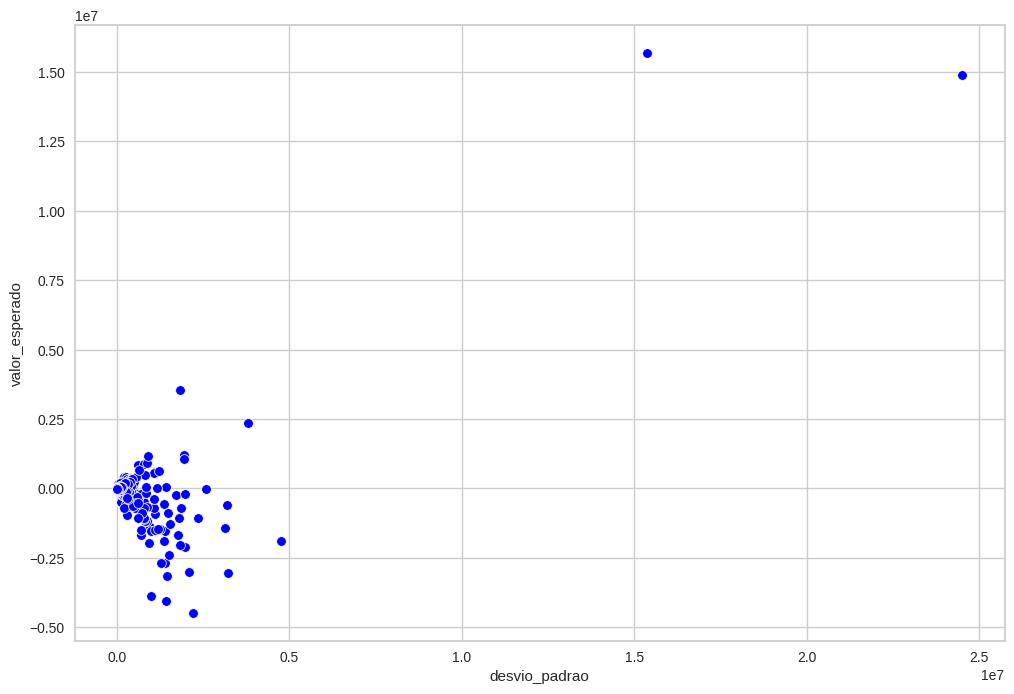

In [257]:
sns.scatterplot(x='desvio_padrao', y='valor_esperado', data = df_business, color='blue')

In [258]:
aux = df_business[df_business['valor_esperado'] >0 ].copy()

<Axes: xlabel='desvio_padrao', ylabel='valor_esperado'>

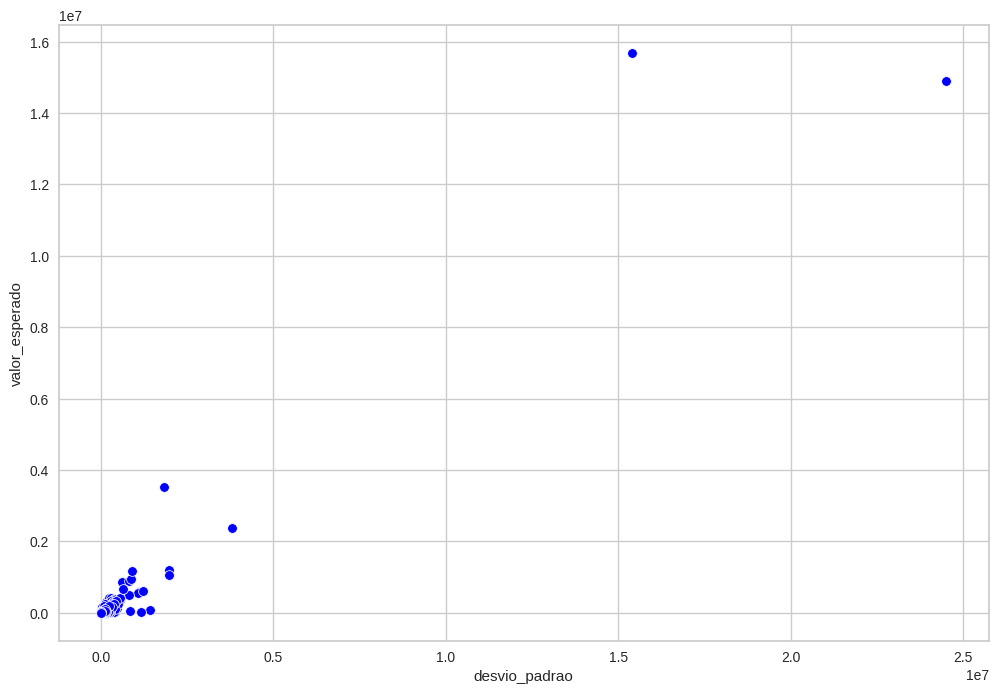

In [259]:
sns.scatterplot(x='desvio_padrao', y='valor_esperado', data = aux, color='blue')

In [260]:
aux = df_business[(df_business['valor_esperado'] >0) & (df_business['desvio_padrao'] < 2_000_000 )].copy()

<Axes: xlabel='desvio_padrao', ylabel='valor_esperado'>

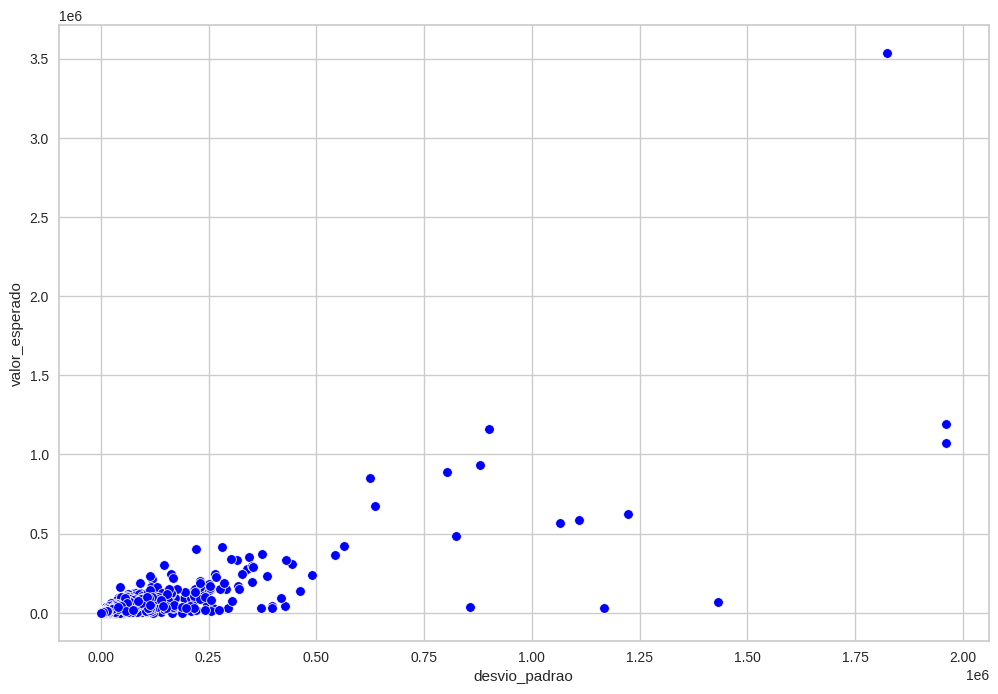

In [261]:
sns.scatterplot(x='desvio_padrao', y='valor_esperado', data = aux, color='blue')

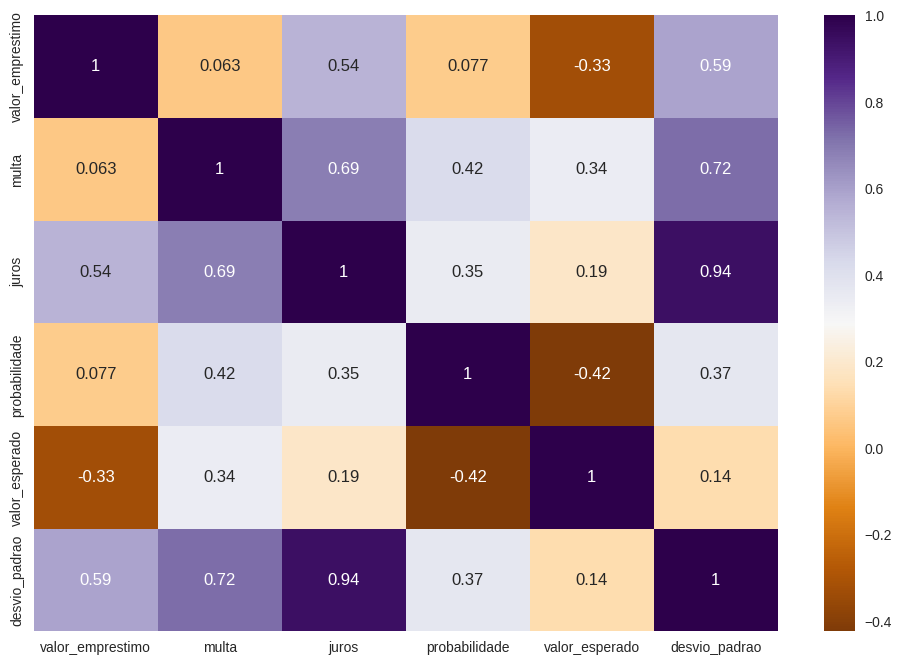

In [262]:
sns.heatmap(df_business[['valor_emprestimo', 'multa', 'juros', 'probabilidade', 'valor_esperado', 'desvio_padrao']].corr('spearman'), cmap='PuOr', annot=True);

## 13.7 CUMULATIVE GAIN AND LIFT CURVE

In [263]:
import scikitplot as skplot

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

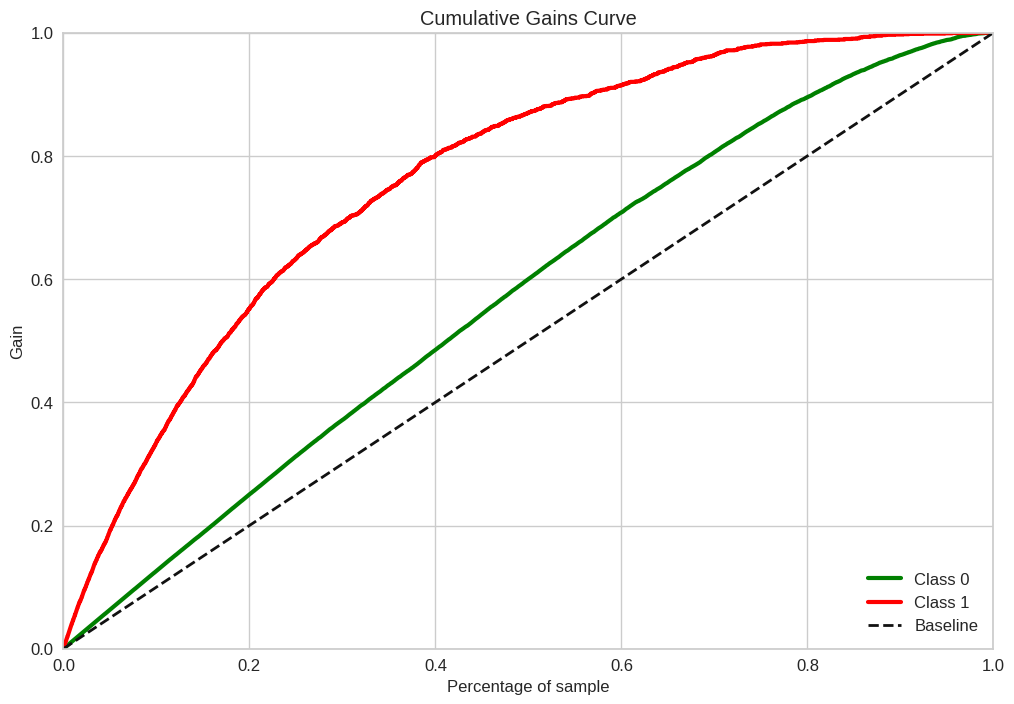

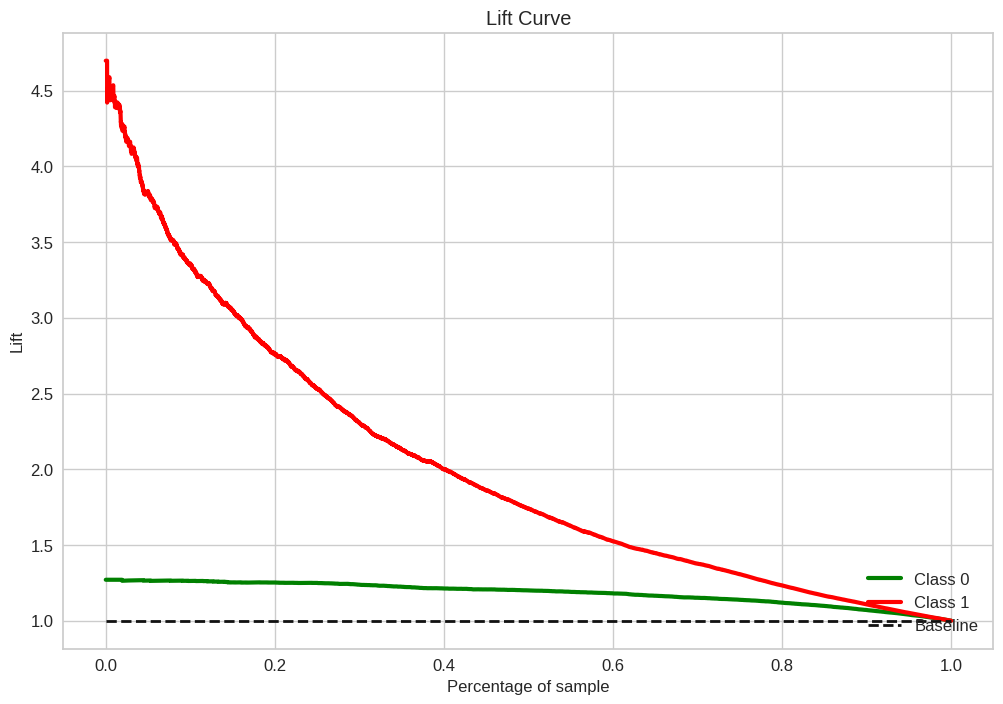

In [264]:
yhat_proba = search_xgb.best_estimator_.predict_proba(x_test)

skplot.metrics.plot_cumulative_gain(y_test, yhat_proba)
skplot.metrics.plot_lift_curve(y_test, yhat_proba)

## 13.8 PRECISION AND RECALL AT K

### 13.8.1 INADIMPLENTE

In [265]:
df_business_sort = df_business.sort_values('probabilidade', ascending=False)
df_business_sort 

id  valor_emprestimo       multa       juros  \
5665  301581889         320097.01   418666.01   181623.71   
7495  437276438        3302165.11  3400734.11  8217207.30   
8863  778193865         720307.97   409438.52   433801.22   
1296  232763886        4005443.42  2052006.23   964648.13   
6381  706052746         499672.38    23929.64   376231.84   
...         ...               ...         ...         ...   
7296  456463233           1985.03       15.69      404.87   
3467  382998631           2836.53       49.74     1049.97   
7931  725505645           1690.00     3662.33     2715.62   
3359  790071640           2838.66       49.83      917.28   
7432  677883875           2848.44       50.22      974.87   

      valor_emprestimo_atualizado  pago  probabilidade  pred_050  roi_real  \
5665                    920386.73     1           0.98         1     -1.00   
7495                  14920106.52     1           0.98         1     -1.00   
8863                   1563547.71     1           0.98         1     -1.00   
1296                   7022097.78     1           0.98         1     -1.00   
6381                    899833.86     1           0.98         1     -1.00   
...                           ...   ...            ...       ...       ...   
7296                      2405.59     0           0.05         0      0.21   
3467                      3936.24     0           0.04         0      0.39   
7931                      8067.95     0           0.04         0      3.77   
3359                      3805.77     0           0.04         0      0.34   
7432                      3873.53     0           0.04         0      0.36   

      valor_esperado  desvio_padrao  
5665   -3.016893e+05   1.288541e+05  
7495   -3.003763e+06   2.088814e+06  
8863   -6.890370e+05   2.188966e+05  
1296   -3.865002e+06   9.830932e+05  
6381   -4.816757e+05   1.259767e+05  
...              ...            ...  
7296    3.002805e+02   5.242862e+02  
3467    9.422604e+02   7.713424e+02  
7931    6.055232e+03   1.580989e+03  
3359    8.148792e+02   7.457756e+02  
7432    8.701488e+02   7.590538e+02  

[9714 rows x 11 columns]

In [266]:
df_business_sort['pago'].value_counts()

pago
0    7646
1    2068
Name: count, dtype: int64

In [267]:
df_business_sort['pago'].value_counts(normalize=True)

pago
0    0.787111
1    0.212889
Name: proportion, dtype: float64

In [268]:
len(df_business_sort)/5

1942.8

In [269]:
df_business_sort.iloc[:1942]['pago'].value_counts()

pago
1    1143
0     799
Name: count, dtype: int64

In [270]:
df_business_sort.iloc[:1942]['pago'].value_counts(normalize=True)

pago
1    0.588568
0    0.411432
Name: proportion, dtype: float64

In [271]:
1040/2068

0.5029013539651838

In [272]:
def precision_at_k_class(data, k, classe):
    data = data.reset_index(drop=True)

    data['ranking'] = data.index + 1 

    data['correct_target'] = data.apply(lambda x: 1 if(x['pred_050'] == classe and x['pago'] == classe) else 0, axis = 1 )

    data['precision_at_k'] = data['correct_target'].cumsum() / data['ranking']

    return round(data.loc[k, 'precision_at_k'], 2)

def recall_at_k_class(data, k, classe):

    # reset index
    data = data.reset_index(drop=True)
    # create ranking order
    data['ranking'] = data.index +1

    data['correct_target'] = data.apply(lambda x: 1 if(x['pred_050'] == classe and x['pago'] == classe) else 0, axis = 1 )

    data['recall_at_k'] = data['correct_target'].cumsum() / data[data['pago'] == classe]['pago'].count()

    return round(data.loc[k, 'recall_at_k'], 2)


In [273]:
recall_at_1942 = recall_at_k_class(df_business_sort, k=1942, classe=1)
recall_at_1942

0.55

In [274]:
precision_at_1942 = precision_at_k_class(df_business_sort, k=1942, classe=1)
precision_at_1942

0.59

### 13.8.2 ADIMPLEMte

In [275]:
df_business_sort = df_business.sort_values('probabilidade', ascending=True)
df_business_sort.head()

id  valor_emprestimo    multa    juros  \
3467  382998631           2836.53    49.74  1049.97   
7931  725505645           1690.00  3662.33  2715.62   
7432  677883875           2848.44    50.22   974.87   
3359  790071640           2838.66    49.83   917.28   
8212  648504030           1775.00   863.50   572.24   

      valor_emprestimo_atualizado  pago  probabilidade  pred_050  roi_real  \
3467                      3936.24     0           0.04         0      0.39   
7931                      8067.95     0           0.04         0      3.77   
7432                      3873.53     0           0.04         0      0.36   
3359                      3805.77     0           0.04         0      0.34   
8212                      3210.74     0           0.05         0      0.81   

      valor_esperado  desvio_padrao  
3467      942.260404     771.342352  
7931     6055.232007    1580.988845  
7432      870.148803     759.053752  
3359      814.879203     745.775558  
8212     1275.202998     699.764565

In [276]:
df_business_sort['pago'].value_counts()

pago
0    7646
1    2068
Name: count, dtype: int64

In [277]:
df_business_sort['pago'].value_counts(normalize=True)

pago
0    0.787111
1    0.212889
Name: proportion, dtype: float64

In [278]:
len(df_business_sort)/5

1942.8

In [279]:
df_business_sort.iloc[:1942]['pago'].value_counts()

pago
0    1914
1      28
Name: count, dtype: int64

In [280]:
df_business_sort.iloc[:1942]['pago'].value_counts(normalize=True)

pago
0    0.985582
1    0.014418
Name: proportion, dtype: float64

In [281]:
1840/7646

0.24064870520533613

In [282]:
recall_at_1942 = recall_at_k_class(df_business_sort, k=1942, classe=0)
recall_at_1942

0.25

In [283]:
precision_at_1942 = precision_at_k_class(df_business_sort, k=1942, classe=0)
precision_at_1942

0.99

## 13.9 ALOCAÇÃO DE BUDGET LIMITADA

In [284]:
df_business_sort = df_business.sort_values(['probabilidade', 'valor_esperado', 'desvio_padrao'], ascending=[True,False, True])

In [285]:
def roi_at_budget(data, budget):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index +1

    data['acc_valor_emprestimo']= data['valor_emprestimo'].cumsum()
    aux_budget = 0

    for i in range(0, len(data)+1):
        if(data.loc[i, 'acc_valor_emprestimo'] < budget):
            aux_budget = i
        else:
            break
    data_roi = data.iloc[:aux_budget]
    
    data_roi = data_roi.groupby(['pago', 'pred_050']).agg(
    valor_emprestimo = ('valor_emprestimo','sum'),
    juros = ('juros','sum'),
    multa = ('multa', 'sum'),
    emprestimo_atualizado = ('valor_emprestimo_atualizado', 'sum'),
    ).reset_index()

    display(data_roi)
    valor_emprestimo = data_roi['valor_emprestimo'].sum()
    retorno = 0

    for i in range(0, len(data_roi)):
        if(data_roi.loc[i, 'pago'] == 0 and data_roi.loc[i, 'pred_050'] == 0):
            retorno = retorno + data_roi.loc[i, 'juros'] + data_roi.loc[i,'multa']

        elif(data_roi.loc[i, 'pago'] == 0 and data_roi.loc[i, 'pred_050'] == 1):
            retorno = retorno + data_roi.loc[i, 'juros'] + data_roi.loc[i,'multa']

        
        elif(data_roi.loc[i, 'pago'] == 1 and data_roi.loc[i, 'pred_050'] == 0):
            retorno = retorno - data_roi.loc[i, 'valor_emprestimo']

        elif(data_roi.loc[i, 'pago'] == 1 and data_roi.loc[i, 'pred_050'] == 1):
            retorno = retorno - data_roi.loc[i, 'valor_emprestimo']

    print(f'Budget {valor_emprestimo}')
    print(f'Lucro value {round(retorno,2)}')
    print(f'Roi value {round((retorno / valor_emprestimo), 2)}')
    print(f'Numero de clientes {aux_budget}')

In [286]:
roi_at_budget(df_business_sort, budget=10_000_000)

pago  pred_050  valor_emprestimo       juros       multa  \
0     0         0        9880823.94  4956384.17  3465034.13   
1     1         0         111138.53   107674.55   168357.19   

   emprestimo_atualizado  
0            18302242.24  
1              387170.27

Budget 9991962.469999999
Lucro value 8310279.77
Roi value 0.83
Numero de clientes 1851


# 14.0 EXPORT MODELS

In [8]:
import pickle

In [ ]:
pickle.dump(search_xgb.best_estimator_, open(config['model']['ml_path'], 'wb'))

In [ ]:
pickle.dump(explainer_xgb, open(config['model']['shap_path'], 'wb'))

# 15.0 READ AND TEST MODELS

## 15.1 XGBOOST

In [9]:
xgb_model = pickle.load(open(config['model']['ml_path'], 'rb'))

In [10]:
test_set = pd.read_csv(config['data']['test_path'])

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade','valor_emprestimo', 'pago']
test_set = test_set[columns_select]
x_test = test_set.drop('pago', axis='columns')
y_test = test_set['pago']

In [11]:
test_set = pd.read_csv(config['data']['test_path'])
test_set['label'] = (xgb_model.predict_proba(x_test)[:,1]>=0.75).astype(int)

test_set['label'] = test_set['label'].apply(lambda x: 'Adimplente' if x==0 else 'Inadumplente')

test_set['proba'] = xgb_model.predict_proba(x_test)[:,1]
test_set['proba_label'] = test_set.apply(lambda x: x['label'] + ' ' + str(round(x['proba'], 2)), axis=1)

In [12]:
test_set.head().T

0                               1  \
dependentes                                S                               N   
estado_civil                        solteiro  casado(a) com comunhao de bens   
idade                                     23                              35   
conta_poupanca                             S                               S   
conta_salario                              N                               N   
cheque_sem_fundo                           N                               S   
conta_conjunta                             N                               N   
valor_emprestimo                      3456.8                        14015.09   
multa                                  74.55                          496.88   
juros                                 313.79                         8859.83   
valor_emprestimo_atualizado          3845.14                         23371.8   
pago                                       0                               0   
id                                 177315218                       719949826   
genero                              feminino                       masculino   
estado                          minas gerais                  rio de janeiro   
juros_porcentagem                   0.090775                        0.632164   
label                             Adimplente                      Adimplente   
proba                               0.209856                         0.74426   
proba_label                  Adimplente 0.21                 Adimplente 0.74   

                                           2                3                4  
dependentes                                S                S                N  
estado_civil                        solteiro         solteiro         solteiro  
idade                                     29               31               33  
conta_poupanca                             S                S                S  
conta_salario                              N                N                N  
cheque_sem_fundo                           N                N                N  
conta_conjunta                             N                N                N  
valor_emprestimo                     6577.05          44760.1          36560.0  
multa                                 199.36           1726.7           6993.4  
juros                                 2842.3          22989.9          2107.81  
valor_emprestimo_atualizado          9618.71          69476.7         45661.21  
pago                                       0                0                0  
id                                 195205898        934339581        293910277  
genero                             masculino         feminino         feminino  
estado                             sao paulo   rio de janeiro     minas gerais  
juros_porcentagem                   0.432154         0.513625         0.057653  
label                             Adimplente       Adimplente       Adimplente  
proba                               0.093704         0.490884         0.261663  
proba_label                  Adimplente 0.09  Adimplente 0.49  Adimplente 0.26

## 15.2 SHAP MODEL

In [13]:
shap_model = pickle.load(open(config['model']['shap_path'], 'rb'))

In [14]:
test_set = pd.read_csv(config['data']['test_path'])
columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'idade', 'valor_emprestimo', 'pago']
test_set = test_set[columns_select]
x_test = test_set.drop('pago', axis=1)
y_test = test_set['pago']

In [15]:
x_test = xgb_model.named_steps['rare_encoder'].transform(x_test.head(1))
x_test = xgb_model.named_steps['categorical_encoder'].transform(x_test.head(1))

x_test


dependentes  estado_civil  cheque_sem_fundo  idade  valor_emprestimo
0     0.098823      0.115135          0.095252     23            3456.8

In [16]:
test_set.head(1)

dependentes estado_civil cheque_sem_fundo  idade  valor_emprestimo  pago
0           S     solteiro                N     23            3456.8     0

In [17]:
a = shap_model(x_test)

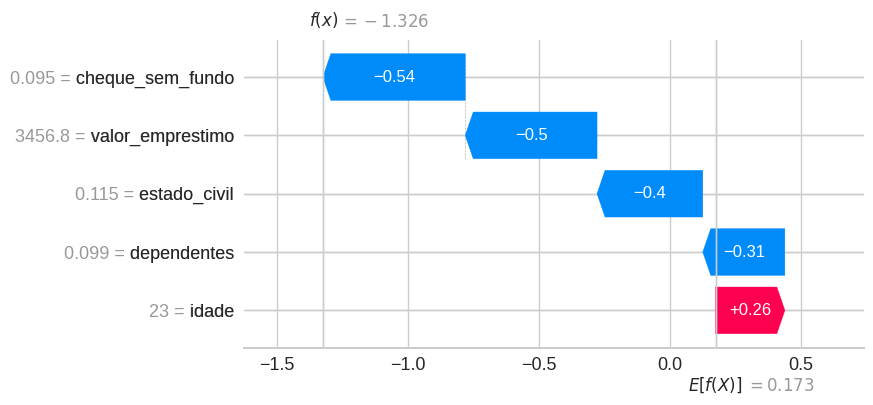

In [18]:
shap.plots.waterfall(a[0])

In [19]:
import requests

In [20]:
data = {
    "dependentes": "S",
    "estado_civil": "solteiro",
    "idade": 23,
    "cheque_sem_fundo": "S",
    "valor_emprestimo": 100000
}

In [21]:
response = requests.post("http://localhost:8001/predict", json=data)
prediction = response.text

In [22]:
prediction

'{"resultado":"Adimplente","probabilidade":0.74,"shap_output":{"values":[[-0.5525792241096497,-0.5765414237976074,0.27276521921157837,0.022678367793560028,1.7016023397445679]],"base_values":0.17311981320381165,"data":[[0.09882310663911598,0.11513513513513514,0.24747159445623673,23.0,100000.0]]},"feature_names_values":{"dependentes":0.09882310663911598,"estado_civil":0.11513513513513514,"cheque_sem_fundo":0.24747159445623673,"idade":23,"valor_emprestimo":100000.0}}'

In [24]:
str(response.json()['resultado']) + 'probabilidade de inadimplencia = ' + str(response.json()['probabilidade'])

'Adimplenteprobabilidade de inadimplencia = 0.74'

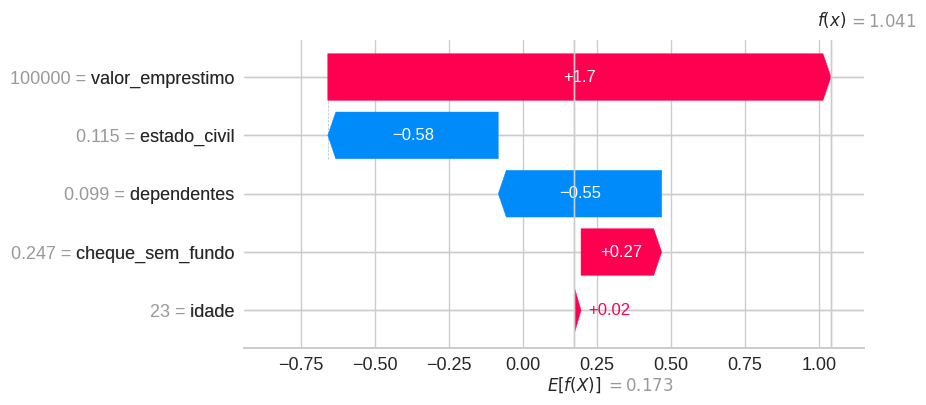

In [29]:
shap_output = response.json()['shap_output']
values = np.array(shap_output['values'][0])
base_value = shap_output['base_values']
feature_values = np.array(shap_output['data'][0])

feature_names_values = response.json()['feature_names_values']
feature_names = [name for name, value in sorted(feature_names_values.items(),key=lambda item: feature_values.tolist().index(item[1]))]

explainer = shap.Explanation(values=values, base_values=base_value, data=feature_values, feature_names=feature_names)
shap.plots.waterfall(explainer)